In this notebook, we will import the MSEG data, clean it,  and attempt to use it for the classification and demand prediction analysis.


# Imports

In [1]:
%matplotlib inline
import pandas as pd
import ERIKS_forecasting as EF
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import importlib
import os.path as path
import matplotlib as mpl
import Plotting_ED
import time
from datetime import datetime
import random
import pickle

# Notebook 1 - Import data

In [2]:
df_MSEG = pd.read_csv(r"Data\MSEG_Data\MSEG_21_Jan_2021.csv", encoding = "ISO-8859-1", sep = ';')


## Explore MSEG data

In [3]:
df_MSEG.head()

,MaterialNo,MaterialDocumentYear,Plant,InventoryMovementType,PostingDate,Quantity,BaseUnitOfMeasure,IsRecordDeleted
0,NL-000000000023087411,2017,EN01,601,20170104,5.0,ST,True
1,NL-000000000023410142,2017,EN01,601,20170104,1.0,ST,True
2,NL-000000000023114681,2017,EN01,601,20170104,1.0,ST,True
3,NL-000000000023114683,2017,EN01,601,20170104,1.0,ST,True
4,NL-000000000023114462,2017,EN01,601,20170104,2.0,ST,True


In [4]:
df_MSEG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7766186 entries, 0 to 7766185
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   MaterialNo             object 
 1   MaterialDocumentYear   int64  
 2   Plant                  object 
 3   InventoryMovementType  int64  
 4   PostingDate            int64  
 5   Quantity               float64
 6   BaseUnitOfMeasure      object 
 7   IsRecordDeleted        bool   
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 422.2+ MB


In [5]:
print (df_MSEG.MaterialNo.nunique())
print (df_MSEG.Plant.value_counts())
print (len(df_MSEG))

521837
EN01    4324519
EN10     867332
EN05     781893
EN04     676168
EN11     293577
EN06     256402
EN43     250870
EN34      88884
EN12      72467
EN07      68433
EN14      59471
EN17       9257
EN15       3850
ENHO       3717
EN13       2865
EN37       2575
EN16       1501
EN28        889
EN20        684
EN41        441
EN24        327
EN35         48
EN44         10
EN50          5
EN36          1
Name: Plant, dtype: int64
7766186


In [6]:
df_MSEG.MaterialDocumentYear.value_counts()


2019    2061163
2018    1997352
2017    1945066
2020    1677143
2021      85462
Name: MaterialDocumentYear, dtype: int64

In [7]:
df_MSEG.IsRecordDeleted.value_counts()


False    5821120
True     1945066
Name: IsRecordDeleted, dtype: int64

In [8]:
df_MSEG.BaseUnitOfMeasure.value_counts()


ST     6589263
M2      600043
M       395941
PAA      48937
CS       42900
KG       32471
SET      18122
ROL      15374
PAK      10542
MM        6561
BAG       2037
CM2       1420
KK         886
MM2        498
BOT        331
CM         305
L          167
KAN        141
BJ         102
CG          61
ST3         21
WCH         14
H           13
LM          10
SH           6
TAG          5
CQ           4
KI           2
100          2
KIT          2
FT           1
EA           1
KM           1
PAL          1
GRO          1
Name: BaseUnitOfMeasure, dtype: int64

In [9]:
df_MSEG.PostingDate.value_counts()


20200128    13743
20190307    11810
20190528    11653
20181127    11644
20180514    10875
            ...  
20170805        1
20171021        1
20170722        1
20180630        1
20170827        1
Name: PostingDate, Length: 1297, dtype: int64

Okay, so the data looks to have loaded in okay, and we have around 7.8 million rows of orders, over around 520k SKUs.
Let's filter this on the set of SKUs we'd like to work with. This will be the set of SKUs in the slimstock forecast dataset we have for the 14th July 2020. Then let's examine the dataframe again. 

# Filtering MSEG on the Slim4 snapshot data SKUs


## Import

In [10]:
df_slim_snap_14_jul = pd.read_csv(r'Data\Slimstock_snapshots_data\July_2020\EN_PowerBI_data_Klant Specifiek_Gebonden 14.07.2020.txt', sep = '\t',  encoding = "ISO-8859-1") 
print (len(df_slim_snap_14_jul.columns))
df_slim_snap_14_jul.head(5)

C:\Users\shahe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (34,36,38,102,112) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


125


,Artikel Code,Locatie,Code,Artikel Omschrijving,Verwervingssoort,Afzet Klasse,Voorraadsoort,Voorraadsoort naam,Leverancier Nr,Leverancier,...,Forecast Exceptie,ABC Klasse Geïmporteerd,Planningsprofiel oud | datum,H:StockDays,H:s4s_DaysOfInventoryOnHand,Klant met hoogste afzet afgelopen jaar,Klant met hoogste afzet afgelopen 3 maanden,Artikelnotitie,Datum Afgehandeld,H:Omloopsnelheid
0,EN0100605328,EN01,605328,VSTIR1.1/2ED 0189402100,F,6,3.0,Gangbare voorraad,EN10,ERIKS BV Roermond,...,1,B,| 20191016,0.0,0.0,NaN,NaN,NaN,NaN,0.0
1,EN0100607517,EN01,607517,ZDL06=ZDS06 0010002000,F,6,2.0,Exit voorraad,EN10,ERIKS BV Roermond,...,1,C,| 20191016,0.0,0.0,NaN,NaN,NaN,NaN,0.0
2,EN0100607975,EN01,607975,"BESCHERMHULS RBHS 3/8"" BL PW INW 19,5",F,6,3.0,Gangbare voorraad,EN10,ERIKS BV Roermond,...,1,C,| 20191016,0.0,0.0,NaN,NaN,Is vervangen door 11326752,NaN,0.0
3,EN0100750352,EN01,750352,GE08LR1/4 -m+d 0710052000,F,6,3.0,Gangbare voorraad,EN10,ERIKS BV Roermond,...,1,A,| 20191016,0.0,0.0,NaN,NaN,NaN,NaN,0.0
4,EN0100750360,EN01,750360,GE12LR3/8 -m+d 0710152000,F,6,3.0,Gangbare voorraad,EN10,ERIKS BV Roermond,...,1,A,| 20191016,0.0,0.0,NaN,NaN,NaN,NaN,0.0


In [11]:
print (df_slim_snap_14_jul['Artikel Code'].nunique())

290185


## Clean

Let's trim the Artikel Code column to get the eight digit SKU identifier we're familiar with. But to avoid this running multiple times, and breaking, we re-import the dataset in the same cell:

In [12]:
df_slim_snap_14_jul = pd.read_csv(r'Data\Slimstock_snapshots_data\July_2020\EN_PowerBI_data_Klant Specifiek_Gebonden 14.07.2020.txt', sep = '\t',  encoding = "ISO-8859-1") 
df_slim_snap_14_jul['Artikel Code'] = df_slim_snap_14_jul['Artikel Code'].str[4:]
pd.set_option('display.max_columns', None)
df_slim_snap_14_jul.head(1)

C:\Users\shahe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (34,36,38,102,112) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Artikel Code,Locatie,Code,Artikel Omschrijving,Verwervingssoort,Afzet Klasse,Voorraadsoort,Voorraadsoort naam,Leverancier Nr,Leverancier,Productgroep EN,Hoofdgroep,Index,Base UOM,Positietypegroep,Planningsprofiel,Planningskenmerk,Voorraad Artikel,Fysieke Voorraad,Economische voorraad,Besteld,Na te Leveren,Bevestigde Orders,Bestelpunt Slim4 (ex bev. extra),Bestelpunt SAP,BPSLIM4 tov BPSAP,Verschil bestelpuntwaarde,Buffer Voorraad,Forecast (CP),Aantal mnd verbruik,Prijs,Voorraadwaarde,Jaarverbruik,Onafgerond vrbk 12 mnd,Begin IJzer vrd YYYYMMD,Einde IJzer vrd YYYYMMDD,Klant IJzer VRD,IJzeren Voorraad,Opmerking IJzer vrd,Veiligheids Voorraad Overschrijven,ABC Klasse,Orderregels per jaar,Service Level,Bestelkosten,Planner,MOQ,Economische Bestelhoeveelheid,IOQ,Leveranciers MOQ,Berekende EOQ,Resultaat EOQ,Minseriegrt (artstam) SAP,Leveringseenheid verkoop,PP door Slim4 gecreeerd,Inkoopgroep,Levertijd (d),Review tijd (d),ABC Klasse Orderregels,ABC Klasse Verkoop,Levertijd Afwijking (m),Leveranciers Betrouwbaarheid Instelling,Gemid. afzet (forecast),Aantal unieke klanten (1 jaar),Afwaarderingskengetal,Relevante Afzet,Afzet 23,Afzet 22,Afzet 21,Afzet 20,Afzet 19,Afzet 18,Afzet 17,Afzet 16,Afzet 15,Afzet 14,Afzet 13,Afzet 12,Afzet 11,Afzet 10,Afzet 9,Afzet 8,Afzet 7,Afzet 6,Afzet 5,Afzet 4,Afzet 3,Afzet 2,Afzet 1,Afzet 0,ADM,Forecast 1,Forecast 2,Forecast 3,Forecast 4,Forecast 5,Forecast 6,Forecast 7,Forecast 8,Forecast 9,Forecast 10,Forecast 11,Forecast 12,Gekoppelde Artikelen,Gekoppeld Percentage,Art.nr. leverancier,Aankoopwaarde,Goederengroep,Grootste transactie (1 jaar),Leverende vestiging verkoop,Speciale verwerving,Formulespecifieke status,Vestigingspecifieke status,Gevaarlijke stof,Inkoopgroep.1,Voorraad Exceptie,Forecast Exceptie,ABC Klasse Geïmporteerd,Planningsprofiel oud | datum,H:StockDays,H:s4s_DaysOfInventoryOnHand,Klant met hoogste afzet afgelopen jaar,Klant met hoogste afzet afgelopen 3 maanden,Artikelnotitie,Datum Afgehandeld,H:Omloopsnelheid
0,00605328,EN01,605328,VSTIR1.1/2ED 0189402100,F,6,3.0,Gangbare voorraad,EN10,ERIKS BV Roermond,A1 Hydr. Slangen & Toeb,43,43170,ST,NORM,VPD1,PD,1,0,0,0,0,0.0,0,0.0,0,0.0,0,0.0,0,3.41,0.0,0,0.0,NaN,NaN,NaN,0,NaN,0,F,0,80.0,7.0,005,1,0,1,1,0,0,0.0,1.0,VPD1,N1A,2,7,F,F,0.0,0,0.0,0,0.0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,NaN,0.0,43170025,0,EN10,4ATransport (inkoop vestiging EN10),Z1,NaN,NaN,N1A,13,1,B,| 20191016,0.0,0.0,NaN,NaN,NaN,NaN,0.0


## Explore data

Now, how many SKUs are in this file, and how long is it? 

In [13]:
print (df_slim_snap_14_jul['Artikel Code'].nunique())
print (len(df_slim_snap_14_jul))

213003
290185


So we have 213 SKUs, and 290k rows of forecast data. This modest increase in rows is due to some SKUs being stocked in multiple locations. 

## Columns to filter on 

Now, after chatting to Hans, we'll probably want to filter on the following columns:
1. Vooraadsoort - exclude klant specifiek, klant gebonden. 
2. Planningsprofiel - only keep VV - articles with a reorder point, exclude customer forecast SKUs (VPFZ, VPLZ, VPVZ). 
3. Hoofdgroep - only keep 10 - Sealing and Polymer

In [14]:
df_slim_snap_14_jul['Voorraadsoort naam'].value_counts()

Langzaamlopende voorraad    114031
Gangbare voorraad            64534
Exit voorraad                35050
Klantgebonden Voorraad       25589
Klantspecifieke Voorraad     22347
Strategische voorraad         8300
Intro voorraad                2033
Name: Voorraadsoort naam, dtype: int64

In [15]:
df_slim_snap_14_jul['Planningsprofiel'].value_counts()

VPD1    184792
VV1      38555
VPDK      9541
VPDZ      9457
V1YS      8430
VPD3      6333
VV1K      4263
VPD2      3996
VV1Z      3768
VPDC      3013
V1Y       2815
V1YK      1998
V1YC      1898
VPVZ      1573
V1YZ      1517
VPFZ      1459
VPDS      1089
VPDX      1029
VV1C       892
V1SU       421
VV1S       339
VP4        309
IPD        244
PZP        242
VPLZ        92
KIT1        10
V1YX         5
V1SK         2
PPD          2
VPDF         1
Name: Planningsprofiel, dtype: int64

In [16]:
df_slim_snap_14_jul['Locatie'].value_counts()

EN01    143967
EN05     38309
EN10     27177
EN04     23003
EN11     12723
EN14      9138
EN06      8673
EN12      6230
EN17      5240
EN07      4706
EN34      4227
EN43      3076
ENHO      3067
EN15       568
EN16        71
EN50         7
EN30         1
EN38         1
EN37         1
Name: Locatie, dtype: int64

In [17]:
df_slim_snap_14_jul['Hoofdgroep'].value_counts()

10    70111
2     41588
20    23004
43    18511
5     18240
6     16594
45    15983
22    10348
44     9770
30     9479
8      9299
24     8534
32     8438
3      8227
26     6094
46     5014
40     3658
36     3048
28     2102
38      904
34      590
53      305
39      204
99      139
96        1
Name: Hoofdgroep, dtype: int64

<AxesSubplot:xlabel='Locatie'>

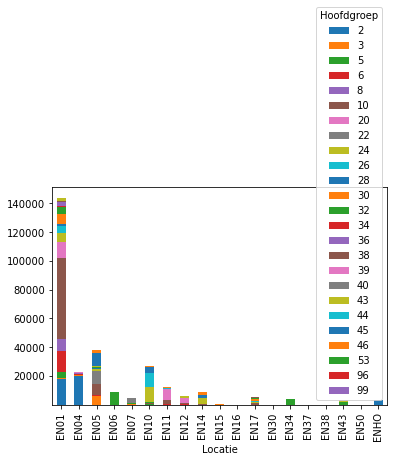

In [18]:
pd.crosstab(df_slim_snap_14_jul['Locatie'], df_slim_snap_14_jul['Hoofdgroep']).plot(kind="bar",stacked=True)

Looks like most of S+Ps SKUs are at EN01. 

### Location filter

SKUs are available across multiple locations/plants in NL. This begs a question, which of these do we predict demand for:
1. Demand for all SKUs at ONE plant (probably EN01, the biggest). 
2. Demand for all SKUs, summed over all EN plants. 
3. Demand for all SKUs, but separately for each plant. 

While we wait for chats with Hans and Johan about this, I'm going to do the first one. This is because it helps limit the large MSEG dataset, and the other two problems would be slightly more complex at this late stage of the project. Also, if we limit the scope to S+P, most of their SKUs look to be at EN01. 

## Filter SKUs in Slim4 snapshot data

In [24]:
number_of_skus_in_slim_snap = df_slim_snap_14_jul['Artikel Code'].nunique()
print (f'Number of unique SKUs in Slim4 snapshot, before filtering = {number_of_skus_in_slim_snap}')

Voorraadsoort_filter = ['Klantspecifieke Voorraad', 'Klantgebonden Voorraad']
df_slim_snap_14_jul_filtered = df_slim_snap_14_jul[~df_slim_snap_14_jul['Voorraadsoort naam'].isin(Voorraadsoort_filter)]
number_of_skus_in_slim_snap = df_slim_snap_14_jul_filtered['Artikel Code'].nunique()
print (f'Number of unique SKUs in Slim4 snapshot, after Voorraadsoort filtering = {number_of_skus_in_slim_snap}')

planningsprofiel_filter = ['VPFZ', 'VPLZ', 'VPVZ']
df_slim_snap_14_jul_filtered = df_slim_snap_14_jul_filtered[~df_slim_snap_14_jul_filtered['Planningsprofiel'].isin(planningsprofiel_filter)]
number_of_skus_in_slim_snap = df_slim_snap_14_jul_filtered['Artikel Code'].nunique()
print (f'Number of unique SKUs in Slim4 snapshot, after Voorraadsoort + planningsprofiel filtering = {number_of_skus_in_slim_snap}')

locatie_filter = ['EN01']
df_slim_snap_14_jul_filtered = df_slim_snap_14_jul_filtered[df_slim_snap_14_jul_filtered['Locatie'].isin(locatie_filter)]
number_of_skus_in_slim_snap = df_slim_snap_14_jul_filtered['Artikel Code'].nunique()
print (f'Number of unique SKUs in Slim4 snapshot, after Voorraadsoort, planningsprofiel + locatie filtering = {number_of_skus_in_slim_snap}')

BU_filter = ['10']
df_slim_snap_14_jul_filtered['Hoofdgroep'] = df_slim_snap_14_jul_filtered['Hoofdgroep'].astype(str)
df_slim_snap_14_jul_filtered = df_slim_snap_14_jul_filtered[df_slim_snap_14_jul_filtered['Hoofdgroep'].isin(BU_filter)]
number_of_skus_in_slim_snap = df_slim_snap_14_jul_filtered['Artikel Code'].nunique()
print (f'Number of unique SKUs in Slim4 snapshot, after Voorraadsoort, planningsprofiel, locatie + BU filtering = {number_of_skus_in_slim_snap}')


Number of unique SKUs in Slim4 snapshot, before filtering = 213003
Number of unique SKUs in Slim4 snapshot, after Voorraadsoort filtering = 172240
Number of unique SKUs in Slim4 snapshot, after Voorraadsoort + planningsprofiel filtering = 172000
Number of unique SKUs in Slim4 snapshot, after Voorraadsoort, planningsprofiel + locatie filtering = 112363
Number of unique SKUs in Slim4 snapshot, after Voorraadsoort, planningsprofiel, locatie + BU filtering = 39118


If I remove the locatie filter momentarily, the final SKU count only goes up 800 or so. That tells me that only 800 or so SKUs belong to Sealing and Polymer, and are at other locations. So it will be fine to limit the scope to sealing and polymer, and EN01. 

In [25]:
df_slim_snap_14_jul_filtered['Voorraadsoort naam'].value_counts()

Langzaamlopende voorraad    28177
Gangbare voorraad            8408
Exit voorraad                1228
Strategische voorraad         490
Intro voorraad                 63
Name: Voorraadsoort naam, dtype: int64

In [26]:
df_slim_snap_14_jul_filtered['Planningsprofiel'].value_counts()

VPD1    26284
VV1      8961
VPD2     1489
V1Y       590
VPDZ      568
VPDS      219
VV1Z      203
V1YS      155
VPDK      136
VV1S      108
V1YK      107
VV1K      106
V1YZ       86
VPDC       32
V1YC       31
PZP        19
VV1C       13
V1SU        6
IPD         3
VPDF        1
VPD3        1
Name: Planningsprofiel, dtype: int64

In [27]:
df_slim_snap_14_jul_filtered['Locatie'].value_counts()


EN01    39118
Name: Locatie, dtype: int64

In [28]:
df_slim_snap_14_jul_filtered['Hoofdgroep'].value_counts()


10    39118
Name: Hoofdgroep, dtype: int64

## Pass final list of SKUs from Slim snap data to MSEG table

In [29]:
df_slim_snap_14_jul_filtered.head()

,Artikel Code,Locatie,Code,Artikel Omschrijving,Verwervingssoort,Afzet Klasse,Voorraadsoort,Voorraadsoort naam,Leverancier Nr,Leverancier,Productgroep EN,Hoofdgroep,Index,Base UOM,Positietypegroep,Planningsprofiel,Planningskenmerk,Voorraad Artikel,Fysieke Voorraad,Economische voorraad,Besteld,Na te Leveren,Bevestigde Orders,Bestelpunt Slim4 (ex bev. extra),Bestelpunt SAP,BPSLIM4 tov BPSAP,Verschil bestelpuntwaarde,Buffer Voorraad,Forecast (CP),Aantal mnd verbruik,Prijs,Voorraadwaarde,Jaarverbruik,Onafgerond vrbk 12 mnd,Begin IJzer vrd YYYYMMD,Einde IJzer vrd YYYYMMDD,Klant IJzer VRD,IJzeren Voorraad,Opmerking IJzer vrd,Veiligheids Voorraad Overschrijven,ABC Klasse,Orderregels per jaar,Service Level,Bestelkosten,Planner,MOQ,Economische Bestelhoeveelheid,IOQ,Leveranciers MOQ,Berekende EOQ,Resultaat EOQ,Minseriegrt (artstam) SAP,Leveringseenheid verkoop,PP door Slim4 gecreeerd,Inkoopgroep,Levertijd (d),Review tijd (d),ABC Klasse Orderregels,ABC Klasse Verkoop,Levertijd Afwijking (m),Leveranciers Betrouwbaarheid Instelling,Gemid. afzet (forecast),Aantal unieke klanten (1 jaar),Afwaarderingskengetal,Relevante Afzet,Afzet 23,Afzet 22,Afzet 21,Afzet 20,Afzet 19,Afzet 18,Afzet 17,Afzet 16,Afzet 15,Afzet 14,Afzet 13,Afzet 12,Afzet 11,Afzet 10,Afzet 9,Afzet 8,Afzet 7,Afzet 6,Afzet 5,Afzet 4,Afzet 3,Afzet 2,Afzet 1,Afzet 0,ADM,Forecast 1,Forecast 2,Forecast 3,Forecast 4,Forecast 5,Forecast 6,Forecast 7,Forecast 8,Forecast 9,Forecast 10,Forecast 11,Forecast 12,Gekoppelde Artikelen,Gekoppeld Percentage,Art.nr. leverancier,Aankoopwaarde,Goederengroep,Grootste transactie (1 jaar),Leverende vestiging verkoop,Speciale verwerving,Formulespecifieke status,Vestigingspecifieke status,Gevaarlijke stof,Inkoopgroep.1,Voorraad Exceptie,Forecast Exceptie,ABC Klasse Geïmporteerd,Planningsprofiel oud | datum,H:StockDays,H:s4s_DaysOfInventoryOnHand,Klant met hoogste afzet afgelopen jaar,Klant met hoogste afzet afgelopen 3 maanden,Artikelnotitie,Datum Afgehandeld,H:Omloopsnelheid
923,10000000,EN01,10000000,Prof.CR FEST cel-zelfkl zwart 10x2 L=20,F,1,3.0,Gangbare voorraad,0002003870,W Koepp GmbH & Co.KG,22 Vormwerk,10,10510,M,NORM,VV1,V1,0,2820,4040,1800,0,580.0,2537,2538.0,99,-0.12,1142,1395.0,12,0.12,338.399994,9580,9580.0,NaN,NaN,NaN,0,NaN,0,A,94,98.0,7.0,002,1800,0,1800,1,1845,1800,1800.0,20.0,VV1,N02,51,7,A,B,0.0,0,738.06,46,0.0,12,980,640,1100,960,1520,720,1980,560,200,560,660,160,660,220,540,960,560,2140,920,620,1940,320,280,420,240,734.17,731.24,729.30,728.32,728.32,728.32,728.32,728.32,728.32,728.32,728.32,728.32,NaN,0,58350,0.113,10510100,1600,EN01,NaN,Z1,NaN,NaN,N02,13,1,C,| 20191016,116.384491,85784.398438,1017701 | VDL ETG Eindhoven BV | 1600 | 17 %,1015170 | Contour Covering Technology BV | 340...,NaN,NaN,3.397163
924,10000001,EN01,10000001,Prof.CR FEST cel-zelfkl zwart 10x3 L=20,F,1,3.0,Gangbare voorraad,0002003870,W Koepp GmbH & Co.KG,22 Vormwerk,10,10510,M,NORM,VV1,V1,0,4340,6820,3600,100,1020.0,3523,3526.0,99,-0.45,1423,2100.0,12,0.15,651.000000,14320,14320.0,NaN,NaN,NaN,0,NaN,0,A,100,98.0,7.0,002,4000,0,1800,4000,2016,0,4000.0,20.0,VV1,N02,51,7,A,B,0.0,0,1131.28,33,0.0,12,2080,720,1940,1900,1180,140,1920,1560,1900,1920,2340,1220,680,660,1040,1540,2960,40,1440,1100,2200,720,1740,200,0,1112.62,1098.63,1089.30,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,NaN,0,58184,0.138,10510100,1000,EN01,NaN,Z1,NaN,NaN,N02,13,1,C,| 20191016,118.191299,132022.796875,1019259 | ERIKS Deutschland GmbH | 7300 | 51 %,1019259 | ERIKS Deutschland GmbH | 1000 | 38 %,NaN,NaN,3.299539
925,10000002,EN01,10000002,Prof.CR FEST cel-zelfkl zwart 10x4 L=20,F,1,3.0,Gangbare voorraad,0002003870,W Koepp GmbH & Co.KG,22 Vormwerk,10,10510,M,NORM,VV1,V1,0,2040,3780,1800,0,60.0,2987,2970.0,100,3.06,271,2716.0,12,0.18,367.200012,8501,8501.0,NaN,NaN,NaN,0,NaN,0,A,81,98.0,7.0,002,2200,0,100,1800,2155,2200,2200.0,20.0,VV1,N02,51,7,A,B,0.0,0,1261.97,40,0.0,12,620,180,320,460,880,400,480,800,480,300,1060,700,480,160,160,400,220,520,860,1280,1261,880,1220,106

### Create list of unique SKUs in filtered Slim snap

In [30]:
unique_skus_in_filtered_slim_snap = df_slim_snap_14_jul_filtered['Artikel Code'].unique().tolist()

In [31]:
print (len(unique_skus_in_filtered_slim_snap))
print (unique_skus_in_filtered_slim_snap)

39118
['10000000', '10000001', '10000002', '10000003', '10000004', '10000005', '10000006', '10000007', '10000009', '10000010', '10000011', '10000012', '10000013', '10000014', '10000015', '10000016', '10000017', '10000018', '10000019', '10000020', '10000021', '10000022', '10000023', '10000024', '10000025', '10000026', '10000027', '10000028', '10000030', '10000031', '10000032', '10000033', '10000034', '10000035', '10000036', '10000037', '10000038', '10000039', '10000040', '10000041', '10000042', '10000043', '10000044', '10000045', '10000046', '10000047', '10000048', '10000049', '10000051', '10000052', '10000053', '10000055', '10000056', '10000058', '10000059', '10000060', '10000061', '10000062', '10000063', '10000064', '10000066', '10000068', '10000069', '10000070', '10000071', '10000072', '10000073', '10000074', '10000075', '10000076', '10000077', '10000078', '10000079', '10000080', '10000081', '10000083', '10000084', '10000085', '10000087', '10000089', '10000090', '10000091', '10000092

### Setup MSEG table

In [32]:
df_MSEG = pd.read_csv(r"Data\MSEG_Data\MSEG_21_Jan_2021.csv", encoding = "ISO-8859-1", sep = ';')
df_MSEG['MaterialNo'] = df_MSEG['MaterialNo'].str[13:]
df_MSEG.head()

,MaterialNo,MaterialDocumentYear,Plant,InventoryMovementType,PostingDate,Quantity,BaseUnitOfMeasure,IsRecordDeleted
0,23087411,2017,EN01,601,20170104,5.0,ST,True
1,23410142,2017,EN01,601,20170104,1.0,ST,True
2,23114681,2017,EN01,601,20170104,1.0,ST,True
3,23114683,2017,EN01,601,20170104,1.0,ST,True
4,23114462,2017,EN01,601,20170104,2.0,ST,True


### Filter MSEG table 

In [33]:
print (f'Number of unique SKUs in MSEG before filtering on Slim snap SKUs = {df_MSEG.MaterialNo.nunique()}')
print (f'Number of rows in MSEG before filtering on Slim snap SKUs = {len(df_MSEG)}')

df_MSEG_filtered = df_MSEG[df_MSEG.MaterialNo.isin(unique_skus_in_filtered_slim_snap)]
print (f'Number of unique SKUs in MSEG after filtering on Slim snap SKUs = {df_MSEG_filtered.MaterialNo.nunique()}')
print (f'Number of rows in MSEG after filtering on Slim snap SKUs = {len(df_MSEG_filtered)}')

#df_MSEG_filtered.to_pickle(r'pickles/MSEG_data_filtered_day_level.pkl')


Number of unique SKUs in MSEG before filtering on Slim snap SKUs = 521837
Number of rows in MSEG before filtering on Slim snap SKUs = 7766186
Number of unique SKUs in MSEG after filtering on Slim snap SKUs = 23849
Number of rows in MSEG after filtering on Slim snap SKUs = 1078649


### Save as pickle (for use in other notebooks, like notebook 5)

In [326]:
df_MSEG_filtered['PostingDate'] = df_MSEG_filtered['PostingDate'].astype(str)
df_MSEG_filtered['PostingDate'] = pd.to_datetime(df_MSEG_filtered['PostingDate'], format="%Y%m%d")
#df_MSEG_filtered.to_pickle(r'pickles/MSEG_data_filtered_day_level.pkl')


<ipython-input-326-ea6220ea73c4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MSEG_filtered['PostingDate'] = df_MSEG_filtered['PostingDate'].astype(str)
<ipython-input-326-ea6220ea73c4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MSEG_filtered['PostingDate'] = pd.to_datetime(df_MSEG_filtered['PostingDate'], format="%Y%m%d")


In [327]:
df_MSEG_filtered.head()

,MaterialNo,MaterialDocumentYear,Plant,InventoryMovementType,PostingDate,Quantity,BaseUnitOfMeasure,IsRecordDeleted
2,23114681,2017,EN01,601,2017-01-04,1.0,ST,True
4,23114462,2017,EN01,601,2017-01-04,2.0,ST,True
5,11020140,2017,EN01,601,2017-01-04,5.0,ST,True
6,12083835,2017,EN01,601,2017-01-04,10.0,ST,True
7,12461522,2017,EN01,601,2017-01-04,10.0,ST,True


Okay, so it looks like in MSEG, when we feed in our list of 39k SKUs from the filtered Slim snapshot data, around 23k have entries in the MSEG table. Check with Hans if these numbers roughly make sense.

# Rerun classification code on filtered MSEG data, compare classification results to Johan's data. 

This section is going to look a little different to the other classification sections. Previously, we had a dataset from Johan, extracted via SAP, of consumption and orders per month, from March 18 to March 19 roughly. We then downloaded data from TED, in an attempt to find the same data, but for a longer timeframe. We succeeded in this, as 78% of the monthly datapoints matched in number of orders and order quantity. 

Then, when we took the delivery dates, and delivery OQs, this matching dropped to around 51% of monthly data points. We took delivery dates because we learned that Slim4 uses delivery dates rather than orderline dates very late into the project. We (mainly Hans) then sourced the exact SAP table that Slim4 was using, to calculate its monthly demand, and exported the same data for all SKUs in NL, for a certain set of document types. 

Now, there is much less of a need to compare Johan's dataset to this dataset. Instead, we will calculate the classifications for each SKU, for the above dataset, over two timeframes, the entire timeframe and the last year. We will then compare the classification in each group, and look at the amount of SKUs that change groups. We will probably conclude that the longer dataset changes the SKU classification dramamtically. 

But then, we will also have classification replicated, for when we come to divide up our SKUs, and examine the prediction performance for each group. 



## Group data by months

In [328]:
#df_MSEG_filtered = pd.read_csv(r'pickles/MSEG_data_filtered_day_level.pkl')

In [329]:
# Note, can only run this cell once after importing MSEG data
df_MSEG_filtered_grouped = df_MSEG_filtered.groupby([pd.Grouper(key='PostingDate', freq='MS'), 'MaterialNo'])
df_MSEG_filtered_grouped_plus_counts = df_MSEG_filtered_grouped.size().to_frame(name='Number_of_orders')
df_MSEG_filtered_grouped_plus_counts = df_MSEG_filtered_grouped_plus_counts.join(df_MSEG_filtered_grouped.agg({'Quantity': 'sum'}).rename(columns={'Quantity': 'OQ'})).reset_index()
df_MSEG_filtered_grouped_plus_counts.head(n = 100)


,PostingDate,MaterialNo,Number_of_orders,OQ
0,2017-01-01,00605239,2,24.0
1,2017-01-01,00605263,1,18.0
2,2017-01-01,00605301,7,91.0
3,2017-01-01,00605328,2,24.0
4,2017-01-01,00605344,1,1.0
...,...,...,...,...
95,2017-01-01,00765880,2,18.0
96,2017-01-01,00766003,3,536.0
97,2017-01-01,00766011,1,20.0
98,2017-01-01,00766089,1,1500.0


Check this quickly:

In [330]:
df_MSEG_filtered_10000002 = df_MSEG_filtered[df_MSEG_filtered['MaterialNo'] == '10000002']
df_MSEG_filtered_10000002 = df_MSEG_filtered_10000002[df_MSEG_filtered_10000002['PostingDate'] < '2017-02-01']
df_MSEG_filtered_10000002.head(50)

,MaterialNo,MaterialDocumentYear,Plant,InventoryMovementType,PostingDate,Quantity,BaseUnitOfMeasure,IsRecordDeleted
106007,10000002,2017,EN01,601,2017-01-06,60.0,M,True
130673,10000002,2017,EN01,601,2017-01-02,0.2,M,True
135367,10000002,2017,EN01,601,2017-01-02,20.0,M,True
339115,10000002,2017,EN01,601,2017-01-13,20.0,M,True
498563,10000002,2017,EN01,601,2017-01-18,100.0,M,True


Matches! But note, we have fractions of units ordered. May need to deal with that later.

Here, we skip all the code to join on Johan's data and compare (originally, Notebook 1), as we don't need to do it now!
We can skip right to the ADI and CV_2 code in Notebook 2. 

### Save pkl of month level filtered MSEG data

In [331]:
#df_MSEG_filtered_grouped_plus_counts.to_pickle(r'pickles/MSEG_data_filtered_month_level.pkl')

## Analyse number of data points per SKU

In [332]:
import os.path as path
import matplotlib as mpl
print("Your style sheets are located at: {}".format(path.join(mpl.__path__[0], 'mpl-data', 'stylelib')))

timestr = time.strftime("%Y%m%d-%H%M%S")
width = 386.67296
tex_fonts = {
# Use LaTeX to write all text
"text.usetex": False,
"font.family": "serif",
"font.serif"  : "cm",
# Use 10pt font in plots, to match 10pt font in document
"axes.labelsize": 10,
"font.size": 10,
# Make the legend/label fonts a little smaller
"legend.fontsize": 8,
"xtick.labelsize": 8,
"ytick.labelsize": 8
}

#plt.figure(figsize = Plotting.set_size(width))
#plt.plot(BH_series, linewidth = 0.5, color = 'k')

#plt.xlabel('Timestep')
#plt.ylabel(r'$x_t $')

#plt.title(f'Example Brock-Hommes Time Series')
#plt.savefig(data_print_filename, format = 'pdf', bbox_inches='tight')  

Your style sheets are located at: C:\Users\shahe\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib


1     17100
2     10254
3      7835
4      6434
5      5305
6      4677
7      4190
8      3758
9      3323
10     3092
11     2890
49     2800
12     2671
13     2453
14     2329
15     2222
16     2050
17     1907
18     1816
19     1741
20     1650
21     1524
22     1511
23     1427
24     1372
48     1294
25     1255
26     1236
27     1196
28     1106
29     1066
47      990
31      970
30      966
46      915
33      913
32      899
34      857
45      833
44      832
43      819
39      815
36      812
35      798
37      775
38      774
41      773
40      770
42      743
Name: Number_of_orders, dtype: int64

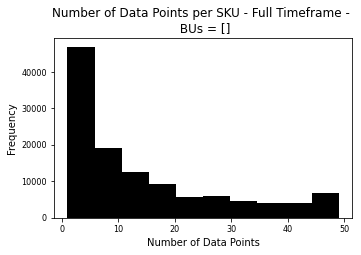

In [333]:
mpl.rcParams.update(tex_fonts)
timestr = time.strftime("%Y%m%d-%H%M%S")
data_print_filename = r'plots\n_data_points_full_timeframe' + timestr + r'.pdf'
df_MSEG_filtered_grouped_plus_counts.groupby('MaterialNo')['Number_of_orders'].count().plot(kind = 'hist', figsize = Plotting_ED.set_size(width), color = 'k')
plt.xlabel('Number of Data Points')
plt.title(f'Number of Data Points per SKU - Full Timeframe - \n BUs = {str(BU_filter)}')
plt.savefig(data_print_filename, format = 'pdf', bbox_inches='tight')  

df_MSEG_filtered_grouped_plus_counts.groupby('MaterialNo')['Number_of_orders'].count().value_counts()

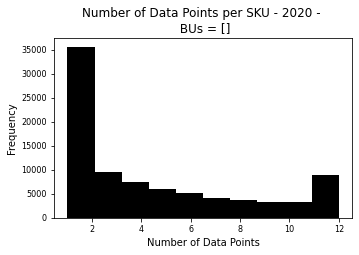

In [334]:
df_MSEG_filtered_grouped_plus_counts_2020 = df_MSEG_filtered_grouped_plus_counts[
    (df_MSEG_filtered_grouped_plus_counts['PostingDate'] < '2021-01-01') & 
    (df_MSEG_filtered_grouped_plus_counts['PostingDate'] > '2019-12-31')]

timestr = time.strftime("%Y%m%d-%H%M%S")
data_print_filename = r'plots\n_data_points_2020' + timestr + r'.pdf'
df_MSEG_filtered_grouped_plus_counts_2020.groupby('MaterialNo')['Number_of_orders'].count().plot(kind = 'hist', figsize = Plotting_ED.set_size(width), color = 'k')
plt.xlabel('Number of Data Points')
plt.title(f'Number of Data Points per SKU - 2020 - \n BUs = {str(BU_filter)}')
plt.savefig(data_print_filename, format = 'pdf', bbox_inches='tight') 

Very interesting, when we compare these figures to those in 4.1 of Notebook 2. Looks like more SKUs with low numbers of datapoints. Also, same trend of increasing the number of datapoints available. \But we won't analyse much more than this. 

## Order quantity per SKU

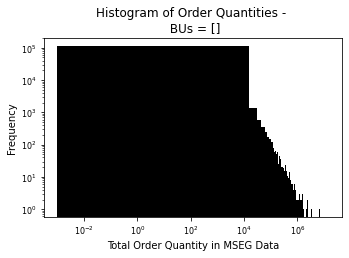

In [335]:
timestr = time.strftime("%Y%m%d-%H%M%S")
data_print_filename = r'plots\OQ_plot_' + timestr + r'.pdf'
df_MSEG_filtered_grouped_plus_counts.groupby(['MaterialNo']).OQ.sum().plot.hist(logx = True, logy = True, bins = 1000, color = 'k', figsize = Plotting_ED.set_size(width))
plt.xlabel('Total Order Quantity in MSEG Data')
plt.ylabel('Frequency')
plt.title(f'Histogram of Order Quantities - \n BUs = {str(BU_filter)}')
plt.savefig(data_print_filename, format = 'pdf', bbox_inches='tight') 



## ADI 

In [336]:
ADI_df = df_MSEG_filtered_grouped_plus_counts.groupby('MaterialNo')['PostingDate'].apply(lambda x: x.diff().mean()).dt.days.to_frame(name = 'ADI')
ADI_df_2020 = df_MSEG_filtered_grouped_plus_counts_2020.groupby('MaterialNo')['PostingDate'].apply(lambda x: x.diff().mean()).dt.days.to_frame(name = 'ADI_2020')

ADI_df['ADI'] = ADI_df['ADI']/30.0
ADI_df_2020['ADI_2020'] = ADI_df_2020['ADI_2020']/30.0

ADI_df.head()

,ADI
MaterialNo,
00601349,3.033333
00605239,1.400000
00605255,1.466667
00605263,1.600000
00605271,19.266667


In [337]:
ADI_df_2020.head()

,ADI_2020
MaterialNo,
00601349,8.166667
00605239,2.766667
00605255,1.366667
00605263,1.400000
00605271,NaN


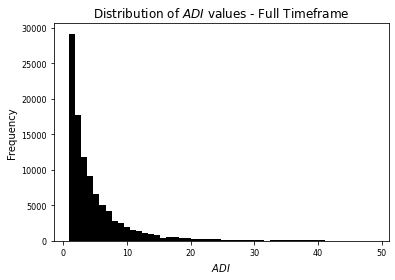

In [338]:
timestr = time.strftime("%Y%m%d-%H%M%S")
mpl.rcParams.update(tex_fonts)
data_print_filename = r'plots\ADI_' + timestr + r'.pdf'
ADI_df.hist(column = 'ADI', bins = 50, color = 'k', grid = False)
plt.xlabel('$ADI$')
plt.ylabel('Frequency')
plt.title('Distribution of $ADI$ values - Full Timeframe')
mpl.rcParams["axes.grid"] = False

plt.savefig(data_print_filename, format = 'pdf', bbox_inches='tight') 




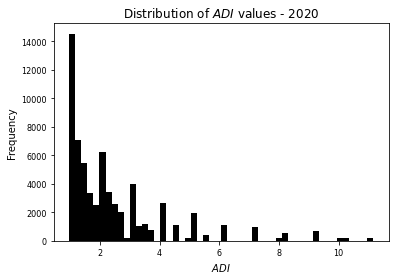

In [339]:
timestr = time.strftime("%Y%m%d-%H%M%S")
mpl.rcParams.update(tex_fonts)
data_print_filename = r'plots\ADI_2020' + timestr + r'.pdf'
ADI_df_2020.hist(column = 'ADI_2020', bins = 50, color = 'k', grid = False)
plt.xlabel('$ADI$')
plt.ylabel('Frequency')
plt.title('Distribution of $ADI$ values - 2020')
mpl.rcParams["axes.grid"] = False

plt.savefig(data_print_filename, format = 'pdf', bbox_inches='tight') 


ADI plot incredibly similar to ADI from SQL, in 4.2.1 of Notebook 2. The shorter dataset has a much noisier trend.

In [340]:
df_MSEG_filtered_grouped_plus_counts_plus_ADI = pd.merge(df_MSEG_filtered_grouped_plus_counts,ADI_df,on='MaterialNo',how='left')
df_MSEG_filtered_grouped_plus_counts_plus_ADI.head()

,PostingDate,MaterialNo,Number_of_orders,OQ,ADI
0,2017-01-01,00605239,2,24.0,1.400000
1,2017-01-01,00605263,1,18.0,1.600000
2,2017-01-01,00605301,7,91.0,1.100000
3,2017-01-01,00605328,2,24.0,1.133333
4,2017-01-01,00605344,1,1.0,7.066667


In [341]:
df_MSEG_filtered_grouped_plus_counts_2020_plus_ADI = pd.merge(df_MSEG_filtered_grouped_plus_counts_2020,ADI_df_2020,on='MaterialNo',how='left')
df_MSEG_filtered_grouped_plus_counts_2020_plus_ADI.head()

,PostingDate,MaterialNo,Number_of_orders,OQ,ADI_2020
0,2020-01-01,00605239,2,41.0,2.766667
1,2020-01-01,00605255,2,11.0,1.366667
2,2020-01-01,00605301,1,10.0,1.233333
3,2020-01-01,00605328,1,3.0,1.233333
4,2020-01-01,00606499,5,180.0,3.700000


## CV_2

In [342]:
CV_2_df = df_MSEG_filtered_grouped_plus_counts_plus_ADI.groupby('MaterialNo')['OQ'].apply(lambda x: (x.std()/x.mean())**2).to_frame(name = 'CV_2')
CV_2_df_2020 = df_MSEG_filtered_grouped_plus_counts_2020_plus_ADI.groupby('MaterialNo')['OQ'].apply(lambda x: (x.std()/x.mean())**2).to_frame(name = 'CV_2_2020')

CV_2_df.head()

,CV_2
MaterialNo,
00601349,0.329425
00605239,1.027156
00605255,0.851016
00605263,0.884808
00605271,0.222222


In [343]:
CV_2_df_2020.head()

,CV_2_2020
MaterialNo,
00601349,0.222222
00605239,0.445294
00605255,0.704591
00605263,0.598099
00605271,NaN


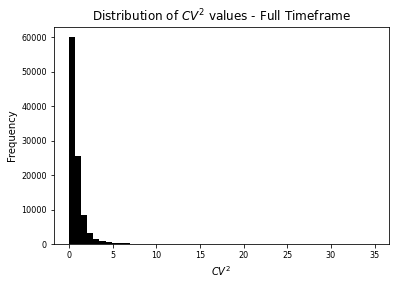

In [344]:
timestr = time.strftime("%Y%m%d-%H%M%S")
mpl.rcParams.update(tex_fonts)
data_print_filename = r'plots\CV_2_' + timestr + r'.pdf'
CV_2_df.hist(column = 'CV_2', bins = 50, color = 'k', grid = False)
plt.xlabel('$CV^2$')
plt.ylabel('Frequency')
plt.title('Distribution of $CV^2$ values - Full Timeframe')
mpl.rcParams["axes.grid"] = False
plt.savefig(data_print_filename, format = 'pdf', bbox_inches='tight') 




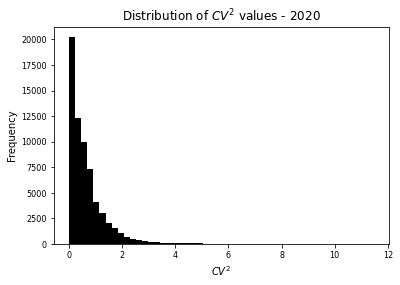

In [345]:
timestr = time.strftime("%Y%m%d-%H%M%S")
mpl.rcParams.update(tex_fonts)
data_print_filename = r'plots\CV_2_2020' + timestr + r'.pdf'
CV_2_df_2020.hist(column = 'CV_2_2020', bins = 50, color = 'k', grid = False)
plt.xlabel('$CV^2$')
plt.ylabel('Frequency')
plt.title('Distribution of $CV^2$ values - 2020')
mpl.rcParams["axes.grid"] = False
plt.savefig(data_print_filename, format = 'pdf', bbox_inches='tight') 




Slightly different trend for CV_2 in just 2020 also.

In [346]:
df_MSEG_filtered_grouped_plus_counts_plus_ADI_and_CV_2 = pd.merge(df_MSEG_filtered_grouped_plus_counts_plus_ADI,CV_2_df,on='MaterialNo',how='left')
df_MSEG_filtered_grouped_plus_counts_plus_ADI_and_CV_2.head()

,PostingDate,MaterialNo,Number_of_orders,OQ,ADI,CV_2
0,2017-01-01,00605239,2,24.0,1.400000,1.027156
1,2017-01-01,00605263,1,18.0,1.600000,0.884808
2,2017-01-01,00605301,7,91.0,1.100000,0.677372
3,2017-01-01,00605328,2,24.0,1.133333,0.899459
4,2017-01-01,00605344,1,1.0,7.066667,1.200000


In [347]:
df_MSEG_filtered_grouped_plus_counts_2020_plus_ADI_and_CV_2 = pd.merge(df_MSEG_filtered_grouped_plus_counts_2020_plus_ADI,CV_2_df_2020,on='MaterialNo',how='left')
df_MSEG_filtered_grouped_plus_counts_2020_plus_ADI_and_CV_2.head()

,PostingDate,MaterialNo,Number_of_orders,OQ,ADI_2020,CV_2_2020
0,2020-01-01,00605239,2,41.0,2.766667,0.445294
1,2020-01-01,00605255,2,11.0,1.366667,0.704591
2,2020-01-01,00605301,1,10.0,1.233333,0.974883
3,2020-01-01,00605328,1,3.0,1.233333,0.898534
4,2020-01-01,00606499,5,180.0,3.700000,0.324504


In [348]:
print (max(df_MSEG_filtered_grouped_plus_counts_plus_ADI_and_CV_2.groupby('MaterialNo')['ADI'].nunique()))
print (max(df_MSEG_filtered_grouped_plus_counts_plus_ADI_and_CV_2.groupby('MaterialNo')['CV_2'].nunique()))
print (max(df_MSEG_filtered_grouped_plus_counts_2020_plus_ADI_and_CV_2.groupby('MaterialNo')['ADI_2020'].nunique()))
print (max(df_MSEG_filtered_grouped_plus_counts_2020_plus_ADI_and_CV_2.groupby('MaterialNo')['CV_2_2020'].nunique()))

1
1
1
1


Okay good, so each SKU has a unique ADI and CV_2 value appended to the monthly demand dataframe. 

# ADI vs CV_2

Name getting bit long, shorten:

In [349]:
df_adi_cv_results = df_MSEG_filtered_grouped_plus_counts_plus_ADI_and_CV_2.copy()
df_adi_cv_results_2020 = df_MSEG_filtered_grouped_plus_counts_2020_plus_ADI_and_CV_2.copy()

conditions = [
    (df_adi_cv_results['ADI'] < 1.32) &
    (df_adi_cv_results['CV_2'] < 0.49),
    (df_adi_cv_results['ADI'] >= 1.32) &
    (df_adi_cv_results['CV_2'] < 0.49),
    (df_adi_cv_results['ADI'] < 1.32) &
    (df_adi_cv_results['CV_2'] >= 0.49),
    (df_adi_cv_results['ADI'] >= 1.32) &
    (df_adi_cv_results['CV_2'] >= 0.49)]

conditions_2020 = [
    (df_adi_cv_results_2020['ADI_2020'] < 1.32) &
    (df_adi_cv_results_2020['CV_2_2020'] < 0.49),
    (df_adi_cv_results_2020['ADI_2020'] >= 1.32) &
    (df_adi_cv_results_2020['CV_2_2020'] < 0.49),
    (df_adi_cv_results_2020['ADI_2020'] < 1.32) &
    (df_adi_cv_results_2020['CV_2_2020'] >= 0.49),
    (df_adi_cv_results_2020['ADI_2020'] >= 1.32) &
    (df_adi_cv_results_2020['CV_2_2020'] >= 0.49)]

choices = ['Smooth', 'Intermittent', 'Erratic', 'Lumpy']

df_adi_cv_results['Demand_pattern'] = np.select(conditions, choices, default= -1)
df_adi_cv_results_2020['Demand_pattern_2020'] = np.select(conditions_2020, choices, default= -1)

df_adi_cv_results.head(n = 5)

,PostingDate,MaterialNo,Number_of_orders,OQ,ADI,CV_2,Demand_pattern
0,2017-01-01,00605239,2,24.0,1.400000,1.027156,Lumpy
1,2017-01-01,00605263,1,18.0,1.600000,0.884808,Lumpy
2,2017-01-01,00605301,7,91.0,1.100000,0.677372,Erratic
3,2017-01-01,00605328,2,24.0,1.133333,0.899459,Erratic
4,2017-01-01,00605344,1,1.0,7.066667,1.200000,Lumpy


In [350]:
df_adi_cv_results_2020.head(n = 5)

,PostingDate,MaterialNo,Number_of_orders,OQ,ADI_2020,CV_2_2020,Demand_pattern_2020
0,2020-01-01,00605239,2,41.0,2.766667,0.445294,Intermittent
1,2020-01-01,00605255,2,11.0,1.366667,0.704591,Lumpy
2,2020-01-01,00605301,1,10.0,1.233333,0.974883,Erratic
3,2020-01-01,00605328,1,3.0,1.233333,0.898534,Erratic
4,2020-01-01,00606499,5,180.0,3.700000,0.324504,Intermittent


In [351]:
print (len(df_adi_cv_results_2020.groupby(['MaterialNo'])))

87271


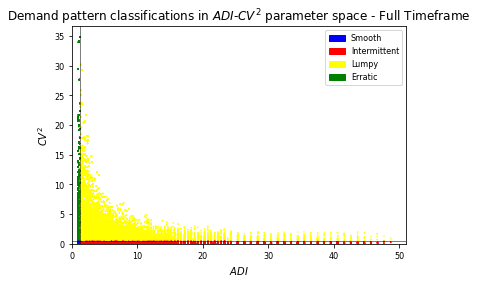

In [352]:
colors = {'Smooth':'blue', 'Intermittent':'red', 'Lumpy':'yellow', 'Erratic':'green', '-1': 'white'}
colors_legend = {'Smooth':'blue', 'Intermittent':'red', 'Lumpy':'yellow', 'Erratic':'green'}

timestr = time.strftime("%Y-%m-%d-%H-%M-%S")
mpl.rcParams.update(tex_fonts)
data_print_filename = r'plots\ADI_vs_CV_2_' + timestr + r'.pdf'

df_adi_cv_results.plot.scatter(x = 'ADI', y = 'CV_2', s = 0.1, rasterized=True, c=df_adi_cv_results['Demand_pattern'].apply(lambda x: colors[x]))

plt.xlabel('$ADI$')
plt.ylabel('$CV^2$')
plt.title('Demand pattern classifications in $ADI$-$CV^2$ parameter space - Full Timeframe')
mpl.rcParams["axes.grid"] = False
plt.axvline(1.32, color = 'k', linewidth = 0.5)
plt.axhline(0.49, color = 'k', linewidth = 0.5)
leg_el = [mpatches.Patch(facecolor = value, edgecolor = value, label = key, alpha = 1) for key, value in colors_legend.items()]
plt.legend(handles = leg_el)
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.savefig(data_print_filename, format = 'pdf', bbox_inches='tight') 


#fig, ax = plt.subplots(figsize=(14,12))


#ax.scatter(df['carat'], df['price'], c=df['color'].apply(lambda x: colors[x]))



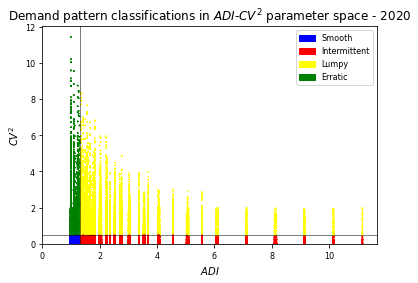

In [353]:
colors = {'Smooth':'blue', 'Intermittent':'red', 'Lumpy':'yellow', 'Erratic':'green', '-1': 'white'}
colors_legend = {'Smooth':'blue', 'Intermittent':'red', 'Lumpy':'yellow', 'Erratic':'green'}

timestr = time.strftime("%Y-%m-%d-%H-%M-%S")
mpl.rcParams.update(tex_fonts)
data_print_filename = r'plots\ADI_vs_CV_2_2020_' + timestr + r'.pdf'

df_adi_cv_results_2020.plot.scatter(x = 'ADI_2020', y = 'CV_2_2020', s = 0.1, rasterized=True, c=df_adi_cv_results_2020['Demand_pattern_2020'].apply(lambda x: colors[x]))

plt.xlabel('$ADI$')
plt.ylabel('$CV^2$')
plt.title('Demand pattern classifications in $ADI$-$CV^2$ parameter space - 2020')
mpl.rcParams["axes.grid"] = False
plt.axvline(1.32, color = 'k', linewidth = 0.5)
plt.axhline(0.49, color = 'k', linewidth = 0.5)
leg_el = [mpatches.Patch(facecolor = value, edgecolor = value, label = key, alpha = 1) for key, value in colors_legend.items()]
plt.legend(handles = leg_el)
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.savefig(data_print_filename, format = 'pdf', bbox_inches='tight')






#df_adi_cv_results_2020.plot.scatter(x = 'ADI_2020', y = 'CV_2_2020', s = 0.5, ax = ax, c=df_adi_cv_results_2020['Demand_pattern_2020'].apply(lambda x: colors[x]))
#ax.axvline(1.32*30, color = 'k')
#ax.axhline(0.49, color = 'k')
#leg_el = [mpatches.Patch(facecolor = value, edgecolor = value, label = key, alpha = 1) for key, value in colors_legend.items()]
#ax.legend(handles = leg_el)
#ax.set_ylim(ymin=0)
#ax.set_xlim(xmin=0)
#ax.set_title('Demand pattern classifications in ADI-CV_2 parameter space - 2020 MSEG data')

Looks similar to previous plots in part 6 of notebook 2. Good. 

118738
Lumpy           45039
Intermittent    40722
-1              17100
Erratic         11405
Smooth           4472
Name: Demand_pattern, dtype: int64


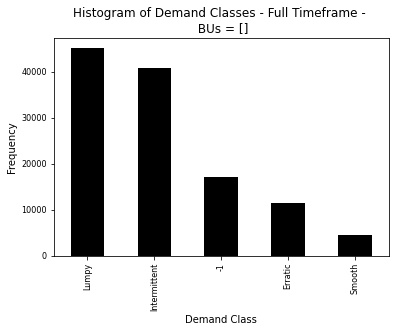

In [354]:
# Quick and dirty - assumes each SKU has been assigned one class!
# Print out matches number of SKUs expected?
df_class_count = df_adi_cv_results.drop_duplicates(subset=['MaterialNo'], keep='first')

timestr = time.strftime("%Y%m%d-%H%M%S")
mpl.rcParams.update(tex_fonts)
data_print_filename = r'plots\Demand_classes_' + timestr + r'.pdf'
df_class_count['Demand_pattern'].value_counts().plot(kind='bar', color = 'k')
plt.xlabel('Demand Class')
plt.ylabel('Frequency')
plt.title(f'Histogram of Demand Classes - Full Timeframe - \n BUs = {str(BU_filter)}')
mpl.rcParams["axes.grid"] = False
plt.savefig(data_print_filename, format = 'pdf', bbox_inches='tight') 


print (len(df_class_count))
print (df_class_count['Demand_pattern'].value_counts())

In [355]:
df_class_count.head()

,PostingDate,MaterialNo,Number_of_orders,OQ,ADI,CV_2,Demand_pattern
0,2017-01-01,00605239,2,24.0,1.400000,1.027156,Lumpy
1,2017-01-01,00605263,1,18.0,1.600000,0.884808,Lumpy
2,2017-01-01,00605301,7,91.0,1.100000,0.677372,Erratic
3,2017-01-01,00605328,2,24.0,1.133333,0.899459,Erratic
4,2017-01-01,00605344,1,1.0,7.066667,1.200000,Lumpy


87271
Intermittent    26046
-1              22337
Lumpy           19973
Erratic         10754
Smooth           8161
Name: Demand_pattern_2020, dtype: int64


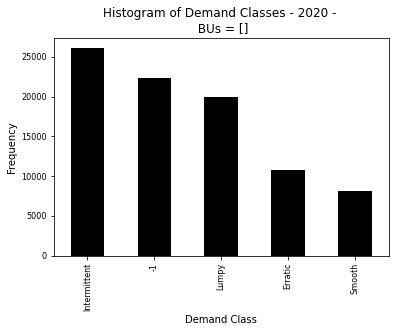

In [356]:
df_class_count_2020 = df_adi_cv_results_2020.drop_duplicates(subset=['MaterialNo'], keep='first')

timestr = time.strftime("%Y%m%d-%H%M%S")
mpl.rcParams.update(tex_fonts)
data_print_filename = r'plots\Demand_classes_2020' + timestr + r'.pdf'
df_class_count_2020['Demand_pattern_2020'].value_counts().plot(kind='bar', color = 'k')
plt.xlabel('Demand Class')
plt.ylabel('Frequency')
plt.title(f'Histogram of Demand Classes - 2020 - \n BUs = {str(BU_filter)}')
mpl.rcParams["axes.grid"] = False
plt.savefig(data_print_filename, format = 'pdf', bbox_inches='tight') 


print (len(df_class_count_2020))
print (df_class_count_2020['Demand_pattern_2020'].value_counts())

In [357]:
df_class_count_2020.head()

,PostingDate,MaterialNo,Number_of_orders,OQ,ADI_2020,CV_2_2020,Demand_pattern_2020
0,2020-01-01,00605239,2,41.0,2.766667,0.445294,Intermittent
1,2020-01-01,00605255,2,11.0,1.366667,0.704591,Lumpy
2,2020-01-01,00605301,1,10.0,1.233333,0.974883,Erratic
3,2020-01-01,00605328,1,3.0,1.233333,0.898534,Erratic
4,2020-01-01,00606499,5,180.0,3.700000,0.324504,Intermittent


Use the df_class_count_2020, which has only one row for each material, to append to the main df_adi_cv_results dataframe

In [358]:
df_adi_cv_results_plus_2020_classes = pd.merge(df_adi_cv_results,df_class_count_2020[['MaterialNo', 'Demand_pattern_2020']],on='MaterialNo',how='left')
df_adi_cv_results_plus_2020_classes.head(50)

,PostingDate,MaterialNo,Number_of_orders,OQ,ADI,CV_2,Demand_pattern,Demand_pattern_2020
0,2017-01-01,00605239,2,24.000,1.400000,1.027156,Lumpy,Intermittent
1,2017-01-01,00605263,1,18.000,1.600000,0.884808,Lumpy,Lumpy
2,2017-01-01,00605301,7,91.000,1.100000,0.677372,Erratic,Erratic
3,2017-01-01,00605328,2,24.000,1.133333,0.899459,Erratic,Erratic
4,2017-01-01,00605344,1,1.000,7.066667,1.200000,Lumpy,NaN
5,2017-01-01,00606499,2,300.000,3.733333,0.453100,Intermittent,Intermittent
6,2017-01-01,00606979,1,21.000,NaN,NaN,-1,NaN
7,2017-01-01,00607304,1,4.000,1.466667,0.917357,Lumpy,Intermittent
8,2017-01-01,00607568,4,26.000,2.266667,0.805870,Lumpy,NaN
9,2017-01-01,00607606,4,32.000,1.066667,1.669363,Erratic,Erratic


In [359]:
df_adi_cv_results_plus_2020_classes['Demand_pattern_2020'].value_counts()

Intermittent    404369
Lumpy           402565
Erratic         391430
Smooth          248505
-1              115739
Name: Demand_pattern_2020, dtype: int64

In [360]:
df_adi_cv_results_plus_2020_classes['Demand_pattern_2020'].isna().sum()

98442

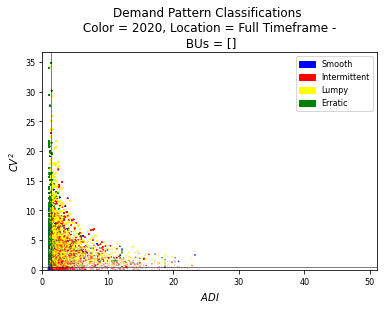

In [361]:
import matplotlib.patches as mpatches
df_adi_cv_results_plus_2020_classes['Demand_pattern_2020'] = df_adi_cv_results_plus_2020_classes['Demand_pattern_2020'].fillna('-1')

colors = {'Smooth':'blue', 'Intermittent':'red', 'Lumpy':'yellow', 'Erratic':'green', '-1': 'white'}
colors_legend = {'Smooth':'blue', 'Intermittent':'red', 'Lumpy':'yellow', 'Erratic':'green'}

timestr = time.strftime("%Y-%m-%d-%H-%M-%S")
mpl.rcParams.update(tex_fonts)
data_print_filename = r'plots\ADI_vs_CV_2_2020_timeframe_comparison_' + timestr + r'.pdf'

df_adi_cv_results_plus_2020_classes.plot.scatter(x = 'ADI', y = 'CV_2', s = 0.1, rasterized=True, c=df_adi_cv_results_plus_2020_classes['Demand_pattern_2020'].apply(lambda x: colors[x]))

plt.xlabel('$ADI$')
plt.ylabel('$CV^2$')
plt.title(f'Demand Pattern Classifications \n Color = 2020, Location = Full Timeframe - \n BUs = {str(BU_filter)}')
mpl.rcParams["axes.grid"] = False
plt.axvline(1.32, color = 'k', linewidth = 0.5)
plt.axhline(0.49, color = 'k', linewidth = 0.5)
leg_el = [mpatches.Patch(facecolor = value, edgecolor = value, label = key, alpha = 1) for key, value in colors_legend.items()]
plt.legend(handles = leg_el)
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.savefig(data_print_filename, format = 'pdf', bbox_inches='tight')



# This line needs to be included, as the Demand_pattern_2020 column now has nans. 

#ax.scatter(df['carat'], df['price'], c=df['color'].apply(lambda x: colors[x]))





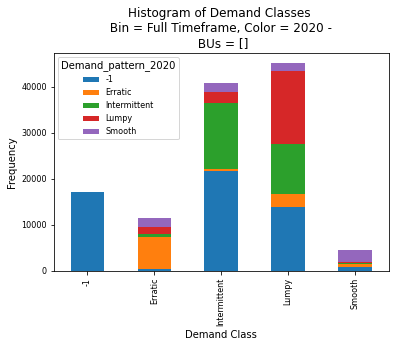

In [362]:
df_class_count_cross_tab = df_adi_cv_results_plus_2020_classes.drop_duplicates(subset=['MaterialNo'], keep='first')

timestr = time.strftime("%Y%m%d-%H%M%S")
mpl.rcParams.update(tex_fonts)
data_print_filename = r'plots\Crosstab_demand_classes' + timestr + r'.pdf'
pd.crosstab(df_adi_cv_results_plus_2020_classes['Demand_pattern'],df_class_count_cross_tab['Demand_pattern_2020']).plot(kind="bar",stacked=True)
plt.xlabel('Demand Class')
plt.ylabel('Frequency')
plt.title(f'Histogram of Demand Classes \n Bin = Full Timeframe, Color = 2020 - \n BUs = {str(BU_filter)}')
mpl.rcParams["axes.grid"] = False
plt.savefig(data_print_filename, format = 'pdf', bbox_inches='tight') 



# Rerun demand prediction code on filtered MSEG data, reach conclusions on performance of Slim vs SES vs TSB vs TSB tuned. 

This section of the notebook will largely replicate notebook 4 (sections 4 and 5) and notebook 5 (up to the DeepAR work).

Notebook 4:  
1. Form forecast error dataset   
2. Select performance metrics  
3. Measure Slim's performance   
4. Implement WRMSSE and RMSSE   
5. Save cleaned Slim_RMSSE dataframe for next notebook   
  
Notebook 5:
1. Import Slim and TED data   
2. Implement SES    
3. Implement Croston/TSB  


## Notebook 4 - Form forecast error dataset

### Import data, restrict to EN01

We've already got the Slim4 snapshot data filtered above. Use this filtered dataset of SKUs, and their forecasts.

In [337]:
df_slim_snap_14_jul_filtered.head()

,Artikel Code,Afzet Klasse,Forecast 1,Forecast 2,Forecast 3,Forecast 4,Forecast 5,Forecast 6,Forecast 7,Forecast 8,Forecast 9,Forecast 10,Forecast 11,Forecast 12,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5
923,10000000,1,734.17,731.24,729.30,728.32,728.32,728.32,728.32,728.32,728.32,728.32,728.32,728.32,480.0,2700.0,660.0,500.0,540.0
924,10000001,1,1112.62,1098.63,1089.30,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,NaN,NaN,NaN,NaN,NaN
925,10000002,1,1362.62,1438.11,1488.43,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,NaN,NaN,NaN,NaN,NaN
926,10000003,1,443.21,445.16,446.46,447.11,447.11,447.11,447.11,447.11,447.11,447.11,447.11,447.11,NaN,NaN,NaN,NaN,NaN
927,10000004,1,1208.70,1204.58,1201.84,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,NaN,NaN,NaN,NaN,NaN


### Restrict columns

In [338]:
df_slim_snap_14_jul_filtered = df_slim_snap_14_jul_filtered[['Artikel Code', 
                              "Afzet Klasse",                     
                              "Forecast   1", 
                              "Forecast   2", 
                              "Forecast   3", 
                              "Forecast   4", 
                              "Forecast   5", 
                              "Forecast   6", 
                              "Forecast   7", 
                              "Forecast   8",
                              "Forecast   9", 
                              "Forecast  10",
                              "Forecast  11",
                              "Forecast  12"]]

df_slim_snap_14_jul_filtered.head()

,Artikel Code,Afzet Klasse,Forecast 1,Forecast 2,Forecast 3,Forecast 4,Forecast 5,Forecast 6,Forecast 7,Forecast 8,Forecast 9,Forecast 10,Forecast 11,Forecast 12
923,10000000,1,734.17,731.24,729.30,728.32,728.32,728.32,728.32,728.32,728.32,728.32,728.32,728.32
924,10000001,1,1112.62,1098.63,1089.30,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64
925,10000002,1,1362.62,1438.11,1488.43,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59
926,10000003,1,443.21,445.16,446.46,447.11,447.11,447.11,447.11,447.11,447.11,447.11,447.11,447.11
927,10000004,1,1208.70,1204.58,1201.84,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46


### Get historic demand data for these SKUs (4.1.5, 4.1.6 in notebook 4.)

We already have it from the MSEG data

In [339]:
df_adi_cv_results.head()

,PostingDate,MaterialNo,Number_of_orders,OQ,ADI,CV_2,Demand_pattern
0,2017-01-01,10000000,11,800.0,1.0,0.525237,Erratic
1,2017-01-01,10000001,10,1380.0,1.0,0.219292,Smooth
2,2017-01-01,10000002,5,200.2,1.0,0.435516,Smooth
3,2017-01-01,10000003,8,480.0,1.0,0.557817,Erratic
4,2017-01-01,10000004,10,1260.2,1.0,0.309679,Smooth


## Notebook 4 - select correct performance metrics

Will be using RMSSE, as before. 

## Notebook 4 - Measure Slim4's performance (just for July first)

### Restrict MSEG data to required timeframe

In [340]:
df_adi_cv_results_july_2020_onwards = df_adi_cv_results[df_adi_cv_results['PostingDate'] >= '2020-07-01'] # Remove all orders before 1st July 2020  
df_adi_cv_results_july_2020_onwards.head()

,PostingDate,MaterialNo,Number_of_orders,OQ,ADI,CV_2,Demand_pattern
364379,2020-07-01,10000000,8,480.0,1.0,0.525237,Erratic
364380,2020-07-01,10000001,6,2120.0,1.0,0.219292,Smooth
364381,2020-07-01,10000002,4,700.0,1.0,0.435516,Smooth
364382,2020-07-01,10000003,3,100.0,1.0,0.557817,Erratic
364383,2020-07-01,10000004,6,2060.0,1.0,0.309679,Smooth


### Trial the appending of the MSEG data to the Slim snapshot dataframe 

In [341]:
df_adi_cv_results_july_2020_onwards_10000000 = df_adi_cv_results_july_2020_onwards[df_adi_cv_results_july_2020_onwards['MaterialNo'] == '10000000']
df_adi_cv_results_july_2020_onwards_10000000.head(50)

,PostingDate,MaterialNo,Number_of_orders,OQ,ADI,CV_2,Demand_pattern
364379,2020-07-01,10000000,8,480.0,1.0,0.525237,Erratic
372488,2020-08-01,10000000,10,2700.0,1.0,0.525237,Erratic
379878,2020-09-01,10000000,3,660.0,1.0,0.525237,Erratic
387642,2020-10-01,10000000,2,500.0,1.0,0.525237,Erratic
395326,2020-11-01,10000000,5,540.0,1.0,0.525237,Erratic
402903,2020-12-01,10000000,5,1080.0,1.0,0.525237,Erratic
410209,2021-01-01,10000000,6,300.0,1.0,0.525237,Erratic


In [342]:
def append_MSEG_data_to_Slimstock_data(date, row, col, col_name_order_quantity):  
    bools_date_and_material_number_matching = df_slim_snap_14_jul_filtered['Artikel Code'].isin([row['MaterialNo']]) & (row['PostingDate'] == pd.to_datetime(date))
    df_slim_snap_14_jul_filtered.loc[bools_date_and_material_number_matching.values, col] = row[col_name_order_quantity]

i = 0     
for _, row in df_adi_cv_results_july_2020_onwards_10000000.iterrows(): # Good that iterrows used, faster than manual for loop!
    i += 1
    append_MSEG_data_to_Slimstock_data('2020-07-01', row, 'Actual_1', 'OQ')   
    append_MSEG_data_to_Slimstock_data('2020-08-01', row, 'Actual_2', 'OQ')   
    append_MSEG_data_to_Slimstock_data('2020-09-01', row, 'Actual_3', 'OQ')   
    append_MSEG_data_to_Slimstock_data('2020-10-01', row, 'Actual_4', 'OQ')   
    append_MSEG_data_to_Slimstock_data('2020-11-01', row, 'Actual_5', 'OQ')   
    # We can extend this to December now, when the time is right. MSEG has that data. 
    print (f'Percentage complete: {100.0 * i / len(df_adi_cv_results_july_2020_onwards_10000000) }')

df_slim_snap_14_jul_filtered.head()

Percentage complete: 14.285714285714286
Percentage complete: 28.571428571428573
Percentage complete: 42.857142857142854
Percentage complete: 57.142857142857146
Percentage complete: 71.42857142857143
Percentage complete: 85.71428571428571
Percentage complete: 100.0


,Artikel Code,Afzet Klasse,Forecast 1,Forecast 2,Forecast 3,Forecast 4,Forecast 5,Forecast 6,Forecast 7,Forecast 8,Forecast 9,Forecast 10,Forecast 11,Forecast 12,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5
923,10000000,1,734.17,731.24,729.30,728.32,728.32,728.32,728.32,728.32,728.32,728.32,728.32,728.32,480.0,2700.0,660.0,500.0,540.0
924,10000001,1,1112.62,1098.63,1089.30,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,NaN,NaN,NaN,NaN,NaN
925,10000002,1,1362.62,1438.11,1488.43,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,NaN,NaN,NaN,NaN,NaN
926,10000003,1,443.21,445.16,446.46,447.11,447.11,447.11,447.11,447.11,447.11,447.11,447.11,447.11,NaN,NaN,NaN,NaN,NaN
927,10000004,1,1208.70,1204.58,1201.84,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,NaN,NaN,NaN,NaN,NaN


Okay, that's good, our trial works! SKU 10000000's actual demand has been inserted correctly into the Slim forecasts dataframe. Let's run this on all the SKUs now (in the MSEG dataframe, which has been filtered for a subset of the Slim4 SKus with forecasts):

### Append all MSEG monthly data to Slim4 forecasts (EXPENSIVE)

In [343]:
'''
i = 0     
for _, row in df_adi_cv_results_july_2020_onwards.iterrows(): # Good that iterrows used, faster than manual for loop!
    i += 1
    append_MSEG_data_to_Slimstock_data('2020-07-01', row, 'Actual_1', 'OQ')   
    append_MSEG_data_to_Slimstock_data('2020-08-01', row, 'Actual_2', 'OQ')   
    append_MSEG_data_to_Slimstock_data('2020-09-01', row, 'Actual_3', 'OQ')   
    append_MSEG_data_to_Slimstock_data('2020-10-01', row, 'Actual_4', 'OQ')   
    append_MSEG_data_to_Slimstock_data('2020-11-01', row, 'Actual_5', 'OQ')   
    # We can extend this to December now, when the time is right. MSEG has that data. 
    print (f'Percentage complete: {100.0 * i / len(df_adi_cv_results_july_2020_onwards) }')
'''

"\ni = 0     \nfor _, row in df_adi_cv_results_july_2020_onwards.iterrows(): # Good that iterrows used, faster than manual for loop!\n    i += 1\n    append_MSEG_data_to_Slimstock_data('2020-07-01', row, 'Actual_1', 'OQ')   \n    append_MSEG_data_to_Slimstock_data('2020-08-01', row, 'Actual_2', 'OQ')   \n    append_MSEG_data_to_Slimstock_data('2020-09-01', row, 'Actual_3', 'OQ')   \n    append_MSEG_data_to_Slimstock_data('2020-10-01', row, 'Actual_4', 'OQ')   \n    append_MSEG_data_to_Slimstock_data('2020-11-01', row, 'Actual_5', 'OQ')   \n    # We can extend this to December now, when the time is right. MSEG has that data. \n    print (f'Percentage complete: {100.0 * i / len(df_adi_cv_results_july_2020_onwards) }')\n"

In [344]:
df_slim_snap_14_jul_filtered.head()

,Artikel Code,Afzet Klasse,Forecast 1,Forecast 2,Forecast 3,Forecast 4,Forecast 5,Forecast 6,Forecast 7,Forecast 8,Forecast 9,Forecast 10,Forecast 11,Forecast 12,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5
923,10000000,1,734.17,731.24,729.30,728.32,728.32,728.32,728.32,728.32,728.32,728.32,728.32,728.32,480.0,2700.0,660.0,500.0,540.0
924,10000001,1,1112.62,1098.63,1089.30,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,NaN,NaN,NaN,NaN,NaN
925,10000002,1,1362.62,1438.11,1488.43,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,NaN,NaN,NaN,NaN,NaN
926,10000003,1,443.21,445.16,446.46,447.11,447.11,447.11,447.11,447.11,447.11,447.11,447.11,447.11,NaN,NaN,NaN,NaN,NaN
927,10000004,1,1208.70,1204.58,1201.84,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,NaN,NaN,NaN,NaN,NaN


In [345]:
#df_slim_snap_14_jul_filtered.to_pickle(r'pickles/Slim4_forecasts_with_MSEG_actual.pkl')
df_slim_snap_14_jul_filtered_import = pd.read_pickle(r'pickles/Slim4_forecasts_with_MSEG_actual.pkl', compression='infer')
df_slim_snap_14_jul_filtered_import.head()

,Artikel Code,Afzet Klasse,Forecast 1,Forecast 2,Forecast 3,Forecast 4,Forecast 5,Forecast 6,Forecast 7,Forecast 8,Forecast 9,Forecast 10,Forecast 11,Forecast 12,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5
923,10000000,1,734.17,731.24,729.30,728.32,728.32,728.32,728.32,728.32,728.32,728.32,728.32,728.32,480.0,2700.0,660.0,500.0,540.0
924,10000001,1,1112.62,1098.63,1089.30,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,2120.0,1280.0,1840.0,720.0,1660.0
925,10000002,1,1362.62,1438.11,1488.43,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,700.0,300.0,1360.0,920.0,1140.0
926,10000003,1,443.21,445.16,446.46,447.11,447.11,447.11,447.11,447.11,447.11,447.11,447.11,447.11,100.0,360.0,500.0,920.0,460.0
927,10000004,1,1208.70,1204.58,1201.84,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,2060.0,1220.0,1820.0,1260.0,880.0


## Notebook 4 - Implement RMSSE

In [346]:
def Root_Mean_Square_Scaled_Error(forecast_data, actual_forecast_horizon_data, actual_historic_data):
    '''
    This function calculates RMSSE, as in the M5 Forecasting competition competitor guide.
    Inputs:
    forecast_data = numpy array of forecast data for one SKU, of length h, with h being the forecast horizon 
    actual_forecast_horizon_data = numpy array of actual demand in the forecast horizon for one SKU, length h as above 
    actual_historic_data = numpy array of all historic data for one SKU, length n (number of historical observations) 
    '''
    assert (len(forecast_data) == len(actual_forecast_horizon_data)), "Lengths of forecast data and actual forecast horizon data don't match!"
    n = len(actual_historic_data)
    h = len(forecast_data)
    #print (f'n = {n}')
    #print (f'h = {h}')
    forecast_data = forecast_data.astype(float)
    actual_forecast_horizon_data = actual_forecast_horizon_data.astype(float)
    actual_historic_data = actual_historic_data.astype(float)
    #print (f'forecast_data = {forecast_data}')
    #print (f'actual_forecast_horizon_data = {actual_forecast_horizon_data}')
    #print (f'actual_historic_data = {actual_historic_data}')

    numerator = np.sum((actual_forecast_horizon_data - forecast_data)**2) / h

    denominator = np.sum((np.diff(actual_historic_data)**2)) / (n - 1)
    
    print (f'numerator = {numerator}')
    print (f'denominator = {denominator}')
    
    RMSSE = np.sqrt(numerator / denominator) 
    
    return RMSSE 


## Notebook 4 - Form historic time series, to input to RMSSE

For this section, we need to take MSEG data BEFORE 1st July 2020, bin it by month, and insert rows where no demand is observed (for the RMSSE calculation). 
We use the df_MSEG_filtered dataframe from earlier, as this is all of the MSEG data, filtered for the earlier Slim4 SKU set. 

In [347]:
print (f'number of unique SKUs = {df_MSEG_filtered.MaterialNo.nunique()}')
print (f'number of rows = {len(df_MSEG_filtered)}')
df_MSEG_filtered.head()

number of unique SKUs = 23849
number of rows = 1078649


,MaterialNo,MaterialDocumentYear,Plant,InventoryMovementType,PostingDate,Quantity,BaseUnitOfMeasure,IsRecordDeleted
11,10005912,2017,EN01,601,2017-01-04,150.0,ST,True
14,10008890,2017,EN01,601,2017-01-04,2.0,ST,True
15,10006946,2017,EN01,601,2017-01-04,2.0,ST,True
34,10000015,2017,EN01,601,2017-01-04,20.0,M,True
68,10027591,2017,EN01,601,2017-01-04,6000.0,ST,True


### Limit MSEG data to before 1st July 2020

In [348]:
df_MSEG_filtered_before_1_July = df_MSEG_filtered[df_MSEG_filtered['PostingDate'] <= '2020-07-01'] # Remove all orders after 1st July 2020  
print (f'Number of rows of MSEG data before 1st July 2020 = {len(df_MSEG_filtered_before_1_July)}')

Number of rows of MSEG data before 1st July 2020 = 958134


### Group by month, adding in empty month datapoints for RMSSE

In [349]:
df_MSEG_filtered_before_1_July_with_missing_months_group_by = df_MSEG_filtered_before_1_July.groupby([pd.Grouper(key='PostingDate', freq='MS'), 'MaterialNo'])
df_MSEG_filtered_before_1_July_with_missing_months_group_by_plus_counts = df_MSEG_filtered_before_1_July_with_missing_months_group_by.size().to_frame(name='Number_of_orders').unstack(fill_value = 0).stack()
df_MSEG_filtered_before_1_July_with_missing_months_group_by_plus_counts_and_OQ = df_MSEG_filtered_before_1_July_with_missing_months_group_by_plus_counts.join(df_MSEG_filtered_before_1_July_with_missing_months_group_by.agg({'Quantity': 'sum'}).rename(columns={'Quantity': 'OQ'})).reset_index()
print (f'Number of monthly orders data points before July with missing months = {len(df_MSEG_filtered_before_1_July_with_missing_months_group_by_plus_counts_and_OQ)}')


Number of monthly orders data points before July with missing months = 1013467


In [350]:
df_MSEG_filtered_no_missing_months = df_MSEG_filtered
df_MSEG_filtered_no_missing_months_group_by = df_MSEG_filtered_no_missing_months.groupby([pd.Grouper(key='PostingDate', freq='MS'), 'MaterialNo'])
df_MSEG_filtered_no_missing_months_group_by_plus_counts = df_MSEG_filtered_no_missing_months_group_by.size().to_frame(name='Number_of_orders')
df_MSEG_filtered_no_missing_months_group_by_plus_counts_and_OQ = df_MSEG_filtered_no_missing_months_group_by_plus_counts.join(df_MSEG_filtered_no_missing_months_group_by.agg({'Quantity': 'sum'}).rename(columns={'Quantity': 'OQ'})).reset_index()
print (f'Number of monthly orders data points before July WITHOUT missing months = {len(df_MSEG_filtered_no_missing_months_group_by_plus_counts_and_OQ)}')
df_MSEG_filtered_no_missing_months_group_by_plus_counts_and_OQ.head(1)

Number of monthly orders data points before July WITHOUT missing months = 416494


,PostingDate,MaterialNo,Number_of_orders,OQ
0,2017-01-01,10000000,11,800.0


Check this worked:

In [351]:
df_MSEG_filtered_before_1_July_with_missing_months_group_by_plus_counts_and_OQ_10006946 = df_MSEG_filtered_before_1_July_with_missing_months_group_by_plus_counts_and_OQ[
    df_MSEG_filtered_before_1_July_with_missing_months_group_by_plus_counts_and_OQ['MaterialNo'] == '10006946']
df_MSEG_filtered_before_1_July_with_missing_months_group_by_plus_counts_and_OQ_10006946.head(n = 100)

,PostingDate,MaterialNo,Number_of_orders,OQ
1497,2017-01-01,10006946,8,76.0
25066,2017-02-01,10006946,4,77.0
48635,2017-03-01,10006946,4,126.0
72204,2017-04-01,10006946,2,102.0
95773,2017-05-01,10006946,3,75.0
119342,2017-06-01,10006946,2,35.0
142911,2017-07-01,10006946,2,61.0
166480,2017-08-01,10006946,4,32.0
190049,2017-09-01,10006946,3,42.0
213618,2017-10-01,10006946,1,20.0


In [352]:
df_MSEG_filtered_no_missing_months_group_by_plus_counts_and_OQ_10006946 = df_MSEG_filtered_no_missing_months_group_by_plus_counts_and_OQ[
    df_MSEG_filtered_no_missing_months_group_by_plus_counts_and_OQ['MaterialNo'] == '10006946']
df_MSEG_filtered_no_missing_months_group_by_plus_counts_and_OQ_10006946.head(50)

,PostingDate,MaterialNo,Number_of_orders,OQ
763,2017-01-01,10006946,8,76.0
9795,2017-02-01,10006946,4,77.0
18407,2017-03-01,10006946,4,126.0
27741,2017-04-01,10006946,2,102.0
36063,2017-05-01,10006946,3,75.0
45055,2017-06-01,10006946,2,35.0
54202,2017-07-01,10006946,2,61.0
63099,2017-08-01,10006946,4,32.0
71755,2017-09-01,10006946,3,42.0
80359,2017-10-01,10006946,1,20.0


Perfect, when we remove the .unstack(fill_value = 0).stack() part of the group by, which provides the empty rows, we see the original way of grouping, which has no rows for Dec 2018 and Jan 2019 for this SKU. In our new grouping method, these appear as nans now. 

### Form historic time series, for plotting right at the end

In [353]:
df_MSEG_filtered = pd.read_pickle(r'pickles/MSEG_data_filtered_day_level.pkl')
print (len(df_MSEG_filtered))
df_MSEG_filtered_with_missing_months_group_by = df_MSEG_filtered.groupby([pd.Grouper(key='PostingDate', freq='MS'), 'MaterialNo'])
df_MSEG_filtered_with_missing_months_group_by_plus_counts = df_MSEG_filtered_with_missing_months_group_by.size().to_frame(name='Number_of_orders').unstack(fill_value = 0).stack()
df_MSEG_filtered_with_missing_months_group_by_plus_counts_and_OQ = df_MSEG_filtered_with_missing_months_group_by_plus_counts.join(df_MSEG_filtered_with_missing_months_group_by.agg({'Quantity': 'sum'}).rename(columns={'Quantity': 'OQ'})).reset_index()
df_MSEG_filtered_with_missing_months_group_by_plus_counts_and_OQ.fillna(0.0, inplace=True)

print (f'Number of monthly orders data points with missing months = {len(df_MSEG_filtered_with_missing_months_group_by_plus_counts_and_OQ)}')


1078649
Number of monthly orders data points with missing months = 1168601


## Notebook 4 - Input historic time series to RMSSE

In [354]:

df_MSEG_filtered_before_1_July_with_missing_months_group_by_plus_counts_and_OQ_grouped_by_article = df_MSEG_filtered_before_1_July_with_missing_months_group_by_plus_counts_and_OQ.groupby(['MaterialNo'])
df_slim_snap_14_jul_filtered_import.fillna(0.0, inplace=True)

i = 0
for name, group in df_MSEG_filtered_before_1_July_with_missing_months_group_by_plus_counts_and_OQ_grouped_by_article:
    i += 1
    print (f'Percentage complete: {100.0 * i /  len(df_MSEG_filtered_before_1_July_with_missing_months_group_by_plus_counts_and_OQ_grouped_by_article)}')

    group = group.sort_values(by='PostingDate') 
    group['OQ'].fillna(0.0, inplace=True)
    forecast_data = df_slim_snap_14_jul_filtered_import.loc[(df_slim_snap_14_jul_filtered_import['Artikel Code'] == name), 'Forecast   1' : 'Forecast   5'] 
    # Note, this code made to deal with multiple SKU rows in Slim4 forecasts data. 
    # But this isn't the the case in how we've limited the Slim4 forecast data to one location. 
    actual_data = df_slim_snap_14_jul_filtered_import.loc[(df_slim_snap_14_jul_filtered_import['Artikel Code'] == name), 'Actual_1' : 'Actual_5'] 
    actual_historic_data_for_RMSSE = group['OQ'].values
    for ( forecast_id, forecast_row ), ( actual_id, actual_row ) in zip( forecast_data.iterrows(), actual_data.iterrows() ) :
        forecast_data_for_RMSSE = forecast_row.values
        actual_data_for_RMSSE = actual_row.values

        error_for_Slimstock_row = EF.Root_Mean_Square_Scaled_Error(forecast_data_for_RMSSE, actual_data_for_RMSSE, actual_historic_data_for_RMSSE)
        df_slim_snap_14_jul_filtered_import.loc[forecast_id, 'Slimstock_RMSSE'] = error_for_Slimstock_row

    


Percentage complete: 0.004242861385718529
Percentage complete: 0.008485722771437058
Percentage complete: 0.012728584157155587
Percentage complete: 0.016971445542874115
Percentage complete: 0.021214306928592642
Percentage complete: 0.025457168314311173
Percentage complete: 0.0297000297000297
Percentage complete: 0.03394289108574823
Percentage complete: 0.03818575247146676
Percentage complete: 0.042428613857185285
Percentage complete: 0.04667147524290381
Percentage complete: 0.050914336628622346
Percentage complete: 0.05515719801434087
Percentage complete: 0.0594000594000594
Percentage complete: 0.06364292078577793
Percentage complete: 0.06788578217149646
Percentage complete: 0.07212864355721499
Percentage complete: 0.07637150494293352
Percentage complete: 0.08061436632865204
Percentage complete: 0.08485722771437057
Percentage complete: 0.0891000891000891
Percentage complete: 0.09334295048580762
Percentage complete: 0.09758581187152615
Percentage complete: 0.10182867325724469
Percentage 

Percentage complete: 0.9249437820866392
Percentage complete: 0.9291866434723578
Percentage complete: 0.9334295048580763
Percentage complete: 0.9376723662437948
Percentage complete: 0.9419152276295133
Percentage complete: 0.9461580890152319
Percentage complete: 0.9504009504009504
Percentage complete: 0.9546438117866689
Percentage complete: 0.9588866731723874
Percentage complete: 0.963129534558106
Percentage complete: 0.9673723959438245
Percentage complete: 0.971615257329543
Percentage complete: 0.9758581187152616
Percentage complete: 0.9801009801009801
Percentage complete: 0.9843438414866986
Percentage complete: 0.9885867028724171
Percentage complete: 0.9928295642581357
Percentage complete: 0.9970724256438542
Percentage complete: 1.0013152870295727
Percentage complete: 1.0055581484152913
Percentage complete: 1.0098010098010097
Percentage complete: 1.0140438711867283
Percentage complete: 1.018286732572447
Percentage complete: 1.0225295939581653
Percentage complete: 1.026772455343884
Perc

Percentage complete: 1.8753447324875896
Percentage complete: 1.8795875938733082
Percentage complete: 1.8838304552590266
Percentage complete: 1.8880733166447452
Percentage complete: 1.8923161780304638
Percentage complete: 1.8965590394161822
Percentage complete: 1.9008019008019008
Percentage complete: 1.9050447621876194
Percentage complete: 1.9092876235733378
Percentage complete: 1.9135304849590564
Percentage complete: 1.9177733463447748
Percentage complete: 1.9220162077304934
Percentage complete: 1.926259069116212
Percentage complete: 1.9305019305019304
Percentage complete: 1.934744791887649
Percentage complete: 1.9389876532733676
Percentage complete: 1.943230514659086
Percentage complete: 1.9474733760448046
Percentage complete: 1.9517162374305232
Percentage complete: 1.9559590988162416
Percentage complete: 1.9602019602019602
Percentage complete: 1.9644448215876786
Percentage complete: 1.9686876829733972
Percentage complete: 1.9729305443591159
Percentage complete: 1.9771734057448342
Per

Percentage complete: 2.7833170690313547
Percentage complete: 2.787559930417073
Percentage complete: 2.791802791802792
Percentage complete: 2.7960456531885103
Percentage complete: 2.8002885145742287
Percentage complete: 2.8045313759599475
Percentage complete: 2.808774237345666
Percentage complete: 2.8130170987313843
Percentage complete: 2.817259960117103
Percentage complete: 2.8215028215028215
Percentage complete: 2.82574568288854
Percentage complete: 2.8299885442742587
Percentage complete: 2.834231405659977
Percentage complete: 2.8384742670456955
Percentage complete: 2.8427171284314143
Percentage complete: 2.8469599898171327
Percentage complete: 2.851202851202851
Percentage complete: 2.85544571258857
Percentage complete: 2.8596885739742883
Percentage complete: 2.8639314353600067
Percentage complete: 2.868174296745725
Percentage complete: 2.872417158131444
Percentage complete: 2.8766600195171623
Percentage complete: 2.8809028809028807
Percentage complete: 2.8851457422885995
Percentage c

Percentage complete: 3.6658322372608088
Percentage complete: 3.670075098646527
Percentage complete: 3.6743179600322455
Percentage complete: 3.6785608214179644
Percentage complete: 3.6828036828036828
Percentage complete: 3.687046544189401
Percentage complete: 3.69128940557512
Percentage complete: 3.6955322669608384
Percentage complete: 3.6997751283465568
Percentage complete: 3.7040179897322756
Percentage complete: 3.708260851117994
Percentage complete: 3.7125037125037124
Percentage complete: 3.716746573889431
Percentage complete: 3.7209894352751496
Percentage complete: 3.725232296660868
Percentage complete: 3.729475158046587
Percentage complete: 3.733718019432305
Percentage complete: 3.7379608808180236
Percentage complete: 3.7422037422037424
Percentage complete: 3.746446603589461
Percentage complete: 3.750689464975179
Percentage complete: 3.7549323263608976
Percentage complete: 3.7591751877466164
Percentage complete: 3.763418049132335
Percentage complete: 3.767660910518053
Percentage co

Percentage complete: 4.552590266875981
Percentage complete: 4.5568331282617
Percentage complete: 4.561075989647418
Percentage complete: 4.565318851033137
Percentage complete: 4.569561712418856
Percentage complete: 4.573804573804574
Percentage complete: 4.5780474351902924
Percentage complete: 4.582290296576011
Percentage complete: 4.586533157961729
Percentage complete: 4.590776019347448
Percentage complete: 4.595018880733167
Percentage complete: 4.599261742118885
Percentage complete: 4.603504603504604
Percentage complete: 4.607747464890322
Percentage complete: 4.61199032627604
Percentage complete: 4.616233187661759
Percentage complete: 4.620476049047477
Percentage complete: 4.624718910433196
Percentage complete: 4.628961771818915
Percentage complete: 4.633204633204633
Percentage complete: 4.637447494590352
Percentage complete: 4.6416903559760705
Percentage complete: 4.645933217361788
Percentage complete: 4.650176078747507
Percentage complete: 4.654418940133226
Percentage complete: 4.658

Percentage complete: 5.4605626034197465
Percentage complete: 5.4648054648054645
Percentage complete: 5.469048326191183
Percentage complete: 5.473291187576902
Percentage complete: 5.47753404896262
Percentage complete: 5.481776910348339
Percentage complete: 5.486019771734058
Percentage complete: 5.490262633119776
Percentage complete: 5.4945054945054945
Percentage complete: 5.498748355891213
Percentage complete: 5.502991217276931
Percentage complete: 5.50723407866265
Percentage complete: 5.511476940048369
Percentage complete: 5.515719801434087
Percentage complete: 5.519962662819806
Percentage complete: 5.524205524205525
Percentage complete: 5.5284483855912425
Percentage complete: 5.532691246976961
Percentage complete: 5.53693410836268
Percentage complete: 5.541176969748398
Percentage complete: 5.545419831134117
Percentage complete: 5.549662692519836
Percentage complete: 5.553905553905554
Percentage complete: 5.558148415291273
Percentage complete: 5.562391276676991
Percentage complete: 5.5

Percentage complete: 6.427934999363571
Percentage complete: 6.432177860749289
Percentage complete: 6.436420722135008
Percentage complete: 6.440663583520727
Percentage complete: 6.444906444906445
Percentage complete: 6.449149306292163
Percentage complete: 6.453392167677882
Percentage complete: 6.4576350290636
Percentage complete: 6.461877890449319
Percentage complete: 6.466120751835038
Percentage complete: 6.470363613220756
Percentage complete: 6.474606474606475
Percentage complete: 6.4788493359921935
Percentage complete: 6.483092197377911
Percentage complete: 6.48733505876363
Percentage complete: 6.491577920149349
Percentage complete: 6.495820781535067
Percentage complete: 6.500063642920786
Percentage complete: 6.504306504306505
Percentage complete: 6.508549365692223
Percentage complete: 6.5127922270779415
Percentage complete: 6.51703508846366
Percentage complete: 6.521277949849378
Percentage complete: 6.525520811235097
Percentage complete: 6.529763672620816
Percentage complete: 6.5340

Percentage complete: 7.335907335907336
Percentage complete: 7.340150197293054
Percentage complete: 7.344393058678773
Percentage complete: 7.348635920064491
Percentage complete: 7.35287878145021
Percentage complete: 7.357121642835929
Percentage complete: 7.361364504221647
Percentage complete: 7.3656073656073655
Percentage complete: 7.369850226993084
Percentage complete: 7.374093088378802
Percentage complete: 7.378335949764521
Percentage complete: 7.38257881115024
Percentage complete: 7.386821672535958
Percentage complete: 7.391064533921677
Percentage complete: 7.395307395307396
Percentage complete: 7.3995502566931135
Percentage complete: 7.403793118078832
Percentage complete: 7.408035979464551
Percentage complete: 7.412278840850269
Percentage complete: 7.416521702235988
Percentage complete: 7.420764563621707
Percentage complete: 7.425007425007425
Percentage complete: 7.4292502863931436
Percentage complete: 7.433493147778862
Percentage complete: 7.43773600916458
Percentage complete: 7.44

Percentage complete: 8.294794009079723
Percentage complete: 8.299036870465441
Percentage complete: 8.30327973185116
Percentage complete: 8.307522593236879
Percentage complete: 8.311765454622597
Percentage complete: 8.316008316008316
Percentage complete: 8.320251177394034
Percentage complete: 8.324494038779752
Percentage complete: 8.328736900165472
Percentage complete: 8.33297976155119
Percentage complete: 8.337222622936908
Percentage complete: 8.341465484322628
Percentage complete: 8.345708345708346
Percentage complete: 8.349951207094064
Percentage complete: 8.354194068479783
Percentage complete: 8.358436929865501
Percentage complete: 8.36267979125122
Percentage complete: 8.366922652636939
Percentage complete: 8.371165514022657
Percentage complete: 8.375408375408375
Percentage complete: 8.379651236794095
Percentage complete: 8.383894098179812
Percentage complete: 8.38813695956553
Percentage complete: 8.39237982095125
Percentage complete: 8.396622682336968
Percentage complete: 8.4008655

Percentage complete: 9.202766345623488
Percentage complete: 9.207009207009207
Percentage complete: 9.211252068394925
Percentage complete: 9.215494929780643
Percentage complete: 9.219737791166363
Percentage complete: 9.22398065255208
Percentage complete: 9.228223513937799
Percentage complete: 9.232466375323519
Percentage complete: 9.236709236709236
Percentage complete: 9.240952098094954
Percentage complete: 9.245194959480674
Percentage complete: 9.249437820866392
Percentage complete: 9.25368068225211
Percentage complete: 9.25792354363783
Percentage complete: 9.262166405023548
Percentage complete: 9.266409266409266
Percentage complete: 9.270652127794985
Percentage complete: 9.274894989180703
Percentage complete: 9.279137850566421
Percentage complete: 9.283380711952141
Percentage complete: 9.287623573337859
Percentage complete: 9.291866434723577
Percentage complete: 9.296109296109297
Percentage complete: 9.300352157495015
Percentage complete: 9.304595018880732
Percentage complete: 9.30883

Percentage complete: 10.165895880181594
Percentage complete: 10.170138741567312
Percentage complete: 10.174381602953032
Percentage complete: 10.17862446433875
Percentage complete: 10.182867325724468
Percentage complete: 10.187110187110187
Percentage complete: 10.191353048495905
Percentage complete: 10.195595909881623
Percentage complete: 10.199838771267343
Percentage complete: 10.204081632653061
Percentage complete: 10.208324494038779
Percentage complete: 10.212567355424499
Percentage complete: 10.216810216810217
Percentage complete: 10.221053078195935
Percentage complete: 10.225295939581654
Percentage complete: 10.229538800967372
Percentage complete: 10.23378166235309
Percentage complete: 10.23802452373881
Percentage complete: 10.242267385124528
Percentage complete: 10.246510246510246
Percentage complete: 10.250753107895965
Percentage complete: 10.254995969281683
Percentage complete: 10.259238830667401
Percentage complete: 10.263481692053121
Percentage complete: 10.267724553438839
Per

Percentage complete: 11.06962535533964
Percentage complete: 11.07386821672536
Percentage complete: 11.078111078111078
Percentage complete: 11.082353939496796
Percentage complete: 11.086596800882516
Percentage complete: 11.090839662268234
Percentage complete: 11.095082523653952
Percentage complete: 11.099325385039672
Percentage complete: 11.10356824642539
Percentage complete: 11.107811107811107
Percentage complete: 11.112053969196827
Percentage complete: 11.116296830582545
Percentage complete: 11.120539691968263
Percentage complete: 11.124782553353983
Percentage complete: 11.1290254147397
Percentage complete: 11.133268276125419
Percentage complete: 11.137511137511137
Percentage complete: 11.141753998896856
Percentage complete: 11.145996860282574
Percentage complete: 11.150239721668292
Percentage complete: 11.154482583054012
Percentage complete: 11.15872544443973
Percentage complete: 11.162968305825448
Percentage complete: 11.167211167211168
Percentage complete: 11.171454028596886
Percen

Percentage complete: 11.956383384954814
Percentage complete: 11.960626246340532
Percentage complete: 11.964869107726251
Percentage complete: 11.96911196911197
Percentage complete: 11.973354830497687
Percentage complete: 11.977597691883407
Percentage complete: 11.981840553269125
Percentage complete: 11.986083414654843
Percentage complete: 11.990326276040562
Percentage complete: 11.99456913742628
Percentage complete: 11.998811998811998
Percentage complete: 12.003054860197718
Percentage complete: 12.007297721583436
Percentage complete: 12.011540582969154
Percentage complete: 12.015783444354874
Percentage complete: 12.020026305740592
Percentage complete: 12.02426916712631
Percentage complete: 12.02851202851203
Percentage complete: 12.032754889897747
Percentage complete: 12.036997751283465
Percentage complete: 12.041240612669185
Percentage complete: 12.045483474054903
Percentage complete: 12.04972633544062
Percentage complete: 12.05396919682634
Percentage complete: 12.058212058212058
Percen

Percentage complete: 12.872841444270016
Percentage complete: 12.877084305655734
Percentage complete: 12.881327167041453
Percentage complete: 12.885570028427171
Percentage complete: 12.88981288981289
Percentage complete: 12.894055751198609
Percentage complete: 12.898298612584327
Percentage complete: 12.902541473970045
Percentage complete: 12.906784335355765
Percentage complete: 12.911027196741482
Percentage complete: 12.9152700581272
Percentage complete: 12.91951291951292
Percentage complete: 12.923755780898638
Percentage complete: 12.927998642284356
Percentage complete: 12.932241503670076
Percentage complete: 12.936484365055794
Percentage complete: 12.940727226441512
Percentage complete: 12.944970087827231
Percentage complete: 12.94921294921295
Percentage complete: 12.953455810598667
Percentage complete: 12.957698671984387
Percentage complete: 12.961941533370105
Percentage complete: 12.966184394755823
Percentage complete: 12.970427256141543
Percentage complete: 12.97467011752726
Percen

Percentage complete: 13.763842335270907
Percentage complete: 13.768085196656624
Percentage complete: 13.772328058042344
Percentage complete: 13.776570919428062
Percentage complete: 13.78081378081378
Percentage complete: 13.7850566421995
Percentage complete: 13.789299503585218
Percentage complete: 13.793542364970936
Percentage complete: 13.797785226356655
Percentage complete: 13.802028087742373
Percentage complete: 13.806270949128091
Percentage complete: 13.810513810513811
Percentage complete: 13.814756671899529
Percentage complete: 13.818999533285247
Percentage complete: 13.823242394670967
Percentage complete: 13.827485256056685
Percentage complete: 13.831728117442402
Percentage complete: 13.835970978828122
Percentage complete: 13.84021384021384
Percentage complete: 13.844456701599558
Percentage complete: 13.848699562985278
Percentage complete: 13.852942424370996
Percentage complete: 13.857185285756714
Percentage complete: 13.861428147142433
Percentage complete: 13.865671008528151
Perc

Percentage complete: 14.654843226271797
Percentage complete: 14.659086087657517
Percentage complete: 14.663328949043235
Percentage complete: 14.667571810428953
Percentage complete: 14.671814671814673
Percentage complete: 14.67605753320039
Percentage complete: 14.680300394586109
Percentage complete: 14.684543255971827
Percentage complete: 14.688786117357546
Percentage complete: 14.693028978743264
Percentage complete: 14.697271840128982
Percentage complete: 14.701514701514702
Percentage complete: 14.70575756290042
Percentage complete: 14.710000424286138
Percentage complete: 14.714243285671857
Percentage complete: 14.718486147057575
Percentage complete: 14.722729008443293
Percentage complete: 14.726971869829013
Percentage complete: 14.731214731214731
Percentage complete: 14.735457592600449
Percentage complete: 14.739700453986169
Percentage complete: 14.743943315371887
Percentage complete: 14.748186176757605
Percentage complete: 14.752429038143324
Percentage complete: 14.756671899529042
Pe

Percentage complete: 15.57554414697272
Percentage complete: 15.579787008358437
Percentage complete: 15.584029869744155
Percentage complete: 15.588272731129875
Percentage complete: 15.592515592515593
Percentage complete: 15.59675845390131
Percentage complete: 15.60100131528703
Percentage complete: 15.605244176672748
Percentage complete: 15.609487038058466
Percentage complete: 15.613729899444186
Percentage complete: 15.617972760829904
Percentage complete: 15.622215622215622
Percentage complete: 15.626458483601342
Percentage complete: 15.63070134498706
Percentage complete: 15.634944206372777
Percentage complete: 15.639187067758497
Percentage complete: 15.643429929144215
Percentage complete: 15.647672790529933
Percentage complete: 15.651915651915651
Percentage complete: 15.65615851330137
Percentage complete: 15.660401374687089
Percentage complete: 15.664644236072807
Percentage complete: 15.668887097458526
Percentage complete: 15.673129958844244
Percentage complete: 15.677372820229962
Perce

Percentage complete: 16.49200220628792
Percentage complete: 16.496245067673637
Percentage complete: 16.500487929059357
Percentage complete: 16.504730790445077
Percentage complete: 16.508973651830793
Percentage complete: 16.513216513216513
Percentage complete: 16.517459374602232
Percentage complete: 16.52170223598795
Percentage complete: 16.52594509737367
Percentage complete: 16.530187958759388
Percentage complete: 16.534430820145104
Percentage complete: 16.538673681530824
Percentage complete: 16.542916542916544
Percentage complete: 16.54715940430226
Percentage complete: 16.55140226568798
Percentage complete: 16.5556451270737
Percentage complete: 16.559887988459415
Percentage complete: 16.564130849845135
Percentage complete: 16.568373711230855
Percentage complete: 16.57261657261657
Percentage complete: 16.57685943400229
Percentage complete: 16.58110229538801
Percentage complete: 16.585345156773727
Percentage complete: 16.589588018159446
Percentage complete: 16.593830879545166
Percentage

Percentage complete: 17.378760235903094
Percentage complete: 17.38300309728881
Percentage complete: 17.38724595867453
Percentage complete: 17.39148882006025
Percentage complete: 17.395731681445966
Percentage complete: 17.399974542831686
Percentage complete: 17.404217404217405
Percentage complete: 17.40846026560312
Percentage complete: 17.41270312698884
Percentage complete: 17.41694598837456
Percentage complete: 17.421188849760277
Percentage complete: 17.425431711145997
Percentage complete: 17.429674572531717
Percentage complete: 17.433917433917433
Percentage complete: 17.438160295303152
Percentage complete: 17.442403156688872
Percentage complete: 17.44664601807459
Percentage complete: 17.450888879460308
Percentage complete: 17.455131740846028
Percentage complete: 17.459374602231744
Percentage complete: 17.463617463617464
Percentage complete: 17.467860325003183
Percentage complete: 17.4721031863889
Percentage complete: 17.47634604777462
Percentage complete: 17.48058890916034
Percentage 

Percentage complete: 18.265518265518267
Percentage complete: 18.269761126903983
Percentage complete: 18.274003988289703
Percentage complete: 18.278246849675423
Percentage complete: 18.28248971106114
Percentage complete: 18.28673257244686
Percentage complete: 18.29097543383258
Percentage complete: 18.295218295218294
Percentage complete: 18.299461156604014
Percentage complete: 18.303704017989734
Percentage complete: 18.30794687937545
Percentage complete: 18.31218974076117
Percentage complete: 18.31643260214689
Percentage complete: 18.320675463532606
Percentage complete: 18.324918324918325
Percentage complete: 18.329161186304045
Percentage complete: 18.33340404768976
Percentage complete: 18.33764690907548
Percentage complete: 18.3418897704612
Percentage complete: 18.346132631846917
Percentage complete: 18.350375493232637
Percentage complete: 18.354618354618356
Percentage complete: 18.358861216004073
Percentage complete: 18.363104077389792
Percentage complete: 18.367346938775512
Percentage

Percentage complete: 19.152276295133436
Percentage complete: 19.156519156519156
Percentage complete: 19.160762017904876
Percentage complete: 19.165004879290592
Percentage complete: 19.16924774067631
Percentage complete: 19.17349060206203
Percentage complete: 19.177733463447748
Percentage complete: 19.181976324833467
Percentage complete: 19.186219186219187
Percentage complete: 19.190462047604903
Percentage complete: 19.194704908990623
Percentage complete: 19.198947770376343
Percentage complete: 19.20319063176206
Percentage complete: 19.20743349314778
Percentage complete: 19.2116763545335
Percentage complete: 19.215919215919214
Percentage complete: 19.220162077304934
Percentage complete: 19.224404938690654
Percentage complete: 19.22864780007637
Percentage complete: 19.23289066146209
Percentage complete: 19.23713352284781
Percentage complete: 19.241376384233526
Percentage complete: 19.245619245619245
Percentage complete: 19.249862107004965
Percentage complete: 19.25410496839068
Percentage

Percentage complete: 20.081462938605796
Percentage complete: 20.085705799991516
Percentage complete: 20.089948661377232
Percentage complete: 20.09419152276295
Percentage complete: 20.09843438414867
Percentage complete: 20.102677245534387
Percentage complete: 20.106920106920107
Percentage complete: 20.111162968305827
Percentage complete: 20.115405829691543
Percentage complete: 20.119648691077263
Percentage complete: 20.123891552462982
Percentage complete: 20.1281344138487
Percentage complete: 20.13237727523442
Percentage complete: 20.136620136620138
Percentage complete: 20.140862998005854
Percentage complete: 20.145105859391574
Percentage complete: 20.149348720777294
Percentage complete: 20.15359158216301
Percentage complete: 20.15783444354873
Percentage complete: 20.16207730493445
Percentage complete: 20.166320166320165
Percentage complete: 20.170563027705885
Percentage complete: 20.174805889091605
Percentage complete: 20.17904875047732
Percentage complete: 20.18329161186304
Percentage

Percentage complete: 21.023378166235307
Percentage complete: 21.027621027621027
Percentage complete: 21.031863889006747
Percentage complete: 21.036106750392463
Percentage complete: 21.040349611778183
Percentage complete: 21.044592473163902
Percentage complete: 21.04883533454962
Percentage complete: 21.05307819593534
Percentage complete: 21.057321057321058
Percentage complete: 21.061563918706774
Percentage complete: 21.065806780092494
Percentage complete: 21.070049641478214
Percentage complete: 21.07429250286393
Percentage complete: 21.07853536424965
Percentage complete: 21.08277822563537
Percentage complete: 21.087021087021085
Percentage complete: 21.091263948406805
Percentage complete: 21.095506809792525
Percentage complete: 21.09974967117824
Percentage complete: 21.10399253256396
Percentage complete: 21.10823539394968
Percentage complete: 21.112478255335397
Percentage complete: 21.116721116721116
Percentage complete: 21.120963978106836
Percentage complete: 21.125206839492552
Percenta

Percentage complete: 21.969536255250542
Percentage complete: 21.97377911663626
Percentage complete: 21.978021978021978
Percentage complete: 21.982264839407698
Percentage complete: 21.986507700793414
Percentage complete: 21.990750562179134
Percentage complete: 21.994993423564853
Percentage complete: 21.99923628495057
Percentage complete: 22.00347914633629
Percentage complete: 22.00772200772201
Percentage complete: 22.011964869107725
Percentage complete: 22.016207730493445
Percentage complete: 22.020450591879165
Percentage complete: 22.02469345326488
Percentage complete: 22.0289363146506
Percentage complete: 22.03317917603632
Percentage complete: 22.037422037422036
Percentage complete: 22.041664898807756
Percentage complete: 22.045907760193476
Percentage complete: 22.050150621579192
Percentage complete: 22.05439348296491
Percentage complete: 22.05863634435063
Percentage complete: 22.062879205736348
Percentage complete: 22.067122067122067
Percentage complete: 22.071364928507787
Percentage

Percentage complete: 22.856294284865715
Percentage complete: 22.86053714625143
Percentage complete: 22.86478000763715
Percentage complete: 22.86902286902287
Percentage complete: 22.873265730408587
Percentage complete: 22.877508591794307
Percentage complete: 22.881751453180026
Percentage complete: 22.885994314565743
Percentage complete: 22.890237175951462
Percentage complete: 22.894480037337182
Percentage complete: 22.898722898722898
Percentage complete: 22.902965760108618
Percentage complete: 22.907208621494334
Percentage complete: 22.911451482880054
Percentage complete: 22.915694344265773
Percentage complete: 22.91993720565149
Percentage complete: 22.92418006703721
Percentage complete: 22.92842292842293
Percentage complete: 22.932665789808645
Percentage complete: 22.936908651194365
Percentage complete: 22.941151512580085
Percentage complete: 22.9453943739658
Percentage complete: 22.94963723535152
Percentage complete: 22.95388009673724
Percentage complete: 22.958122958122956
Percentage

Percentage complete: 23.73456659170945
Percentage complete: 23.73880945309517
Percentage complete: 23.743052314480884
Percentage complete: 23.747295175866604
Percentage complete: 23.751538037252324
Percentage complete: 23.75578089863804
Percentage complete: 23.76002376002376
Percentage complete: 23.76426662140948
Percentage complete: 23.768509482795196
Percentage complete: 23.772752344180915
Percentage complete: 23.776995205566635
Percentage complete: 23.78123806695235
Percentage complete: 23.78548092833807
Percentage complete: 23.78972378972379
Percentage complete: 23.793966651109507
Percentage complete: 23.798209512495227
Percentage complete: 23.802452373880946
Percentage complete: 23.806695235266663
Percentage complete: 23.810938096652382
Percentage complete: 23.815180958038102
Percentage complete: 23.819423819423818
Percentage complete: 23.823666680809538
Percentage complete: 23.827909542195258
Percentage complete: 23.832152403580974
Percentage complete: 23.836395264966693
Percenta

Percentage complete: 24.629810344096057
Percentage complete: 24.634053205481777
Percentage complete: 24.638296066867497
Percentage complete: 24.642538928253213
Percentage complete: 24.646781789638933
Percentage complete: 24.651024651024652
Percentage complete: 24.65526751241037
Percentage complete: 24.65951037379609
Percentage complete: 24.663753235181808
Percentage complete: 24.667996096567524
Percentage complete: 24.672238957953244
Percentage complete: 24.676481819338964
Percentage complete: 24.68072468072468
Percentage complete: 24.6849675421104
Percentage complete: 24.68921040349612
Percentage complete: 24.693453264881835
Percentage complete: 24.697696126267555
Percentage complete: 24.701938987653275
Percentage complete: 24.70618184903899
Percentage complete: 24.71042471042471
Percentage complete: 24.71466757181043
Percentage complete: 24.718910433196147
Percentage complete: 24.723153294581866
Percentage complete: 24.727396155967586
Percentage complete: 24.731639017353302
Percentag

Percentage complete: 25.54202554202554
Percentage complete: 25.54626840341126
Percentage complete: 25.550511264796977
Percentage complete: 25.554754126182697
Percentage complete: 25.558996987568417
Percentage complete: 25.563239848954133
Percentage complete: 25.567482710339853
Percentage complete: 25.571725571725572
Percentage complete: 25.57596843311129
Percentage complete: 25.58021129449701
Percentage complete: 25.584454155882728
Percentage complete: 25.588697017268444
Percentage complete: 25.592939878654164
Percentage complete: 25.597182740039884
Percentage complete: 25.6014256014256
Percentage complete: 25.60566846281132
Percentage complete: 25.60991132419704
Percentage complete: 25.614154185582755
Percentage complete: 25.618397046968475
Percentage complete: 25.622639908354195
Percentage complete: 25.62688276973991
Percentage complete: 25.63112563112563
Percentage complete: 25.63536849251135
Percentage complete: 25.639611353897067
Percentage complete: 25.643854215282786
Percentage 

Percentage complete: 26.458483601340745
Percentage complete: 26.46272646272646
Percentage complete: 26.46696932411218
Percentage complete: 26.4712121854979
Percentage complete: 26.475455046883617
Percentage complete: 26.479697908269337
Percentage complete: 26.483940769655057
Percentage complete: 26.488183631040773
Percentage complete: 26.492426492426493
Percentage complete: 26.496669353812212
Percentage complete: 26.50091221519793
Percentage complete: 26.505155076583648
Percentage complete: 26.509397937969368
Percentage complete: 26.513640799355084
Percentage complete: 26.517883660740804
Percentage complete: 26.522126522126523
Percentage complete: 26.52636938351224
Percentage complete: 26.53061224489796
Percentage complete: 26.53485510628368
Percentage complete: 26.539097967669395
Percentage complete: 26.543340829055115
Percentage complete: 26.547583690440835
Percentage complete: 26.55182655182655
Percentage complete: 26.55606941321227
Percentage complete: 26.56031227459799
Percentage 

Percentage complete: 27.33675590818448
Percentage complete: 27.3409987695702
Percentage complete: 27.34524163095592
Percentage complete: 27.349484492341634
Percentage complete: 27.353727353727354
Percentage complete: 27.357970215113074
Percentage complete: 27.36221307649879
Percentage complete: 27.36645593788451
Percentage complete: 27.37069879927023
Percentage complete: 27.374941660655946
Percentage complete: 27.379184522041665
Percentage complete: 27.383427383427385
Percentage complete: 27.3876702448131
Percentage complete: 27.39191310619882
Percentage complete: 27.39615596758454
Percentage complete: 27.400398828970257
Percentage complete: 27.404641690355977
Percentage complete: 27.408884551741696
Percentage complete: 27.413127413127413
Percentage complete: 27.417370274513132
Percentage complete: 27.42161313589885
Percentage complete: 27.425855997284568
Percentage complete: 27.430098858670288
Percentage complete: 27.434341720056004
Percentage complete: 27.438584581441724
Percentage c

Percentage complete: 28.2574568288854
Percentage complete: 28.26169969027112
Percentage complete: 28.26594255165684
Percentage complete: 28.270185413042555
Percentage complete: 28.274428274428274
Percentage complete: 28.278671135813994
Percentage complete: 28.28291399719971
Percentage complete: 28.28715685858543
Percentage complete: 28.29139971997115
Percentage complete: 28.295642581356866
Percentage complete: 28.299885442742585
Percentage complete: 28.304128304128305
Percentage complete: 28.30837116551402
Percentage complete: 28.31261402689974
Percentage complete: 28.31685688828546
Percentage complete: 28.321099749671177
Percentage complete: 28.325342611056897
Percentage complete: 28.329585472442616
Percentage complete: 28.333828333828333
Percentage complete: 28.338071195214052
Percentage complete: 28.342314056599772
Percentage complete: 28.346556917985488
Percentage complete: 28.350799779371208
Percentage complete: 28.355042640756928
Percentage complete: 28.359285502142644
Percentage

Percentage complete: 29.169672026814883
Percentage complete: 29.173914888200603
Percentage complete: 29.178157749586322
Percentage complete: 29.18240061097204
Percentage complete: 29.18664347235776
Percentage complete: 29.190886333743478
Percentage complete: 29.195129195129194
Percentage complete: 29.199372056514914
Percentage complete: 29.203614917900634
Percentage complete: 29.20785777928635
Percentage complete: 29.21210064067207
Percentage complete: 29.21634350205779
Percentage complete: 29.220586363443505
Percentage complete: 29.224829224829225
Percentage complete: 29.229072086214945
Percentage complete: 29.23331494760066
Percentage complete: 29.23755780898638
Percentage complete: 29.2418006703721
Percentage complete: 29.246043531757817
Percentage complete: 29.250286393143536
Percentage complete: 29.254529254529256
Percentage complete: 29.258772115914972
Percentage complete: 29.263014977300692
Percentage complete: 29.26725783868641
Percentage complete: 29.271500700072128
Percentage

Percentage complete: 30.06915864058721
Percentage complete: 30.07340150197293
Percentage complete: 30.077644363358647
Percentage complete: 30.081887224744367
Percentage complete: 30.086130086130087
Percentage complete: 30.090372947515803
Percentage complete: 30.094615808901523
Percentage complete: 30.098858670287242
Percentage complete: 30.10310153167296
Percentage complete: 30.10734439305868
Percentage complete: 30.111587254444398
Percentage complete: 30.115830115830114
Percentage complete: 30.120072977215834
Percentage complete: 30.124315838601554
Percentage complete: 30.12855869998727
Percentage complete: 30.13280156137299
Percentage complete: 30.13704442275871
Percentage complete: 30.141287284144425
Percentage complete: 30.145530145530145
Percentage complete: 30.149773006915865
Percentage complete: 30.15401586830158
Percentage complete: 30.1582587296873
Percentage complete: 30.16250159107302
Percentage complete: 30.166744452458737
Percentage complete: 30.170987313844456
Percentage 

Percentage complete: 31.006831006831007
Percentage complete: 31.011073868216727
Percentage complete: 31.015316729602443
Percentage complete: 31.019559590988163
Percentage complete: 31.023802452373882
Percentage complete: 31.0280453137596
Percentage complete: 31.032288175145318
Percentage complete: 31.036531036531038
Percentage complete: 31.040773897916754
Percentage complete: 31.045016759302474
Percentage complete: 31.049259620688193
Percentage complete: 31.05350248207391
Percentage complete: 31.05774534345963
Percentage complete: 31.06198820484535
Percentage complete: 31.066231066231065
Percentage complete: 31.070473927616785
Percentage complete: 31.074716789002505
Percentage complete: 31.07895965038822
Percentage complete: 31.08320251177394
Percentage complete: 31.08744537315966
Percentage complete: 31.091688234545376
Percentage complete: 31.095931095931096
Percentage complete: 31.100173957316816
Percentage complete: 31.104416818702532
Percentage complete: 31.10865968008825
Percentag

Percentage complete: 31.910560481989055
Percentage complete: 31.91480334337477
Percentage complete: 31.91904620476049
Percentage complete: 31.92328906614621
Percentage complete: 31.927531927531927
Percentage complete: 31.931774788917647
Percentage complete: 31.936017650303363
Percentage complete: 31.940260511689083
Percentage complete: 31.944503373074802
Percentage complete: 31.94874623446052
Percentage complete: 31.952989095846238
Percentage complete: 31.957231957231958
Percentage complete: 31.961474818617674
Percentage complete: 31.965717680003394
Percentage complete: 31.969960541389113
Percentage complete: 31.97420340277483
Percentage complete: 31.97844626416055
Percentage complete: 31.98268912554627
Percentage complete: 31.986931986931985
Percentage complete: 31.991174848317705
Percentage complete: 31.995417709703425
Percentage complete: 31.99966057108914
Percentage complete: 32.003903432474864
Percentage complete: 32.00814629386058
Percentage complete: 32.0123891552463
Percentage 

Percentage complete: 32.835504264075695
Percentage complete: 32.839747125461415
Percentage complete: 32.84398998684713
Percentage complete: 32.84823284823285
Percentage complete: 32.85247570961857
Percentage complete: 32.856718571004286
Percentage complete: 32.860961432390006
Percentage complete: 32.865204293775726
Percentage complete: 32.86944715516144
Percentage complete: 32.87369001654716
Percentage complete: 32.87793287793288
Percentage complete: 32.8821757393186
Percentage complete: 32.88641860070432
Percentage complete: 32.89066146209004
Percentage complete: 32.89490432347575
Percentage complete: 32.89914718486147
Percentage complete: 32.90339004624719
Percentage complete: 32.90763290763291
Percentage complete: 32.91187576901863
Percentage complete: 32.91611863040434
Percentage complete: 32.92036149179006
Percentage complete: 32.92460435317578
Percentage complete: 32.9288472145615
Percentage complete: 32.93309007594722
Percentage complete: 32.93733293733294
Percentage complete: 3

Percentage complete: 33.76469090754805
Percentage complete: 33.76893376893377
Percentage complete: 33.77317663031949
Percentage complete: 33.7774194917052
Percentage complete: 33.78166235309092
Percentage complete: 33.78590521447664
Percentage complete: 33.79014807586236
Percentage complete: 33.79439093724808
Percentage complete: 33.7986337986338
Percentage complete: 33.802876660019514
Percentage complete: 33.807119521405234
Percentage complete: 33.81136238279095
Percentage complete: 33.81560524417667
Percentage complete: 33.81984810556239
Percentage complete: 33.82409096694811
Percentage complete: 33.828333828333825
Percentage complete: 33.832576689719545
Percentage complete: 33.836819551105265
Percentage complete: 33.841062412490984
Percentage complete: 33.845305273876704
Percentage complete: 33.849548135262424
Percentage complete: 33.85379099664814
Percentage complete: 33.858033858033856
Percentage complete: 33.862276719419576
Percentage complete: 33.866519580805296
Percentage compl

Percentage complete: 34.65569179854894
Percentage complete: 34.65993465993466
Percentage complete: 34.664177521320376
Percentage complete: 34.668420382706095
Percentage complete: 34.672663244091815
Percentage complete: 34.676906105477535
Percentage complete: 34.681148966863255
Percentage complete: 34.685391828248974
Percentage complete: 34.68963468963469
Percentage complete: 34.69387755102041
Percentage complete: 34.698120412406126
Percentage complete: 34.702363273791846
Percentage complete: 34.706606135177566
Percentage complete: 34.710848996563286
Percentage complete: 34.715091857949
Percentage complete: 34.71933471933472
Percentage complete: 34.72357758072044
Percentage complete: 34.72782044210616
Percentage complete: 34.73206330349188
Percentage complete: 34.7363061648776
Percentage complete: 34.74054902626331
Percentage complete: 34.74479188764903
Percentage complete: 34.74903474903475
Percentage complete: 34.75327761042047
Percentage complete: 34.75752047180619
Percentage complet

Percentage complete: 35.56790699647843
Percentage complete: 35.57214985786414
Percentage complete: 35.57639271924986
Percentage complete: 35.58063558063558
Percentage complete: 35.5848784420213
Percentage complete: 35.58912130340702
Percentage complete: 35.59336416479274
Percentage complete: 35.59760702617845
Percentage complete: 35.60184988756417
Percentage complete: 35.60609274894989
Percentage complete: 35.61033561033561
Percentage complete: 35.61457847172133
Percentage complete: 35.61882133310705
Percentage complete: 35.62306419449276
Percentage complete: 35.62730705587848
Percentage complete: 35.6315499172642
Percentage complete: 35.63579277864992
Percentage complete: 35.64003564003564
Percentage complete: 35.64427850142136
Percentage complete: 35.648521362807074
Percentage complete: 35.652764224192794
Percentage complete: 35.65700708557851
Percentage complete: 35.66124994696423
Percentage complete: 35.66549280834995
Percentage complete: 35.66973566973567
Percentage complete: 35.6

Percentage complete: 36.47163647163647
Percentage complete: 36.47587933302219
Percentage complete: 36.48012219440791
Percentage complete: 36.484365055793624
Percentage complete: 36.488607917179344
Percentage complete: 36.492850778565064
Percentage complete: 36.49709363995078
Percentage complete: 36.5013365013365
Percentage complete: 36.50557936272222
Percentage complete: 36.509822224107936
Percentage complete: 36.514065085493655
Percentage complete: 36.518307946879375
Percentage complete: 36.522550808265095
Percentage complete: 36.526793669650814
Percentage complete: 36.531036531036534
Percentage complete: 36.53527939242225
Percentage complete: 36.53952225380797
Percentage complete: 36.543765115193686
Percentage complete: 36.548007976579406
Percentage complete: 36.552250837965126
Percentage complete: 36.556493699350845
Percentage complete: 36.56073656073656
Percentage complete: 36.56497942212228
Percentage complete: 36.569222283508
Percentage complete: 36.57346514489372
Percentage comp

Percentage complete: 37.3711230854088
Percentage complete: 37.37536594679452
Percentage complete: 37.37960880818024
Percentage complete: 37.383851669565956
Percentage complete: 37.388094530951676
Percentage complete: 37.392337392337396
Percentage complete: 37.39658025372311
Percentage complete: 37.40082311510883
Percentage complete: 37.40506597649455
Percentage complete: 37.40930883788027
Percentage complete: 37.41355169926599
Percentage complete: 37.41779456065171
Percentage complete: 37.42203742203742
Percentage complete: 37.42628028342314
Percentage complete: 37.43052314480886
Percentage complete: 37.43476600619458
Percentage complete: 37.4390088675803
Percentage complete: 37.44325172896601
Percentage complete: 37.44749459035173
Percentage complete: 37.45173745173745
Percentage complete: 37.45598031312317
Percentage complete: 37.46022317450889
Percentage complete: 37.46446603589461
Percentage complete: 37.46870889728032
Percentage complete: 37.47295175866604
Percentage complete: 37.

Percentage complete: 38.30455259026687
Percentage complete: 38.30879545165259
Percentage complete: 38.31303831303831
Percentage complete: 38.31728117442403
Percentage complete: 38.32152403580975
Percentage complete: 38.32576689719547
Percentage complete: 38.330009758581184
Percentage complete: 38.334252619966904
Percentage complete: 38.33849548135262
Percentage complete: 38.34273834273834
Percentage complete: 38.34698120412406
Percentage complete: 38.35122406550978
Percentage complete: 38.355466926895495
Percentage complete: 38.359709788281215
Percentage complete: 38.363952649666935
Percentage complete: 38.368195511052654
Percentage complete: 38.372438372438374
Percentage complete: 38.376681233824094
Percentage complete: 38.38092409520981
Percentage complete: 38.385166956595526
Percentage complete: 38.389409817981246
Percentage complete: 38.393652679366966
Percentage complete: 38.397895540752685
Percentage complete: 38.402138402138405
Percentage complete: 38.40638126352412
Percentage c

Percentage complete: 39.22101064958208
Percentage complete: 39.225253510967796
Percentage complete: 39.229496372353516
Percentage complete: 39.233739233739236
Percentage complete: 39.237982095124956
Percentage complete: 39.24222495651067
Percentage complete: 39.24646781789639
Percentage complete: 39.25071067928211
Percentage complete: 39.25495354066783
Percentage complete: 39.25919640205355
Percentage complete: 39.26343926343927
Percentage complete: 39.26768212482498
Percentage complete: 39.2719249862107
Percentage complete: 39.27616784759642
Percentage complete: 39.28041070898214
Percentage complete: 39.28465357036786
Percentage complete: 39.28889643175358
Percentage complete: 39.29313929313929
Percentage complete: 39.29738215452501
Percentage complete: 39.30162501591073
Percentage complete: 39.30586787729645
Percentage complete: 39.31011073868217
Percentage complete: 39.31435360006789
Percentage complete: 39.3185964614536
Percentage complete: 39.32283932283932
Percentage complete: 39

Percentage complete: 40.16292587721159
Percentage complete: 40.16716873859731
Percentage complete: 40.17141159998303
Percentage complete: 40.175654461368744
Percentage complete: 40.179897322754464
Percentage complete: 40.18414018414018
Percentage complete: 40.1883830455259
Percentage complete: 40.19262590691162
Percentage complete: 40.19686876829734
Percentage complete: 40.201111629683055
Percentage complete: 40.205354491068775
Percentage complete: 40.209597352454495
Percentage complete: 40.213840213840214
Percentage complete: 40.218083075225934
Percentage complete: 40.222325936611654
Percentage complete: 40.226568797997366
Percentage complete: 40.230811659383086
Percentage complete: 40.235054520768806
Percentage complete: 40.239297382154525
Percentage complete: 40.243540243540245
Percentage complete: 40.247783104925965
Percentage complete: 40.25202596631168
Percentage complete: 40.2562688276974
Percentage complete: 40.26051168908312
Percentage complete: 40.26475455046884
Percentage co

Percentage complete: 41.09211252068395
Percentage complete: 41.09635538206967
Percentage complete: 41.10059824345539
Percentage complete: 41.10484110484111
Percentage complete: 41.10908396622683
Percentage complete: 41.11332682761254
Percentage complete: 41.11756968899826
Percentage complete: 41.12181255038398
Percentage complete: 41.1260554117697
Percentage complete: 41.13029827315542
Percentage complete: 41.13454113454114
Percentage complete: 41.13878399592685
Percentage complete: 41.14302685731257
Percentage complete: 41.14726971869829
Percentage complete: 41.15151258008401
Percentage complete: 41.15575544146973
Percentage complete: 41.15999830285545
Percentage complete: 41.16424116424116
Percentage complete: 41.16848402562688
Percentage complete: 41.1727268870126
Percentage complete: 41.17696974839832
Percentage complete: 41.18121260978404
Percentage complete: 41.18545547116976
Percentage complete: 41.18969833255547
Percentage complete: 41.19394119394119
Percentage complete: 41.198

Percentage complete: 42.00432771861343
Percentage complete: 42.00857057999915
Percentage complete: 42.01281344138487
Percentage complete: 42.01705630277059
Percentage complete: 42.021299164156304
Percentage complete: 42.02554202554202
Percentage complete: 42.02978488692774
Percentage complete: 42.03402774831346
Percentage complete: 42.03827060969918
Percentage complete: 42.0425134710849
Percentage complete: 42.046756332470615
Percentage complete: 42.050999193856335
Percentage complete: 42.055242055242054
Percentage complete: 42.059484916627774
Percentage complete: 42.063727778013494
Percentage complete: 42.06797063939921
Percentage complete: 42.072213500784926
Percentage complete: 42.076456362170646
Percentage complete: 42.080699223556365
Percentage complete: 42.084942084942085
Percentage complete: 42.089184946327805
Percentage complete: 42.093427807713525
Percentage complete: 42.09767066909924
Percentage complete: 42.10191353048496
Percentage complete: 42.10615639187068
Percentage com

Percentage complete: 42.96321439178582
Percentage complete: 42.96745725317154
Percentage complete: 42.97170011455726
Percentage complete: 42.97594297594298
Percentage complete: 42.9801858373287
Percentage complete: 42.98442869871441
Percentage complete: 42.98867156010013
Percentage complete: 42.99291442148585
Percentage complete: 42.99715728287157
Percentage complete: 43.00140014425729
Percentage complete: 43.00564300564301
Percentage complete: 43.00988586702872
Percentage complete: 43.01412872841444
Percentage complete: 43.01837158980016
Percentage complete: 43.02261445118588
Percentage complete: 43.0268573125716
Percentage complete: 43.03110017395732
Percentage complete: 43.03534303534303
Percentage complete: 43.03958589672875
Percentage complete: 43.04382875811447
Percentage complete: 43.04807161950019
Percentage complete: 43.05231448088591
Percentage complete: 43.05655734227163
Percentage complete: 43.060800203657344
Percentage complete: 43.065043065043064
Percentage complete: 43.0

Percentage complete: 43.86270100555815
Percentage complete: 43.86694386694387
Percentage complete: 43.87118672832958
Percentage complete: 43.8754295897153
Percentage complete: 43.87967245110102
Percentage complete: 43.88391531248674
Percentage complete: 43.88815817387246
Percentage complete: 43.892401035258175
Percentage complete: 43.896643896643894
Percentage complete: 43.900886758029614
Percentage complete: 43.905129619415334
Percentage complete: 43.90937248080105
Percentage complete: 43.91361534218677
Percentage complete: 43.917858203572486
Percentage complete: 43.922101064958206
Percentage complete: 43.926343926343925
Percentage complete: 43.930586787729645
Percentage complete: 43.934829649115365
Percentage complete: 43.939072510501084
Percentage complete: 43.9433153718868
Percentage complete: 43.94755823327252
Percentage complete: 43.95180109465824
Percentage complete: 43.956043956043956
Percentage complete: 43.960286817429676
Percentage complete: 43.964529678815396
Percentage com

Percentage complete: 44.774916203487635
Percentage complete: 44.77915906487335
Percentage complete: 44.78340192625907
Percentage complete: 44.78764478764479
Percentage complete: 44.79188764903051
Percentage complete: 44.796130510416226
Percentage complete: 44.800373371801946
Percentage complete: 44.80461623318766
Percentage complete: 44.80885909457338
Percentage complete: 44.8131019559591
Percentage complete: 44.81734481734482
Percentage complete: 44.82158767873054
Percentage complete: 44.82583054011626
Percentage complete: 44.83007340150197
Percentage complete: 44.83431626288769
Percentage complete: 44.83855912427341
Percentage complete: 44.84280198565913
Percentage complete: 44.84704484704485
Percentage complete: 44.85128770843057
Percentage complete: 44.85553056981628
Percentage complete: 44.859773431202
Percentage complete: 44.86401629258772
Percentage complete: 44.86825915397344
Percentage complete: 44.87250201535916
Percentage complete: 44.87674487674488
Percentage complete: 44.8

Percentage complete: 45.67440281725996
Percentage complete: 45.67864567864568
Percentage complete: 45.6828885400314
Percentage complete: 45.68713140141712
Percentage complete: 45.69137426280283
Percentage complete: 45.69561712418855
Percentage complete: 45.69985998557427
Percentage complete: 45.70410284695999
Percentage complete: 45.70834570834571
Percentage complete: 45.71258856973143
Percentage complete: 45.71683143111714
Percentage complete: 45.72107429250286
Percentage complete: 45.72531715388858
Percentage complete: 45.7295600152743
Percentage complete: 45.73380287666002
Percentage complete: 45.73804573804574
Percentage complete: 45.742288599431454
Percentage complete: 45.746531460817174
Percentage complete: 45.75077432220289
Percentage complete: 45.75501718358861
Percentage complete: 45.75926004497433
Percentage complete: 45.76350290636005
Percentage complete: 45.767745767745765
Percentage complete: 45.771988629131485
Percentage complete: 45.776231490517205
Percentage complete: 4

Percentage complete: 46.586618015189444
Percentage complete: 46.590860876575164
Percentage complete: 46.59510373796088
Percentage complete: 46.599346599346596
Percentage complete: 46.603589460732316
Percentage complete: 46.607832322118036
Percentage complete: 46.612075183503755
Percentage complete: 46.616318044889475
Percentage complete: 46.620560906275195
Percentage complete: 46.62480376766091
Percentage complete: 46.62904662904663
Percentage complete: 46.63328949043235
Percentage complete: 46.637532351818066
Percentage complete: 46.641775213203786
Percentage complete: 46.646018074589506
Percentage complete: 46.65026093597522
Percentage complete: 46.65450379736094
Percentage complete: 46.65874665874666
Percentage complete: 46.66298952013238
Percentage complete: 46.6672323815181
Percentage complete: 46.67147524290382
Percentage complete: 46.67571810428953
Percentage complete: 46.67996096567525
Percentage complete: 46.68420382706097
Percentage complete: 46.68844668844669
Percentage comp

Percentage complete: 47.5158046586618
Percentage complete: 47.52004752004752
Percentage complete: 47.52429038143324
Percentage complete: 47.52853324281896
Percentage complete: 47.53277610420468
Percentage complete: 47.53701896559039
Percentage complete: 47.54126182697611
Percentage complete: 47.54550468836183
Percentage complete: 47.54974754974755
Percentage complete: 47.55399041113327
Percentage complete: 47.55823327251899
Percentage complete: 47.5624761339047
Percentage complete: 47.56671899529042
Percentage complete: 47.57096185667614
Percentage complete: 47.57520471806186
Percentage complete: 47.57944757944758
Percentage complete: 47.5836904408333
Percentage complete: 47.587933302219014
Percentage complete: 47.592176163604734
Percentage complete: 47.59641902499045
Percentage complete: 47.60066188637617
Percentage complete: 47.60490474776189
Percentage complete: 47.60914760914761
Percentage complete: 47.613390470533325
Percentage complete: 47.617633331919045
Percentage complete: 47.

Percentage complete: 48.449234163519876
Percentage complete: 48.453477024905595
Percentage complete: 48.457719886291315
Percentage complete: 48.461962747677035
Percentage complete: 48.466205609062754
Percentage complete: 48.47044847044847
Percentage complete: 48.47469133183419
Percentage complete: 48.47893419321991
Percentage complete: 48.483177054605626
Percentage complete: 48.487419915991346
Percentage complete: 48.491662777377066
Percentage complete: 48.49590563876278
Percentage complete: 48.5001485001485
Percentage complete: 48.50439136153422
Percentage complete: 48.50863422291994
Percentage complete: 48.51287708430566
Percentage complete: 48.51711994569138
Percentage complete: 48.52136280707709
Percentage complete: 48.52560566846281
Percentage complete: 48.52984852984853
Percentage complete: 48.53409139123425
Percentage complete: 48.53833425261997
Percentage complete: 48.54257711400569
Percentage complete: 48.5468199753914
Percentage complete: 48.55106283677712
Percentage complete

Percentage complete: 49.36569222283508
Percentage complete: 49.3699350842208
Percentage complete: 49.37417794560652
Percentage complete: 49.37842080699224
Percentage complete: 49.38266366837795
Percentage complete: 49.38690652976367
Percentage complete: 49.39114939114939
Percentage complete: 49.39539225253511
Percentage complete: 49.39963511392083
Percentage complete: 49.40387797530655
Percentage complete: 49.40812083669226
Percentage complete: 49.41236369807798
Percentage complete: 49.4166065594637
Percentage complete: 49.42084942084942
Percentage complete: 49.42509228223514
Percentage complete: 49.42933514362086
Percentage complete: 49.433578005006574
Percentage complete: 49.43782086639229
Percentage complete: 49.44206372777801
Percentage complete: 49.44630658916373
Percentage complete: 49.45054945054945
Percentage complete: 49.45479231193517
Percentage complete: 49.459035173320885
Percentage complete: 49.463278034706605
Percentage complete: 49.467520896092324
Percentage complete: 49

Percentage complete: 50.299121727693155
Percentage complete: 50.303364589078875
Percentage complete: 50.307607450464594
Percentage complete: 50.311850311850314
Percentage complete: 50.316093173236034
Percentage complete: 50.32033603462175
Percentage complete: 50.324578896007466
Percentage complete: 50.328821757393186
Percentage complete: 50.333064618778906
Percentage complete: 50.337307480164625
Percentage complete: 50.34155034155034
Percentage complete: 50.34579320293606
Percentage complete: 50.35003606432178
Percentage complete: 50.3542789257075
Percentage complete: 50.35852178709322
Percentage complete: 50.36276464847894
Percentage complete: 50.36700750986465
Percentage complete: 50.37125037125037
Percentage complete: 50.37549323263609
Percentage complete: 50.37973609402181
Percentage complete: 50.38397895540753
Percentage complete: 50.38822181679325
Percentage complete: 50.39246467817896
Percentage complete: 50.39670753956468
Percentage complete: 50.4009504009504
Percentage complet

Percentage complete: 51.25800840086554
Percentage complete: 51.26225126225126
Percentage complete: 51.26649412363698
Percentage complete: 51.2707369850227
Percentage complete: 51.27497984640842
Percentage complete: 51.27922270779413
Percentage complete: 51.28346556917985
Percentage complete: 51.28770843056557
Percentage complete: 51.29195129195129
Percentage complete: 51.29619415333701
Percentage complete: 51.30043701472273
Percentage complete: 51.304679876108445
Percentage complete: 51.308922737494164
Percentage complete: 51.313165598879884
Percentage complete: 51.317408460265604
Percentage complete: 51.32165132165132
Percentage complete: 51.32589418303704
Percentage complete: 51.330137044422756
Percentage complete: 51.334379905808476
Percentage complete: 51.338622767194195
Percentage complete: 51.342865628579915
Percentage complete: 51.347108489965635
Percentage complete: 51.351351351351354
Percentage complete: 51.35559421273707
Percentage complete: 51.35983707412279
Percentage compl

Percentage complete: 52.208409351266496
Percentage complete: 52.212652212652216
Percentage complete: 52.21689507403793
Percentage complete: 52.22113793542365
Percentage complete: 52.22538079680937
Percentage complete: 52.22962365819509
Percentage complete: 52.23386651958081
Percentage complete: 52.23810938096653
Percentage complete: 52.24235224235224
Percentage complete: 52.24659510373796
Percentage complete: 52.25083796512368
Percentage complete: 52.2550808265094
Percentage complete: 52.25932368789512
Percentage complete: 52.26356654928083
Percentage complete: 52.26780941066655
Percentage complete: 52.27205227205227
Percentage complete: 52.27629513343799
Percentage complete: 52.28053799482371
Percentage complete: 52.28478085620943
Percentage complete: 52.28902371759514
Percentage complete: 52.29326657898086
Percentage complete: 52.29750944036658
Percentage complete: 52.3017523017523
Percentage complete: 52.30599516313802
Percentage complete: 52.31023802452374
Percentage complete: 52.3

Percentage complete: 53.09941024226738
Percentage complete: 53.1036531036531
Percentage complete: 53.10789596503882
Percentage complete: 53.11213882642454
Percentage complete: 53.11638168781026
Percentage complete: 53.12062454919598
Percentage complete: 53.12486741058169
Percentage complete: 53.12911027196741
Percentage complete: 53.13335313335313
Percentage complete: 53.13759599473885
Percentage complete: 53.14183885612457
Percentage complete: 53.14608171751029
Percentage complete: 53.150324578896004
Percentage complete: 53.154567440281724
Percentage complete: 53.158810301667444
Percentage complete: 53.16305316305316
Percentage complete: 53.16729602443888
Percentage complete: 53.1715388858246
Percentage complete: 53.175781747210316
Percentage complete: 53.180024608596035
Percentage complete: 53.184267469981755
Percentage complete: 53.188510331367475
Percentage complete: 53.192753192753194
Percentage complete: 53.196996054138914
Percentage complete: 53.20123891552463
Percentage complet

Percentage complete: 53.998896856039714
Percentage complete: 54.003139717425434
Percentage complete: 54.00738257881115
Percentage complete: 54.011625440196866
Percentage complete: 54.015868301582586
Percentage complete: 54.020111162968306
Percentage complete: 54.024354024354025
Percentage complete: 54.028596885739745
Percentage complete: 54.032839747125465
Percentage complete: 54.03708260851118
Percentage complete: 54.0413254698969
Percentage complete: 54.04556833128262
Percentage complete: 54.049811192668336
Percentage complete: 54.054054054054056
Percentage complete: 54.058296915439776
Percentage complete: 54.06253977682549
Percentage complete: 54.06678263821121
Percentage complete: 54.07102549959693
Percentage complete: 54.07526836098265
Percentage complete: 54.07951122236837
Percentage complete: 54.08375408375409
Percentage complete: 54.0879969451398
Percentage complete: 54.09223980652552
Percentage complete: 54.09648266791124
Percentage complete: 54.10072552929696
Percentage compl

Percentage complete: 54.90262633119776
Percentage complete: 54.90686919258348
Percentage complete: 54.9111120539692
Percentage complete: 54.91535491535492
Percentage complete: 54.91959777674063
Percentage complete: 54.92384063812635
Percentage complete: 54.92808349951207
Percentage complete: 54.93232636089779
Percentage complete: 54.93656922228351
Percentage complete: 54.94081208366923
Percentage complete: 54.94505494505494
Percentage complete: 54.94929780644066
Percentage complete: 54.95354066782638
Percentage complete: 54.9577835292121
Percentage complete: 54.96202639059782
Percentage complete: 54.96626925198354
Percentage complete: 54.97051211336925
Percentage complete: 54.97475497475497
Percentage complete: 54.97899783614069
Percentage complete: 54.98324069752641
Percentage complete: 54.98748355891213
Percentage complete: 54.99172642029785
Percentage complete: 54.995969281683564
Percentage complete: 55.000212143069284
Percentage complete: 55.004455004455004
Percentage complete: 55.

Percentage complete: 55.79362722219865
Percentage complete: 55.79787008358437
Percentage complete: 55.80211294497009
Percentage complete: 55.8063558063558
Percentage complete: 55.81059866774152
Percentage complete: 55.81484152912724
Percentage complete: 55.81908439051296
Percentage complete: 55.82332725189868
Percentage complete: 55.8275701132844
Percentage complete: 55.831812974670115
Percentage complete: 55.836055836055834
Percentage complete: 55.840298697441554
Percentage complete: 55.844541558827274
Percentage complete: 55.84878442021299
Percentage complete: 55.85302728159871
Percentage complete: 55.857270142984426
Percentage complete: 55.861513004370146
Percentage complete: 55.865755865755865
Percentage complete: 55.869998727141585
Percentage complete: 55.874241588527305
Percentage complete: 55.878484449913024
Percentage complete: 55.88272731129874
Percentage complete: 55.88697017268446
Percentage complete: 55.89121303407018
Percentage complete: 55.895455895455896
Percentage compl

Percentage complete: 56.739785311213886
Percentage complete: 56.7440281725996
Percentage complete: 56.74827103398532
Percentage complete: 56.75251389537104
Percentage complete: 56.75675675675676
Percentage complete: 56.76099961814248
Percentage complete: 56.7652424795282
Percentage complete: 56.76948534091391
Percentage complete: 56.77372820229963
Percentage complete: 56.77797106368535
Percentage complete: 56.78221392507107
Percentage complete: 56.78645678645679
Percentage complete: 56.7906996478425
Percentage complete: 56.79494250922822
Percentage complete: 56.79918537061394
Percentage complete: 56.80342823199966
Percentage complete: 56.80767109338538
Percentage complete: 56.8119139547711
Percentage complete: 56.81615681615681
Percentage complete: 56.82039967754253
Percentage complete: 56.82464253892825
Percentage complete: 56.82888540031397
Percentage complete: 56.83312826169969
Percentage complete: 56.83737112308541
Percentage complete: 56.841613984471124
Percentage complete: 56.845

Percentage complete: 57.69867198438627
Percentage complete: 57.702914845771986
Percentage complete: 57.707157707157705
Percentage complete: 57.711400568543425
Percentage complete: 57.715643429929145
Percentage complete: 57.719886291314864
Percentage complete: 57.724129152700584
Percentage complete: 57.7283720140863
Percentage complete: 57.73261487547202
Percentage complete: 57.736857736857736
Percentage complete: 57.741100598243456
Percentage complete: 57.745343459629176
Percentage complete: 57.749586321014895
Percentage complete: 57.75382918240061
Percentage complete: 57.75807204378633
Percentage complete: 57.76231490517205
Percentage complete: 57.76655776655777
Percentage complete: 57.77080062794349
Percentage complete: 57.77504348932921
Percentage complete: 57.77928635071492
Percentage complete: 57.78352921210064
Percentage complete: 57.78777207348636
Percentage complete: 57.79201493487208
Percentage complete: 57.7962577962578
Percentage complete: 57.80050065764352
Percentage comple

Percentage complete: 58.61937290508719
Percentage complete: 58.62361576647291
Percentage complete: 58.62785862785863
Percentage complete: 58.63210148924435
Percentage complete: 58.63634435063007
Percentage complete: 58.64058721201578
Percentage complete: 58.6448300734015
Percentage complete: 58.64907293478722
Percentage complete: 58.65331579617294
Percentage complete: 58.65755865755866
Percentage complete: 58.66180151894438
Percentage complete: 58.66604438033009
Percentage complete: 58.67028724171581
Percentage complete: 58.67453010310153
Percentage complete: 58.67877296448725
Percentage complete: 58.68301582587297
Percentage complete: 58.68725868725869
Percentage complete: 58.6915015486444
Percentage complete: 58.69574441003012
Percentage complete: 58.69998727141584
Percentage complete: 58.70423013280156
Percentage complete: 58.70847299418728
Percentage complete: 58.712715855572995
Percentage complete: 58.716958716958715
Percentage complete: 58.721201578344434
Percentage complete: 58.

Percentage complete: 59.527345241630954
Percentage complete: 59.531588103016674
Percentage complete: 59.53583096440239
Percentage complete: 59.54007382578811
Percentage complete: 59.54431668717383
Percentage complete: 59.548559548559545
Percentage complete: 59.552802409945265
Percentage complete: 59.557045271330985
Percentage complete: 59.561288132716705
Percentage complete: 59.565530994102424
Percentage complete: 59.569773855488144
Percentage complete: 59.57401671687386
Percentage complete: 59.578259578259576
Percentage complete: 59.582502439645296
Percentage complete: 59.586745301031016
Percentage complete: 59.590988162416735
Percentage complete: 59.595231023802455
Percentage complete: 59.59947388518817
Percentage complete: 59.60371674657389
Percentage complete: 59.60795960795961
Percentage complete: 59.61220246934533
Percentage complete: 59.61644533073105
Percentage complete: 59.620688192116766
Percentage complete: 59.62493105350248
Percentage complete: 59.6291739148882
Percentage c

Percentage complete: 60.41834613263185
Percentage complete: 60.422588994017566
Percentage complete: 60.426831855403286
Percentage complete: 60.431074716789006
Percentage complete: 60.43531757817472
Percentage complete: 60.43956043956044
Percentage complete: 60.44380330094616
Percentage complete: 60.44804616233188
Percentage complete: 60.4522890237176
Percentage complete: 60.45653188510332
Percentage complete: 60.46077474648903
Percentage complete: 60.46501760787475
Percentage complete: 60.46926046926047
Percentage complete: 60.47350333064619
Percentage complete: 60.47774619203191
Percentage complete: 60.48198905341763
Percentage complete: 60.48623191480334
Percentage complete: 60.49047477618906
Percentage complete: 60.49471763757478
Percentage complete: 60.4989604989605
Percentage complete: 60.50320336034622
Percentage complete: 60.50744622173194
Percentage complete: 60.51168908311765
Percentage complete: 60.51593194450337
Percentage complete: 60.52017480588909
Percentage complete: 60.

Percentage complete: 61.36026136026136
Percentage complete: 61.36450422164708
Percentage complete: 61.368747083032794
Percentage complete: 61.372989944418514
Percentage complete: 61.37723280580423
Percentage complete: 61.38147566718995
Percentage complete: 61.38571852857567
Percentage complete: 61.38996138996139
Percentage complete: 61.394204251347105
Percentage complete: 61.398447112732825
Percentage complete: 61.402689974118545
Percentage complete: 61.406932835504264
Percentage complete: 61.411175696889984
Percentage complete: 61.415418558275704
Percentage complete: 61.419661419661416
Percentage complete: 61.423904281047136
Percentage complete: 61.428147142432856
Percentage complete: 61.432390003818576
Percentage complete: 61.436632865204295
Percentage complete: 61.440875726590015
Percentage complete: 61.44511858797573
Percentage complete: 61.44936144936145
Percentage complete: 61.45360431074717
Percentage complete: 61.45784717213289
Percentage complete: 61.462090033518606
Percentage

Percentage complete: 62.263990835419406
Percentage complete: 62.268233696805126
Percentage complete: 62.272476558190846
Percentage complete: 62.276719419576565
Percentage complete: 62.28096228096228
Percentage complete: 62.285205142348
Percentage complete: 62.28944800373372
Percentage complete: 62.29369086511944
Percentage complete: 62.29793372650516
Percentage complete: 62.30217658789088
Percentage complete: 62.30641944927659
Percentage complete: 62.31066231066231
Percentage complete: 62.31490517204803
Percentage complete: 62.31914803343375
Percentage complete: 62.32339089481947
Percentage complete: 62.32763375620519
Percentage complete: 62.3318766175909
Percentage complete: 62.33611947897662
Percentage complete: 62.34036234036234
Percentage complete: 62.34460520174806
Percentage complete: 62.34884806313378
Percentage complete: 62.3530909245195
Percentage complete: 62.35733378590521
Percentage complete: 62.36157664729093
Percentage complete: 62.36581950867665
Percentage complete: 62.3

Percentage complete: 63.18044889473461
Percentage complete: 63.18469175612033
Percentage complete: 63.18893461750605
Percentage complete: 63.19317747889176
Percentage complete: 63.19742034027748
Percentage complete: 63.2016632016632
Percentage complete: 63.20590606304892
Percentage complete: 63.21014892443464
Percentage complete: 63.21439178582036
Percentage complete: 63.21863464720607
Percentage complete: 63.22287750859179
Percentage complete: 63.22712036997751
Percentage complete: 63.23136323136323
Percentage complete: 63.23560609274895
Percentage complete: 63.239848954134665
Percentage complete: 63.244091815520385
Percentage complete: 63.248334676906104
Percentage complete: 63.252577538291824
Percentage complete: 63.256820399677544
Percentage complete: 63.26106326106326
Percentage complete: 63.265306122448976
Percentage complete: 63.269548983834696
Percentage complete: 63.273791845220416
Percentage complete: 63.278034706606135
Percentage complete: 63.282277567991855
Percentage compl

Percentage complete: 64.08842123127837
Percentage complete: 64.0926640926641
Percentage complete: 64.09690695404981
Percentage complete: 64.10114981543553
Percentage complete: 64.10539267682125
Percentage complete: 64.10963553820697
Percentage complete: 64.11387839959268
Percentage complete: 64.1181212609784
Percentage complete: 64.12236412236412
Percentage complete: 64.12660698374984
Percentage complete: 64.13084984513556
Percentage complete: 64.13509270652128
Percentage complete: 64.139335567907
Percentage complete: 64.14357842929272
Percentage complete: 64.14782129067844
Percentage complete: 64.15206415206416
Percentage complete: 64.15630701344988
Percentage complete: 64.1605498748356
Percentage complete: 64.1647927362213
Percentage complete: 64.16903559760702
Percentage complete: 64.17327845899274
Percentage complete: 64.17752132037846
Percentage complete: 64.18176418176418
Percentage complete: 64.1860070431499
Percentage complete: 64.19024990453562
Percentage complete: 64.19449276

Percentage complete: 65.05155076583648
Percentage complete: 65.0557936272222
Percentage complete: 65.06003648860792
Percentage complete: 65.06427934999364
Percentage complete: 65.06852221137936
Percentage complete: 65.07276507276508
Percentage complete: 65.07700793415079
Percentage complete: 65.0812507955365
Percentage complete: 65.08549365692222
Percentage complete: 65.08973651830794
Percentage complete: 65.09397937969366
Percentage complete: 65.09822224107938
Percentage complete: 65.1024651024651
Percentage complete: 65.10670796385082
Percentage complete: 65.11095082523654
Percentage complete: 65.11519368662226
Percentage complete: 65.11943654800798
Percentage complete: 65.1236794093937
Percentage complete: 65.12792227077941
Percentage complete: 65.13216513216513
Percentage complete: 65.13640799355085
Percentage complete: 65.14065085493657
Percentage complete: 65.14489371632229
Percentage complete: 65.149136577708
Percentage complete: 65.15337943909373
Percentage complete: 65.1576223

Percentage complete: 66.02316602316603
Percentage complete: 66.02740888455175
Percentage complete: 66.03165174593747
Percentage complete: 66.03589460732317
Percentage complete: 66.04013746870889
Percentage complete: 66.04438033009461
Percentage complete: 66.04862319148033
Percentage complete: 66.05286605286605
Percentage complete: 66.05710891425177
Percentage complete: 66.06135177563749
Percentage complete: 66.06559463702321
Percentage complete: 66.06983749840893
Percentage complete: 66.07408035979465
Percentage complete: 66.07832322118037
Percentage complete: 66.08256608256609
Percentage complete: 66.0868089439518
Percentage complete: 66.09105180533751
Percentage complete: 66.09529466672323
Percentage complete: 66.09953752810895
Percentage complete: 66.10378038949467
Percentage complete: 66.1080232508804
Percentage complete: 66.11226611226611
Percentage complete: 66.11650897365183
Percentage complete: 66.12075183503755
Percentage complete: 66.12499469642327
Percentage complete: 66.129

Percentage complete: 66.94810980525266
Percentage complete: 66.95235266663838
Percentage complete: 66.9565955280241
Percentage complete: 66.96083838940982
Percentage complete: 66.96508125079554
Percentage complete: 66.96932411218125
Percentage complete: 66.97356697356697
Percentage complete: 66.9778098349527
Percentage complete: 66.98205269633841
Percentage complete: 66.98629555772413
Percentage complete: 66.99053841910985
Percentage complete: 66.99478128049557
Percentage complete: 66.99902414188128
Percentage complete: 67.003267003267
Percentage complete: 67.00750986465272
Percentage complete: 67.01175272603844
Percentage complete: 67.01599558742416
Percentage complete: 67.02023844880988
Percentage complete: 67.0244813101956
Percentage complete: 67.02872417158132
Percentage complete: 67.03296703296704
Percentage complete: 67.03720989435276
Percentage complete: 67.04145275573848
Percentage complete: 67.0456956171242
Percentage complete: 67.0499384785099
Percentage complete: 67.05418133

Percentage complete: 67.91123933981076
Percentage complete: 67.91548220119648
Percentage complete: 67.9197250625822
Percentage complete: 67.92396792396792
Percentage complete: 67.92821078535364
Percentage complete: 67.93245364673936
Percentage complete: 67.93669650812508
Percentage complete: 67.9409393695108
Percentage complete: 67.94518223089652
Percentage complete: 67.94942509228224
Percentage complete: 67.95366795366796
Percentage complete: 67.95791081505367
Percentage complete: 67.96215367643939
Percentage complete: 67.9663965378251
Percentage complete: 67.97063939921082
Percentage complete: 67.97488226059654
Percentage complete: 67.97912512198226
Percentage complete: 67.98336798336798
Percentage complete: 67.9876108447537
Percentage complete: 67.99185370613942
Percentage complete: 67.99609656752514
Percentage complete: 68.00033942891086
Percentage complete: 68.00458229029658
Percentage complete: 68.00882515168229
Percentage complete: 68.01306801306801
Percentage complete: 68.01731

Percentage complete: 68.8361831218974
Percentage complete: 68.84042598328313
Percentage complete: 68.84466884466885
Percentage complete: 68.84891170605457
Percentage complete: 68.85315456744028
Percentage complete: 68.857397428826
Percentage complete: 68.86164029021172
Percentage complete: 68.86588315159744
Percentage complete: 68.87012601298315
Percentage complete: 68.87436887436887
Percentage complete: 68.87861173575459
Percentage complete: 68.88285459714031
Percentage complete: 68.88709745852603
Percentage complete: 68.89134031991175
Percentage complete: 68.89558318129747
Percentage complete: 68.89982604268319
Percentage complete: 68.90406890406891
Percentage complete: 68.90831176545463
Percentage complete: 68.91255462684035
Percentage complete: 68.91679748822607
Percentage complete: 68.92104034961177
Percentage complete: 68.92528321099749
Percentage complete: 68.92952607238321
Percentage complete: 68.93376893376893
Percentage complete: 68.93801179515465
Percentage complete: 68.9422

Percentage complete: 69.73142687428401
Percentage complete: 69.73566973566973
Percentage complete: 69.73991259705545
Percentage complete: 69.74415545844117
Percentage complete: 69.74839831982689
Percentage complete: 69.75264118121261
Percentage complete: 69.75688404259833
Percentage complete: 69.76112690398405
Percentage complete: 69.76536976536977
Percentage complete: 69.76961262675549
Percentage complete: 69.77385548814121
Percentage complete: 69.77809834952691
Percentage complete: 69.78234121091263
Percentage complete: 69.78658407229835
Percentage complete: 69.79082693368407
Percentage complete: 69.7950697950698
Percentage complete: 69.79931265645551
Percentage complete: 69.80355551784123
Percentage complete: 69.80779837922695
Percentage complete: 69.81204124061267
Percentage complete: 69.81628410199839
Percentage complete: 69.82052696338411
Percentage complete: 69.82476982476983
Percentage complete: 69.82901268615554
Percentage complete: 69.83325554754126
Percentage complete: 69.83

Percentage complete: 70.63515634944207
Percentage complete: 70.63939921082778
Percentage complete: 70.6436420722135
Percentage complete: 70.64788493359922
Percentage complete: 70.65212779498493
Percentage complete: 70.65637065637065
Percentage complete: 70.66061351775637
Percentage complete: 70.6648563791421
Percentage complete: 70.66909924052781
Percentage complete: 70.67334210191353
Percentage complete: 70.67758496329925
Percentage complete: 70.68182782468497
Percentage complete: 70.68607068607069
Percentage complete: 70.6903135474564
Percentage complete: 70.69455640884212
Percentage complete: 70.69879927022784
Percentage complete: 70.70304213161356
Percentage complete: 70.70728499299928
Percentage complete: 70.711527854385
Percentage complete: 70.71577071577072
Percentage complete: 70.72001357715644
Percentage complete: 70.72425643854216
Percentage complete: 70.72849929992788
Percentage complete: 70.7327421613136
Percentage complete: 70.73698502269932
Percentage complete: 70.7412278

Percentage complete: 71.55585727014298
Percentage complete: 71.5601001315287
Percentage complete: 71.56434299291442
Percentage complete: 71.56858585430014
Percentage complete: 71.57282871568586
Percentage complete: 71.57707157707158
Percentage complete: 71.5813144384573
Percentage complete: 71.58555729984302
Percentage complete: 71.58980016122874
Percentage complete: 71.59404302261446
Percentage complete: 71.59828588400018
Percentage complete: 71.60252874538588
Percentage complete: 71.6067716067716
Percentage complete: 71.61101446815732
Percentage complete: 71.61525732954304
Percentage complete: 71.61950019092876
Percentage complete: 71.62374305231448
Percentage complete: 71.6279859137002
Percentage complete: 71.63222877508592
Percentage complete: 71.63647163647164
Percentage complete: 71.64071449785736
Percentage complete: 71.64495735924308
Percentage complete: 71.64920022062879
Percentage complete: 71.6534430820145
Percentage complete: 71.65768594340022
Percentage complete: 71.661928

Percentage complete: 72.50625822054394
Percentage complete: 72.51050108192965
Percentage complete: 72.51474394331537
Percentage complete: 72.51898680470109
Percentage complete: 72.5232296660868
Percentage complete: 72.52747252747253
Percentage complete: 72.53171538885825
Percentage complete: 72.53595825024397
Percentage complete: 72.54020111162968
Percentage complete: 72.5444439730154
Percentage complete: 72.54868683440112
Percentage complete: 72.55292969578684
Percentage complete: 72.55717255717256
Percentage complete: 72.56141541855827
Percentage complete: 72.56565827994399
Percentage complete: 72.56990114132971
Percentage complete: 72.57414400271543
Percentage complete: 72.57838686410115
Percentage complete: 72.58262972548687
Percentage complete: 72.58687258687259
Percentage complete: 72.59111544825831
Percentage complete: 72.59535830964403
Percentage complete: 72.59960117102975
Percentage complete: 72.60384403241547
Percentage complete: 72.60808689380119
Percentage complete: 72.612

Percentage complete: 73.40150197293055
Percentage complete: 73.40574483431627
Percentage complete: 73.40998769570199
Percentage complete: 73.4142305570877
Percentage complete: 73.41847341847343
Percentage complete: 73.42271627985913
Percentage complete: 73.42695914124485
Percentage complete: 73.43120200263057
Percentage complete: 73.43544486401629
Percentage complete: 73.43968772540201
Percentage complete: 73.44393058678773
Percentage complete: 73.44817344817345
Percentage complete: 73.45241630955917
Percentage complete: 73.45665917094489
Percentage complete: 73.46090203233061
Percentage complete: 73.46514489371633
Percentage complete: 73.46938775510205
Percentage complete: 73.47363061648775
Percentage complete: 73.47787347787347
Percentage complete: 73.48211633925919
Percentage complete: 73.48635920064491
Percentage complete: 73.49060206203063
Percentage complete: 73.49484492341635
Percentage complete: 73.49908778480207
Percentage complete: 73.50333064618779
Percentage complete: 73.50

Percentage complete: 74.34766006194577
Percentage complete: 74.3519029233315
Percentage complete: 74.35614578471721
Percentage complete: 74.36038864610293
Percentage complete: 74.36463150748865
Percentage complete: 74.36887436887437
Percentage complete: 74.37311723026009
Percentage complete: 74.37736009164581
Percentage complete: 74.38160295303152
Percentage complete: 74.38584581441724
Percentage complete: 74.39008867580296
Percentage complete: 74.39433153718868
Percentage complete: 74.3985743985744
Percentage complete: 74.40281725996012
Percentage complete: 74.40706012134584
Percentage complete: 74.41130298273156
Percentage complete: 74.41554584411728
Percentage complete: 74.419788705503
Percentage complete: 74.42403156688871
Percentage complete: 74.42827442827443
Percentage complete: 74.43251728966014
Percentage complete: 74.43676015104586
Percentage complete: 74.44100301243158
Percentage complete: 74.4452458738173
Percentage complete: 74.44948873520302
Percentage complete: 74.453731

Percentage complete: 75.2471466757181
Percentage complete: 75.25138953710382
Percentage complete: 75.25563239848954
Percentage complete: 75.25987525987526
Percentage complete: 75.26411812126098
Percentage complete: 75.2683609826467
Percentage complete: 75.27260384403242
Percentage complete: 75.27684670541814
Percentage complete: 75.28108956680386
Percentage complete: 75.28533242818958
Percentage complete: 75.2895752895753
Percentage complete: 75.293818150961
Percentage complete: 75.29806101234672
Percentage complete: 75.30230387373244
Percentage complete: 75.30654673511816
Percentage complete: 75.31078959650388
Percentage complete: 75.3150324578896
Percentage complete: 75.31927531927532
Percentage complete: 75.32351818066104
Percentage complete: 75.32776104204676
Percentage complete: 75.33200390343248
Percentage complete: 75.3362467648182
Percentage complete: 75.34048962620392
Percentage complete: 75.34473248758962
Percentage complete: 75.34897534897534
Percentage complete: 75.35321821

Percentage complete: 76.17633331919046
Percentage complete: 76.18057618057618
Percentage complete: 76.1848190419619
Percentage complete: 76.18906190334762
Percentage complete: 76.19330476473334
Percentage complete: 76.19754762611906
Percentage complete: 76.20179048750477
Percentage complete: 76.20603334889049
Percentage complete: 76.2102762102762
Percentage complete: 76.21451907166193
Percentage complete: 76.21876193304765
Percentage complete: 76.22300479443336
Percentage complete: 76.22724765581908
Percentage complete: 76.2314905172048
Percentage complete: 76.23573337859052
Percentage complete: 76.23997623997624
Percentage complete: 76.24421910136196
Percentage complete: 76.24846196274768
Percentage complete: 76.25270482413339
Percentage complete: 76.25694768551911
Percentage complete: 76.26119054690483
Percentage complete: 76.26543340829055
Percentage complete: 76.26967626967627
Percentage complete: 76.27391913106199
Percentage complete: 76.2781619924477
Percentage complete: 76.28240

Percentage complete: 77.11824854681997
Percentage complete: 77.12249140820569
Percentage complete: 77.12673426959141
Percentage complete: 77.13097713097713
Percentage complete: 77.13521999236285
Percentage complete: 77.13946285374857
Percentage complete: 77.14370571513429
Percentage complete: 77.14794857652001
Percentage complete: 77.15219143790573
Percentage complete: 77.15643429929145
Percentage complete: 77.16067716067717
Percentage complete: 77.16492002206287
Percentage complete: 77.16916288344859
Percentage complete: 77.17340574483431
Percentage complete: 77.17764860622003
Percentage complete: 77.18189146760575
Percentage complete: 77.18613432899147
Percentage complete: 77.19037719037719
Percentage complete: 77.19462005176291
Percentage complete: 77.19886291314863
Percentage complete: 77.20310577453435
Percentage complete: 77.20734863592007
Percentage complete: 77.21159149730579
Percentage complete: 77.2158343586915
Percentage complete: 77.22007722007721
Percentage complete: 77.22

Percentage complete: 78.05592091306377
Percentage complete: 78.06016377444949
Percentage complete: 78.06440663583521
Percentage complete: 78.06864949722093
Percentage complete: 78.07289235860664
Percentage complete: 78.07713521999236
Percentage complete: 78.08137808137808
Percentage complete: 78.0856209427638
Percentage complete: 78.08986380414952
Percentage complete: 78.09410666553524
Percentage complete: 78.09834952692096
Percentage complete: 78.10259238830668
Percentage complete: 78.1068352496924
Percentage complete: 78.11107811107811
Percentage complete: 78.11532097246383
Percentage complete: 78.11956383384955
Percentage complete: 78.12380669523526
Percentage complete: 78.12804955662098
Percentage complete: 78.1322924180067
Percentage complete: 78.13653527939242
Percentage complete: 78.14077814077814
Percentage complete: 78.14502100216386
Percentage complete: 78.14926386354958
Percentage complete: 78.1535067249353
Percentage complete: 78.15774958632102
Percentage complete: 78.16199

Percentage complete: 78.98510755653612
Percentage complete: 78.98935041792184
Percentage complete: 78.99359327930756
Percentage complete: 78.99783614069328
Percentage complete: 79.002079002079
Percentage complete: 79.00632186346472
Percentage complete: 79.01056472485044
Percentage complete: 79.01480758623616
Percentage complete: 79.01905044762188
Percentage complete: 79.0232933090076
Percentage complete: 79.02753617039332
Percentage complete: 79.03177903177904
Percentage complete: 79.03602189316474
Percentage complete: 79.04026475455046
Percentage complete: 79.04450761593618
Percentage complete: 79.0487504773219
Percentage complete: 79.05299333870762
Percentage complete: 79.05723620009334
Percentage complete: 79.06147906147906
Percentage complete: 79.06572192286478
Percentage complete: 79.0699647842505
Percentage complete: 79.07420764563622
Percentage complete: 79.07845050702194
Percentage complete: 79.08269336840766
Percentage complete: 79.08693622979337
Percentage complete: 79.091179

Percentage complete: 79.92277992277992
Percentage complete: 79.92702278416564
Percentage complete: 79.93126564555136
Percentage complete: 79.93550850693708
Percentage complete: 79.9397513683228
Percentage complete: 79.94399422970852
Percentage complete: 79.94823709109423
Percentage complete: 79.95247995247995
Percentage complete: 79.95672281386567
Percentage complete: 79.96096567525139
Percentage complete: 79.9652085366371
Percentage complete: 79.96945139802283
Percentage complete: 79.97369425940855
Percentage complete: 79.97793712079427
Percentage complete: 79.98217998217999
Percentage complete: 79.9864228435657
Percentage complete: 79.99066570495143
Percentage complete: 79.99490856633714
Percentage complete: 79.99915142772285
Percentage complete: 80.00339428910857
Percentage complete: 80.00763715049429
Percentage complete: 80.01188001188001
Percentage complete: 80.01612287326573
Percentage complete: 80.02036573465145
Percentage complete: 80.02460859603717
Percentage complete: 80.0288

Percentage complete: 80.87318087318087
Percentage complete: 80.87742373456659
Percentage complete: 80.88166659595231
Percentage complete: 80.88590945733803
Percentage complete: 80.89015231872375
Percentage complete: 80.89439518010947
Percentage complete: 80.89863804149519
Percentage complete: 80.90288090288091
Percentage complete: 80.90712376426661
Percentage complete: 80.91136662565233
Percentage complete: 80.91560948703805
Percentage complete: 80.91985234842377
Percentage complete: 80.9240952098095
Percentage complete: 80.92833807119521
Percentage complete: 80.93258093258093
Percentage complete: 80.93682379396665
Percentage complete: 80.94106665535237
Percentage complete: 80.94530951673809
Percentage complete: 80.94955237812381
Percentage complete: 80.95379523950953
Percentage complete: 80.95803810089524
Percentage complete: 80.96228096228096
Percentage complete: 80.96652382366668
Percentage complete: 80.9707666850524
Percentage complete: 80.97500954643812
Percentage complete: 80.979

Percentage complete: 81.83206754635326
Percentage complete: 81.83631040773898
Percentage complete: 81.8405532691247
Percentage complete: 81.84479613051042
Percentage complete: 81.84903899189614
Percentage complete: 81.85328185328186
Percentage complete: 81.85752471466758
Percentage complete: 81.8617675760533
Percentage complete: 81.86601043743902
Percentage complete: 81.87025329882472
Percentage complete: 81.87449616021044
Percentage complete: 81.87873902159616
Percentage complete: 81.88298188298188
Percentage complete: 81.8872247443676
Percentage complete: 81.89146760575332
Percentage complete: 81.89571046713904
Percentage complete: 81.89995332852476
Percentage complete: 81.90419618991048
Percentage complete: 81.9084390512962
Percentage complete: 81.91268191268192
Percentage complete: 81.91692477406764
Percentage complete: 81.92116763545334
Percentage complete: 81.92541049683906
Percentage complete: 81.92965335822478
Percentage complete: 81.9338962196105
Percentage complete: 81.938139

Percentage complete: 82.77398277398278
Percentage complete: 82.77822563536849
Percentage complete: 82.7824684967542
Percentage complete: 82.78671135813993
Percentage complete: 82.79095421952564
Percentage complete: 82.79519708091136
Percentage complete: 82.79943994229708
Percentage complete: 82.8036828036828
Percentage complete: 82.80792566506852
Percentage complete: 82.81216852645424
Percentage complete: 82.81641138783996
Percentage complete: 82.82065424922568
Percentage complete: 82.8248971106114
Percentage complete: 82.82913997199711
Percentage complete: 82.83338283338283
Percentage complete: 82.83762569476855
Percentage complete: 82.84186855615427
Percentage complete: 82.84611141753999
Percentage complete: 82.8503542789257
Percentage complete: 82.85459714031143
Percentage complete: 82.85884000169715
Percentage complete: 82.86308286308287
Percentage complete: 82.86732572446859
Percentage complete: 82.8715685858543
Percentage complete: 82.87581144724003
Percentage complete: 82.880054

Percentage complete: 83.68195511052654
Percentage complete: 83.68619797191226
Percentage complete: 83.69044083329797
Percentage complete: 83.69468369468369
Percentage complete: 83.69892655606941
Percentage complete: 83.70316941745513
Percentage complete: 83.70741227884085
Percentage complete: 83.71165514022657
Percentage complete: 83.71589800161229
Percentage complete: 83.72014086299801
Percentage complete: 83.72438372438373
Percentage complete: 83.72862658576945
Percentage complete: 83.73286944715517
Percentage complete: 83.73711230854089
Percentage complete: 83.74135516992659
Percentage complete: 83.74559803131231
Percentage complete: 83.74984089269803
Percentage complete: 83.75408375408375
Percentage complete: 83.75832661546947
Percentage complete: 83.76256947685519
Percentage complete: 83.76681233824091
Percentage complete: 83.77105519962663
Percentage complete: 83.77529806101235
Percentage complete: 83.77954092239807
Percentage complete: 83.78378378378379
Percentage complete: 83.7

Percentage complete: 84.58568458568459
Percentage complete: 84.58992744707031
Percentage complete: 84.59417030845603
Percentage complete: 84.59841316984173
Percentage complete: 84.60265603122745
Percentage complete: 84.60689889261317
Percentage complete: 84.6111417539989
Percentage complete: 84.61538461538461
Percentage complete: 84.61962747677033
Percentage complete: 84.62387033815605
Percentage complete: 84.62811319954177
Percentage complete: 84.63235606092749
Percentage complete: 84.63659892231321
Percentage complete: 84.64084178369893
Percentage complete: 84.64508464508465
Percentage complete: 84.64932750647036
Percentage complete: 84.65357036785608
Percentage complete: 84.6578132292418
Percentage complete: 84.66205609062752
Percentage complete: 84.66629895201324
Percentage complete: 84.67054181339896
Percentage complete: 84.67478467478468
Percentage complete: 84.6790275361704
Percentage complete: 84.68327039755611
Percentage complete: 84.68751325894183
Percentage complete: 84.6917

Percentage complete: 85.53184267469982
Percentage complete: 85.53608553608554
Percentage complete: 85.54032839747126
Percentage complete: 85.54457125885698
Percentage complete: 85.5488141202427
Percentage complete: 85.55305698162842
Percentage complete: 85.55729984301414
Percentage complete: 85.56154270439984
Percentage complete: 85.56578556578556
Percentage complete: 85.57002842717128
Percentage complete: 85.574271288557
Percentage complete: 85.57851414994272
Percentage complete: 85.58275701132844
Percentage complete: 85.58699987271416
Percentage complete: 85.59124273409988
Percentage complete: 85.5954855954856
Percentage complete: 85.59972845687132
Percentage complete: 85.60397131825704
Percentage complete: 85.60821417964276
Percentage complete: 85.61245704102846
Percentage complete: 85.61669990241418
Percentage complete: 85.6209427637999
Percentage complete: 85.62518562518562
Percentage complete: 85.62942848657134
Percentage complete: 85.63367134795706
Percentage complete: 85.637914

Percentage complete: 86.49497220925792
Percentage complete: 86.49921507064364
Percentage complete: 86.50345793202936
Percentage complete: 86.50770079341508
Percentage complete: 86.5119436548008
Percentage complete: 86.51618651618652
Percentage complete: 86.52042937757223
Percentage complete: 86.52467223895795
Percentage complete: 86.52891510034367
Percentage complete: 86.53315796172939
Percentage complete: 86.5374008231151
Percentage complete: 86.54164368450083
Percentage complete: 86.54588654588655
Percentage complete: 86.55012940727227
Percentage complete: 86.55437226865799
Percentage complete: 86.5586151300437
Percentage complete: 86.56285799142942
Percentage complete: 86.56710085281514
Percentage complete: 86.57134371420085
Percentage complete: 86.57558657558657
Percentage complete: 86.57982943697229
Percentage complete: 86.58407229835801
Percentage complete: 86.58831515974373
Percentage complete: 86.59255802112945
Percentage complete: 86.59680088251517
Percentage complete: 86.6010

Percentage complete: 87.40294454580169
Percentage complete: 87.40718740718741
Percentage complete: 87.41143026857313
Percentage complete: 87.41567312995885
Percentage complete: 87.41991599134457
Percentage complete: 87.42415885273029
Percentage complete: 87.428401714116
Percentage complete: 87.43264457550171
Percentage complete: 87.43688743688743
Percentage complete: 87.44113029827315
Percentage complete: 87.44537315965887
Percentage complete: 87.44961602104459
Percentage complete: 87.45385888243031
Percentage complete: 87.45810174381603
Percentage complete: 87.46234460520175
Percentage complete: 87.46658746658747
Percentage complete: 87.47083032797319
Percentage complete: 87.47507318935891
Percentage complete: 87.47931605074463
Percentage complete: 87.48355891213033
Percentage complete: 87.48780177351605
Percentage complete: 87.49204463490177
Percentage complete: 87.4962874962875
Percentage complete: 87.50053035767321
Percentage complete: 87.50477321905893
Percentage complete: 87.5090

Percentage complete: 88.36183121897407
Percentage complete: 88.3660740803598
Percentage complete: 88.37031694174551
Percentage complete: 88.37455980313123
Percentage complete: 88.37880266451695
Percentage complete: 88.38304552590267
Percentage complete: 88.3872883872884
Percentage complete: 88.3915312486741
Percentage complete: 88.39577411005982
Percentage complete: 88.40001697144554
Percentage complete: 88.40425983283126
Percentage complete: 88.40850269421698
Percentage complete: 88.4127455556027
Percentage complete: 88.41698841698842
Percentage complete: 88.42123127837414
Percentage complete: 88.42547413975986
Percentage complete: 88.42971700114558
Percentage complete: 88.4339598625313
Percentage complete: 88.43820272391702
Percentage complete: 88.44244558530272
Percentage complete: 88.44668844668844
Percentage complete: 88.45093130807416
Percentage complete: 88.45517416945988
Percentage complete: 88.4594170308456
Percentage complete: 88.46365989223132
Percentage complete: 88.4679027

Percentage complete: 89.29101786244644
Percentage complete: 89.29526072383216
Percentage complete: 89.29950358521788
Percentage complete: 89.30374644660358
Percentage complete: 89.3079893079893
Percentage complete: 89.31223216937502
Percentage complete: 89.31647503076074
Percentage complete: 89.32071789214646
Percentage complete: 89.32496075353218
Percentage complete: 89.3292036149179
Percentage complete: 89.33344647630362
Percentage complete: 89.33768933768934
Percentage complete: 89.34193219907506
Percentage complete: 89.34617506046078
Percentage complete: 89.3504179218465
Percentage complete: 89.3546607832322
Percentage complete: 89.35890364461793
Percentage complete: 89.36314650600364
Percentage complete: 89.36738936738936
Percentage complete: 89.37163222877508
Percentage complete: 89.3758750901608
Percentage complete: 89.38011795154652
Percentage complete: 89.38436081293224
Percentage complete: 89.38860367431796
Percentage complete: 89.39284653570368
Percentage complete: 89.397089

Percentage complete: 90.18626161483304
Percentage complete: 90.19050447621876
Percentage complete: 90.19474733760448
Percentage complete: 90.1989901989902
Percentage complete: 90.20323306037592
Percentage complete: 90.20747592176164
Percentage complete: 90.21171878314736
Percentage complete: 90.21596164453307
Percentage complete: 90.22020450591879
Percentage complete: 90.2244473673045
Percentage complete: 90.22869022869023
Percentage complete: 90.23293309007595
Percentage complete: 90.23717595146167
Percentage complete: 90.24141881284739
Percentage complete: 90.2456616742331
Percentage complete: 90.24990453561882
Percentage complete: 90.25414739700454
Percentage complete: 90.25839025839026
Percentage complete: 90.26263311977598
Percentage complete: 90.26687598116169
Percentage complete: 90.27111884254741
Percentage complete: 90.27536170393313
Percentage complete: 90.27960456531885
Percentage complete: 90.28384742670457
Percentage complete: 90.28809028809029
Percentage complete: 90.2923

Percentage complete: 91.11120539691969
Percentage complete: 91.1154482583054
Percentage complete: 91.11969111969113
Percentage complete: 91.12393398107683
Percentage complete: 91.12817684246255
Percentage complete: 91.13241970384827
Percentage complete: 91.13666256523399
Percentage complete: 91.14090542661971
Percentage complete: 91.14514828800543
Percentage complete: 91.14939114939115
Percentage complete: 91.15363401077687
Percentage complete: 91.15787687216259
Percentage complete: 91.16211973354831
Percentage complete: 91.16636259493403
Percentage complete: 91.17060545631975
Percentage complete: 91.17484831770545
Percentage complete: 91.17909117909117
Percentage complete: 91.1833340404769
Percentage complete: 91.18757690186261
Percentage complete: 91.19181976324833
Percentage complete: 91.19606262463405
Percentage complete: 91.20030548601977
Percentage complete: 91.20454834740549
Percentage complete: 91.20879120879121
Percentage complete: 91.21303407017693
Percentage complete: 91.217

Percentage complete: 92.01493487207773
Percentage complete: 92.01917773346345
Percentage complete: 92.02342059484917
Percentage complete: 92.02766345623489
Percentage complete: 92.03190631762061
Percentage complete: 92.03614917900632
Percentage complete: 92.04039204039204
Percentage complete: 92.04463490177775
Percentage complete: 92.04887776316347
Percentage complete: 92.0531206245492
Percentage complete: 92.05736348593491
Percentage complete: 92.06160634732063
Percentage complete: 92.06584920870635
Percentage complete: 92.07009207009207
Percentage complete: 92.0743349314778
Percentage complete: 92.07857779286351
Percentage complete: 92.08282065424923
Percentage complete: 92.08706351563494
Percentage complete: 92.09130637702066
Percentage complete: 92.09554923840638
Percentage complete: 92.0997920997921
Percentage complete: 92.10403496117782
Percentage complete: 92.10827782256354
Percentage complete: 92.11252068394926
Percentage complete: 92.11676354533498
Percentage complete: 92.1210

Percentage complete: 92.91866434723578
Percentage complete: 92.9229072086215
Percentage complete: 92.92715007000722
Percentage complete: 92.93139293139293
Percentage complete: 92.93563579277865
Percentage complete: 92.93987865416437
Percentage complete: 92.94412151555008
Percentage complete: 92.9483643769358
Percentage complete: 92.95260723832152
Percentage complete: 92.95685009970724
Percentage complete: 92.96109296109296
Percentage complete: 92.96533582247868
Percentage complete: 92.9695786838644
Percentage complete: 92.97382154525012
Percentage complete: 92.97806440663584
Percentage complete: 92.98230726802156
Percentage complete: 92.98655012940728
Percentage complete: 92.990792990793
Percentage complete: 92.9950358521787
Percentage complete: 92.99927871356442
Percentage complete: 93.00352157495014
Percentage complete: 93.00776443633586
Percentage complete: 93.01200729772158
Percentage complete: 93.0162501591073
Percentage complete: 93.02049302049302
Percentage complete: 93.02473588

Percentage complete: 93.8860367431796
Percentage complete: 93.89027960456532
Percentage complete: 93.89452246595104
Percentage complete: 93.89876532733676
Percentage complete: 93.90300818872248
Percentage complete: 93.90725105010819
Percentage complete: 93.9114939114939
Percentage complete: 93.91573677287963
Percentage complete: 93.91997963426535
Percentage complete: 93.92422249565107
Percentage complete: 93.92846535703679
Percentage complete: 93.9327082184225
Percentage complete: 93.93695107980822
Percentage complete: 93.94119394119394
Percentage complete: 93.94543680257966
Percentage complete: 93.94967966396538
Percentage complete: 93.9539225253511
Percentage complete: 93.95816538673681
Percentage complete: 93.96240824812253
Percentage complete: 93.96665110950825
Percentage complete: 93.97089397089397
Percentage complete: 93.97513683227969
Percentage complete: 93.97937969366541
Percentage complete: 93.98362255505113
Percentage complete: 93.98786541643685
Percentage complete: 93.99210

Percentage complete: 94.81522338665197
Percentage complete: 94.81946624803767
Percentage complete: 94.82370910942339
Percentage complete: 94.82795197080911
Percentage complete: 94.83219483219483
Percentage complete: 94.83643769358055
Percentage complete: 94.84068055496627
Percentage complete: 94.84492341635199
Percentage complete: 94.84916627773771
Percentage complete: 94.85340913912343
Percentage complete: 94.85765200050915
Percentage complete: 94.86189486189487
Percentage complete: 94.86613772328057
Percentage complete: 94.8703805846663
Percentage complete: 94.87462344605201
Percentage complete: 94.87886630743773
Percentage complete: 94.88310916882345
Percentage complete: 94.88735203020917
Percentage complete: 94.89159489159489
Percentage complete: 94.89583775298061
Percentage complete: 94.90008061436633
Percentage complete: 94.90432347575205
Percentage complete: 94.90856633713777
Percentage complete: 94.91280919852349
Percentage complete: 94.9170520599092
Percentage complete: 94.921

Percentage complete: 95.7868386439815
Percentage complete: 95.79108150536722
Percentage complete: 95.79532436675294
Percentage complete: 95.79956722813866
Percentage complete: 95.80381008952438
Percentage complete: 95.8080529509101
Percentage complete: 95.81229581229582
Percentage complete: 95.81653867368153
Percentage complete: 95.82078153506725
Percentage complete: 95.82502439645297
Percentage complete: 95.82926725783868
Percentage complete: 95.8335101192244
Percentage complete: 95.83775298061012
Percentage complete: 95.84199584199584
Percentage complete: 95.84623870338156
Percentage complete: 95.85048156476728
Percentage complete: 95.854724426153
Percentage complete: 95.85896728753872
Percentage complete: 95.86321014892444
Percentage complete: 95.86745301031016
Percentage complete: 95.87169587169588
Percentage complete: 95.8759387330816
Percentage complete: 95.8801815944673
Percentage complete: 95.88442445585302
Percentage complete: 95.88866731723874
Percentage complete: 95.89291017

Percentage complete: 96.72875387161102
Percentage complete: 96.73299673299674
Percentage complete: 96.73723959438246
Percentage complete: 96.74148245576816
Percentage complete: 96.74572531715388
Percentage complete: 96.7499681785396
Percentage complete: 96.75421103992532
Percentage complete: 96.75845390131104
Percentage complete: 96.76269676269676
Percentage complete: 96.76693962408248
Percentage complete: 96.7711824854682
Percentage complete: 96.77542534685392
Percentage complete: 96.77966820823964
Percentage complete: 96.78391106962536
Percentage complete: 96.78815393101107
Percentage complete: 96.79239679239679
Percentage complete: 96.7966396537825
Percentage complete: 96.80088251516823
Percentage complete: 96.80512537655395
Percentage complete: 96.80936823793967
Percentage complete: 96.81361109932539
Percentage complete: 96.8178539607111
Percentage complete: 96.82209682209682
Percentage complete: 96.82633968348254
Percentage complete: 96.83058254486826
Percentage complete: 96.83482

Percentage complete: 97.67915482201197
Percentage complete: 97.68339768339769
Percentage complete: 97.6876405447834
Percentage complete: 97.69188340616913
Percentage complete: 97.69612626755485
Percentage complete: 97.70036912894055
Percentage complete: 97.70461199032627
Percentage complete: 97.70885485171199
Percentage complete: 97.71309771309771
Percentage complete: 97.71734057448343
Percentage complete: 97.72158343586915
Percentage complete: 97.72582629725487
Percentage complete: 97.73006915864059
Percentage complete: 97.73431202002631
Percentage complete: 97.73855488141203
Percentage complete: 97.74279774279775
Percentage complete: 97.74704060418347
Percentage complete: 97.75128346556917
Percentage complete: 97.7555263269549
Percentage complete: 97.75976918834061
Percentage complete: 97.76401204972633
Percentage complete: 97.76825491111205
Percentage complete: 97.77249777249777
Percentage complete: 97.77674063388349
Percentage complete: 97.78098349526921
Percentage complete: 97.785

Percentage complete: 98.60409860409861
Percentage complete: 98.60834146548433
Percentage complete: 98.61258432687004
Percentage complete: 98.61682718825575
Percentage complete: 98.62107004964147
Percentage complete: 98.6253129110272
Percentage complete: 98.62955577241291
Percentage complete: 98.63379863379863
Percentage complete: 98.63804149518435
Percentage complete: 98.64228435657007
Percentage complete: 98.64652721795579
Percentage complete: 98.65077007934151
Percentage complete: 98.65501294072723
Percentage complete: 98.65925580211295
Percentage complete: 98.66349866349866
Percentage complete: 98.66774152488438
Percentage complete: 98.6719843862701
Percentage complete: 98.67622724765582
Percentage complete: 98.68047010904154
Percentage complete: 98.68471297042726
Percentage complete: 98.68895583181298
Percentage complete: 98.6931986931987
Percentage complete: 98.69744155458442
Percentage complete: 98.70168441597013
Percentage complete: 98.70592727735585
Percentage complete: 98.7101

Percentage complete: 99.5205566634138
Percentage complete: 99.52479952479952
Percentage complete: 99.52904238618524
Percentage complete: 99.53328524757096
Percentage complete: 99.53752810895668
Percentage complete: 99.5417709703424
Percentage complete: 99.54601383172812
Percentage complete: 99.55025669311384
Percentage complete: 99.55449955449956
Percentage complete: 99.55874241588528
Percentage complete: 99.562985277271
Percentage complete: 99.56722813865672
Percentage complete: 99.57147100004242
Percentage complete: 99.57571386142814
Percentage complete: 99.57995672281386
Percentage complete: 99.58419958419958
Percentage complete: 99.5884424455853
Percentage complete: 99.59268530697102
Percentage complete: 99.59692816835674
Percentage complete: 99.60117102974246
Percentage complete: 99.60541389112818
Percentage complete: 99.6096567525139
Percentage complete: 99.61389961389962
Percentage complete: 99.61814247528534
Percentage complete: 99.62238533667104
Percentage complete: 99.6266281

In [355]:
df_slim_snap_14_jul_filtered_import.to_pickle(r'pickles/df_slim_snap_14_jul_filtered_plus_Slimstock_RMSSE_2.pkl')
#df_slim_snap_14_jul_filtered_plus_Slim_RMSSE = pd.read_pickle(r'pickles/df_slim_snap_14_jul_filtered_plus_Slimstock_RMSSE.pkl', compression='infer')
df_slim_snap_14_jul_filtered_plus_Slim_RMSSE = pd.read_pickle(r'pickles/df_slim_snap_14_jul_filtered_plus_Slimstock_RMSSE_2.pkl', compression='infer')


df_slim_snap_14_jul_filtered_plus_Slim_RMSSE.head()

,Artikel Code,Afzet Klasse,Forecast 1,Forecast 2,Forecast 3,Forecast 4,Forecast 5,Forecast 6,Forecast 7,Forecast 8,Forecast 9,Forecast 10,Forecast 11,Forecast 12,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,Slimstock_RMSSE
923,10000000,1,734.17,731.24,729.30,728.32,728.32,728.32,728.32,728.32,728.32,728.32,728.32,728.32,480.0,2700.0,660.0,500.0,540.0,1.014510
924,10000001,1,1112.62,1098.63,1089.30,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,2120.0,1280.0,1840.0,720.0,1660.0,0.581128
925,10000002,1,1362.62,1438.11,1488.43,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,700.0,300.0,1360.0,920.0,1140.0,1.193737
926,10000003,1,443.21,445.16,446.46,447.11,447.11,447.11,447.11,447.11,447.11,447.11,447.11,447.11,100.0,360.0,500.0,920.0,460.0,0.604525
927,10000004,1,1208.70,1204.58,1201.84,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,2060.0,1220.0,1820.0,1260.0,880.0,0.493707


## Analyse RMSSE values for Slim4

In [356]:
df_slim_snap_14_jul_filtered_plus_Slim_RMSSE.describe()

,Afzet Klasse,Forecast 1,Forecast 2,Forecast 3,Forecast 4,Forecast 5,Forecast 6,Forecast 7,Forecast 8,Forecast 9,Forecast 10,Forecast 11,Forecast 12,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,Slimstock_RMSSE
count,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,23569.000000
mean,4.798124,312.774399,296.267435,319.439824,308.222490,292.651253,276.448745,294.131262,286.464772,320.784820,282.800699,292.212310,257.027568,384.671055,269.346918,313.853172,341.324856,381.483014,1.080787
std,1.552869,4870.693265,2922.768126,4822.169544,4904.653561,2989.261170,2770.588257,2951.851490,2856.435266,5013.854148,2803.478560,2912.807086,2684.108820,7012.806173,4883.080086,4936.952355,6495.617206,7295.401242,15.105222
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.084923
50%,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.475760
75%,6.000000,2.000000,0.000000,2.670000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.941843
max,9.000000,776666.690000,133484.060000,750000.000000,776666.690000,133334.970000,133334.970000,133334.970000,133334.970000,776666.690000,133334.970000,133334.970000,133334.970000,606179.000000,502000.000000,362880.000000,500000.000000,717049.000000,1619.213063


In [357]:
print (df_slim_snap_14_jul_filtered_plus_Slim_RMSSE.isna().sum())

Artikel Code           0
Afzet Klasse           0
Forecast   1           0
Forecast   2           0
Forecast   3           0
Forecast   4           0
Forecast   5           0
Forecast   6           0
Forecast   7           0
Forecast   8           0
Forecast   9           0
Forecast  10           0
Forecast  11           0
Forecast  12           0
Actual_1               0
Actual_2               0
Actual_3               0
Actual_4               0
Actual_5               0
Slimstock_RMSSE    15549
dtype: int64


### NaNs

In [358]:
nans_df = df_slim_snap_14_jul_filtered_plus_Slim_RMSSE[df_slim_snap_14_jul_filtered_plus_Slim_RMSSE['Slimstock_RMSSE'].isnull()]
print (len(nans_df))
nans_df.head(500)

15549


,Artikel Code,Afzet Klasse,Forecast 1,Forecast 2,Forecast 3,Forecast 4,Forecast 5,Forecast 6,Forecast 7,Forecast 8,Forecast 9,Forecast 10,Forecast 11,Forecast 12,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,Slimstock_RMSSE
1016,10000098,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1074,10000174,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1138,10000271,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1162,10000313,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1165,10000316,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8979,10017822,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
8980,10017823,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
8997,10017859,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
8998,10017863,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [359]:
nans_df.describe()

,Afzet Klasse,Forecast 1,Forecast 2,Forecast 3,Forecast 4,Forecast 5,Forecast 6,Forecast 7,Forecast 8,Forecast 9,Forecast 10,Forecast 11,Forecast 12,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,Slimstock_RMSSE
count,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,0.0
mean,6.009261,0.522687,0.780633,0.084632,0.490049,0.424024,0.385176,0.084503,0.424024,0.490049,0.426330,0.059365,0.054608,1.673207,0.130430,0.606321,0.460104,0.542527,NaN
std,0.173618,53.844474,63.484319,6.330779,53.769283,43.235028,40.507979,5.932513,43.235028,53.769283,43.235925,5.754384,5.694723,162.165158,6.206862,47.672235,26.159950,27.295667,NaN
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
max,9.000000,6666.670000,5806.000000,700.000000,6666.670000,5333.330000,5000.000000,700.000000,5333.330000,6666.670000,5333.330000,700.000000,700.000000,20000.000000,460.000000,5806.000000,3045.000000,2322.600000,NaN


We found out in a previous notebook (4) that these nans are due to zero order quantity rows in TED. Also the case here? 

In [360]:
df_MSEG_filtered_test = df_MSEG_filtered[
    df_MSEG_filtered['MaterialNo'] == '10000098']
print (f'Number of rows of order data = {len(df_MSEG_filtered_test)}')
df_MSEG_filtered_test.head()

Number of rows of order data = 0


,MaterialNo,MaterialDocumentYear,Plant,InventoryMovementType,PostingDate,Quantity,BaseUnitOfMeasure,IsRecordDeleted


In [361]:
unique_skus_in_nan_RMSSE_df = nans_df['Artikel Code'].unique().tolist()
print (f'Number of unique SKUs in MSEG before filtering on nan RMSSE SKUs = {df_MSEG_filtered.MaterialNo.nunique()}')
print (f'Number of rows in MSEG before filtering on  on nan RMSSE SKUs = {len(df_MSEG_filtered)}')
df_MSEG_filtered_for_nan_RMSSE_SKUs = df_MSEG_filtered[df_MSEG_filtered.MaterialNo.isin(unique_skus_in_nan_RMSSE_df)]
print (f'Number of unique SKUs in MSEG after filtering on nan RMSSE SKUs = {df_MSEG_filtered_for_nan_RMSSE_SKUs.MaterialNo.nunique()}')
print (f'Number of rows in MSEG after filtering  on nan RMSSE SKUs = {len(df_MSEG_filtered_for_nan_RMSSE_SKUs)}')

Number of unique SKUs in MSEG before filtering on nan RMSSE SKUs = 23849
Number of rows in MSEG before filtering on  on nan RMSSE SKUs = 1078649
Number of unique SKUs in MSEG after filtering on nan RMSSE SKUs = 280
Number of rows in MSEG after filtering  on nan RMSSE SKUs = 538


Hmmm, so we seem to have 15k nan values for RMSSE, out of 39k or so SKUs. Of these 15k, none of them seem to have entries in MSEG. So I guess these nan values occur because there's SKUs in the Slim4 forecast dataset, that don't have any entries in MSEG? The number of SKUs does then go down to around 24k, which iirc, is around how many Sealing and Polymer have. 
Let's delete all nans in that case. 
COME BACK TO THIS. NUMBERS CHANGED?

In [363]:
df_slim_snap_14_jul_filtered_plus_Slim_RMSSE = df_slim_snap_14_jul_filtered_plus_Slim_RMSSE.dropna(subset=['Slimstock_RMSSE'])
df_slim_snap_14_jul_filtered_plus_Slim_RMSSE.describe()

,Afzet Klasse,Forecast 1,Forecast 2,Forecast 3,Forecast 4,Forecast 5,Forecast 6,Forecast 7,Forecast 8,Forecast 9,Forecast 10,Forecast 11,Forecast 12,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,Slimstock_RMSSE
count,23569.000000,23569.000000,23569.000000,23569.000000,23569.000000,23569.000000,23569.000000,23569.000000,23569.000000,23569.000000,23569.000000,23569.000000,23569.000000,23569.000000,23569.000000,23569.000000,23569.000000,23569.000000,23569.000000
mean,3.999109,518.773884,491.206732,530.125635,511.240510,485.440135,458.574098,488.120531,475.172295,532.090493,469.089428,484.952186,426.558415,637.343359,446.955097,520.509172,566.201008,632.798031,1.080787
std,1.541502,6266.312177,3752.369195,6203.467171,6310.367277,3838.783722,3557.523776,3790.437214,3667.621578,6450.564574,3599.479452,3740.130762,3447.498108,9024.834963,6284.622868,6351.769970,8360.756300,9390.277282,15.105222
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.084923
50%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.475760
75%,5.000000,28.400000,25.140000,31.000000,24.640000,19.800000,19.000000,27.920000,21.090000,26.430000,22.420000,25.800000,0.000000,10.000000,7.000000,10.000000,8.000000,6.000000,0.941843
max,9.000000,776666.690000,133484.060000,750000.000000,776666.690000,133334.970000,133334.970000,133334.970000,133334.970000,776666.690000,133334.970000,133334.970000,133334.970000,606179.000000,502000.000000,362880.000000,500000.000000,717049.000000,1619.213063


### Histogram

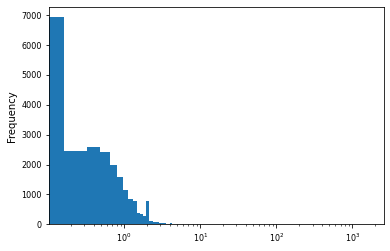

In [364]:
df_slim_snap_14_jul_filtered_plus_Slim_RMSSE['Slimstock_RMSSE'].plot.hist(bins=10000, logx = True)
plt.show()

In [365]:
top_n_RMSSE = df_slim_snap_14_jul_filtered_plus_Slim_RMSSE.nlargest(50, 'Slimstock_RMSSE')
top_n_RMSSE.head(n = 50)

,Artikel Code,Afzet Klasse,Forecast 1,Forecast 2,Forecast 3,Forecast 4,Forecast 5,Forecast 6,Forecast 7,Forecast 8,Forecast 9,Forecast 10,Forecast 11,Forecast 12,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,Slimstock_RMSSE
78206,12364455,4,0.00,0.00,2500.50,0.00,0.00,0.00,0.00,2500.50,0.00,0.00,0.00,0.00,0.0,0.0,2.0,0.00,0.0,1619.213063
85972,12578505,4,0.00,5.50,0.00,0.00,0.00,0.00,5.50,0.00,0.00,0.00,0.00,0.00,2.0,0.0,0.0,3900.00,0.0,795.296469
97362,12959962,6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,10000.0,0.0,0.00,0.0,724.568837
73786,12192774,5,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,350.00,2.0,717.289481
41960,11297329,4,7.50,0.00,0.00,0.00,0.00,0.00,7.50,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,5000.00,0.0,646.782525
73651,12192616,4,0.00,1.75,0.00,1.75,0.00,1.75,0.00,0.00,1.75,0.00,1.75,0.00,0.0,12.0,0.0,4900.00,0.0,416.107028
77775,12355878,4,2.33,0.00,0.00,2.33,0.00,0.00,0.00,0.00,2.33,0.00,0.00,0.00,500.0,0.0,0.0,1.00,0.0,272.586059
84057,12514259,4,0.00,0.00,0.00,0.00,0.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,6530.0,0.0,0.00,0.0,248.507115
63055,11886854,4,11.50,0.00,0.00,11.50,0.00,0.00,11.50,0.00,0.00,11.50,0.00,0.00,14.0,0.0,0.0,5012.00,0.0,221.684776
54719,11520648,6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.0,0.0,6.0,0.00,500.0,204.994751


Logarithmic nature to histogram of RMSSE values. Super high order amounts seem to be causing it. 

In [367]:
df_slim_snap_14_jul_filtered_plus_Slim_RMSSE.to_pickle(r'pickles/df_slim_snap_14_jul_filtered_plus_Slim_RMSSE_cleaned_2.pkl')


In [368]:
df_slim_snap_14_jul_filtered_plus_Slim_RMSSE_import = pd.read_pickle(r'pickles/df_slim_snap_14_jul_filtered_plus_Slim_RMSSE_cleaned_2.pkl', compression='infer')


## Notebook 5 - Implement SES

In [369]:
df_slim_snap_14_jul_filtered_plus_Slim_RMSSE_import = df_slim_snap_14_jul_filtered_plus_Slim_RMSSE_import.rename({'Slimstock_RMSSE': 'RMSSE'}, axis=1)  # new method
df_slim_snap_14_jul_filtered_plus_Slim_RMSSE_import.head()

,Artikel Code,Afzet Klasse,Forecast 1,Forecast 2,Forecast 3,Forecast 4,Forecast 5,Forecast 6,Forecast 7,Forecast 8,Forecast 9,Forecast 10,Forecast 11,Forecast 12,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,RMSSE
923,10000000,1,734.17,731.24,729.30,728.32,728.32,728.32,728.32,728.32,728.32,728.32,728.32,728.32,480.0,2700.0,660.0,500.0,540.0,1.014510
924,10000001,1,1112.62,1098.63,1089.30,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,1084.64,2120.0,1280.0,1840.0,720.0,1660.0,0.581128
925,10000002,1,1362.62,1438.11,1488.43,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,1513.59,700.0,300.0,1360.0,920.0,1140.0,1.193737
926,10000003,1,443.21,445.16,446.46,447.11,447.11,447.11,447.11,447.11,447.11,447.11,447.11,447.11,100.0,360.0,500.0,920.0,460.0,0.604525
927,10000004,1,1208.70,1204.58,1201.84,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,1200.46,2060.0,1220.0,1820.0,1260.0,880.0,0.493707


### SES definition

In [370]:
def simple_exp_smoothing_wrapper(input_data, length_forecasts): 
    fitted_ses = SimpleExpSmoothing(input_data).fit(optimized=True)
    alpha_value = fitted_ses.params_formatted.loc['smoothing_level', 'param']
    initial_value = fitted_ses.params_formatted.loc['initial_level', 'param']
    forecast_from_fitted_ses = fitted_ses.forecast(length_forecasts)
    return forecast_from_fitted_ses, alpha_value, initial_value

### Rename and trim Slim dataframe

In [371]:
print (list(df_slim_snap_14_jul_filtered_plus_Slim_RMSSE_import.columns.values))
# Match column names below to printed names
del df_slim_snap_14_jul_filtered_plus_Slim_RMSSE_import['Forecast   6']
del df_slim_snap_14_jul_filtered_plus_Slim_RMSSE_import['Forecast   7']
del df_slim_snap_14_jul_filtered_plus_Slim_RMSSE_import['Forecast   8']
del df_slim_snap_14_jul_filtered_plus_Slim_RMSSE_import['Forecast   9']
del df_slim_snap_14_jul_filtered_plus_Slim_RMSSE_import['Forecast  10']
del df_slim_snap_14_jul_filtered_plus_Slim_RMSSE_import['Forecast  11']
del df_slim_snap_14_jul_filtered_plus_Slim_RMSSE_import['Forecast  12']


['Artikel Code', 'Afzet Klasse', 'Forecast   1', 'Forecast   2', 'Forecast   3', 'Forecast   4', 'Forecast   5', 'Forecast   6', 'Forecast   7', 'Forecast   8', 'Forecast   9', 'Forecast  10', 'Forecast  11', 'Forecast  12', 'Actual_1', 'Actual_2', 'Actual_3', 'Actual_4', 'Actual_5', 'RMSSE']


In [372]:
df_slim_snap_14_jul_filtered_plus_Slim_RMSSE_import.rename({'Afzet Klasse': 'Demand_Class',
                                                            'Forecast   1': 'Forecast_1',
                                                           'Forecast   2': 'Forecast_2',
                                                           'Forecast   3': 'Forecast_3',
                                                           'Forecast   4': 'Forecast_4',
                                                           'Forecast   5': 'Forecast_5',
                                                           'Artikel Code': 'Artikel_Code'
                                                          }, axis=1, inplace=True)

df_slim_snap_14_jul_filtered_plus_Slim_RMSSE_import.head(1)


,Artikel_Code,Demand_Class,Forecast_1,Forecast_2,Forecast_3,Forecast_4,Forecast_5,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,RMSSE
923,10000000,1,734.17,731.24,729.3,728.32,728.32,480.0,2700.0,660.0,500.0,540.0,1.01451


### Create temp_df for SES results

In [373]:
temp_df = df_slim_snap_14_jul_filtered_plus_Slim_RMSSE_import[['Artikel_Code', 'Actual_1', 'Actual_2', 'Actual_3', 'Actual_4', 'Actual_5']].copy()
temp_df[['Forecast_1', 'Forecast_2', 'Forecast_3', 'Forecast_4', 'Forecast_5', 'RMSSE', 'Forecast_method']] = None 
column_names = ['Artikel_Code', 
                'Forecast_1', 
                'Forecast_2', 
                'Forecast_3', 
                'Forecast_4', 
                'Forecast_5', 
                'Actual_1', 
                'Actual_2',
                'Actual_3',
                'Actual_4', 
                'Actual_5',
                'RMSSE', 
                'Forecast_method']
temp_df = temp_df.reindex(columns=column_names)
print (len(temp_df))
temp_df.head()

23569


,Artikel_Code,Forecast_1,Forecast_2,Forecast_3,Forecast_4,Forecast_5,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,RMSSE,Forecast_method
923,10000000,None,None,None,None,None,480.0,2700.0,660.0,500.0,540.0,None,None
924,10000001,None,None,None,None,None,2120.0,1280.0,1840.0,720.0,1660.0,None,None
925,10000002,None,None,None,None,None,700.0,300.0,1360.0,920.0,1140.0,None,None
926,10000003,None,None,None,None,None,100.0,360.0,500.0,920.0,460.0,None,None
927,10000004,None,None,None,None,None,2060.0,1220.0,1820.0,1260.0,880.0,None,None


### Insert SES forecasts

In [374]:
'''
def insert_SES_forecasts_to_results_dataframe(MSEG_dataframe, Results_dataframe, length_forecasts):
    MSEG_dataframe_grouped = MSEG_dataframe.groupby(['MaterialNo'])
    Results_dataframe.fillna(0.0, inplace=True)
    i = 0
    for name, group in MSEG_dataframe_grouped:
        i += 1
        print (f'Percentage complete: {100.0 * i /  len(MSEG_dataframe_grouped)}')
        group = group.sort_values(by='PostingDate') 
        group['OQ'].fillna(0.0, inplace=True)
      
        actual_historic_data_for_SES = group['OQ'].values

        SES_forecasts, tuned_alpha, tuned_init = simple_exp_smoothing_wrapper(actual_historic_data_for_SES, length_forecasts)
        cols_to_append_to = ['Forecast_1', 'Forecast_2', 'Forecast_3', 'Forecast_4', 'Forecast_5']
        
        assert (len(SES_forecasts) == len(cols_to_append_to))

        for j in range(len(SES_forecasts)):
            Results_dataframe.loc[Results_dataframe['Artikel_Code'] == name, cols_to_append_to[j]] =  SES_forecasts[j]
            
        Results_dataframe.loc[Results_dataframe['Artikel_Code'] == name, 'alpha_SES_tuned'] =  tuned_alpha
        Results_dataframe.loc[Results_dataframe['Artikel_Code'] == name, 'init_SES_tuned'] =  tuned_init

    return Results_dataframe    

temp_SES_df = insert_SES_forecasts_to_results_dataframe(df_MSEG_filtered_before_1_July_with_missing_months_group_by_plus_counts_and_OQ, temp_df, 5)
temp_SES_df.head(50)
'''

"\ndef insert_SES_forecasts_to_results_dataframe(MSEG_dataframe, Results_dataframe, length_forecasts):\n    MSEG_dataframe_grouped = MSEG_dataframe.groupby(['MaterialNo'])\n    Results_dataframe.fillna(0.0, inplace=True)\n    i = 0\n    for name, group in MSEG_dataframe_grouped:\n        i += 1\n        print (f'Percentage complete: {100.0 * i /  len(MSEG_dataframe_grouped)}')\n        group = group.sort_values(by='PostingDate') \n        group['OQ'].fillna(0.0, inplace=True)\n      \n        actual_historic_data_for_SES = group['OQ'].values\n\n        SES_forecasts, tuned_alpha, tuned_init = simple_exp_smoothing_wrapper(actual_historic_data_for_SES, length_forecasts)\n        cols_to_append_to = ['Forecast_1', 'Forecast_2', 'Forecast_3', 'Forecast_4', 'Forecast_5']\n        \n        assert (len(SES_forecasts) == len(cols_to_append_to))\n\n        for j in range(len(SES_forecasts)):\n            Results_dataframe.loc[Results_dataframe['Artikel_Code'] == name, cols_to_append_to[j]] =  

### Calc RMSSE on SES forecasts

In [375]:
'''
def calculate_RMSSE_for_SKUs(MSEG_dataframe, Results_dataframe, forecast_method):

    MSEG_dataframe_grouped = MSEG_dataframe.groupby(['MaterialNo'])
    Results_dataframe.fillna(0.0, inplace=True)
    i = 0
    for name, group in MSEG_dataframe_grouped:
        i += 1
        print (f'Percentage complete: {100.0 * i /  len(MSEG_dataframe_grouped)}')
        group = group.sort_values(by='PostingDate') 
        group['OQ'].fillna(0.0, inplace=True)
        forecast_data = Results_dataframe.loc[(Results_dataframe['Artikel_Code'] == name), 'Forecast_1' : 'Forecast_5'] 
        # Note, we often have multiple rows in the Slimstock forecasting data for individual SKUs. 
        # Pass each row into error function. Deal with down the line. Should be fine to just add errors for each row, if we want to. 
        actual_data = Results_dataframe.loc[(Results_dataframe['Artikel_Code'] == name), 'Actual_1' : 'Actual_5'] 
        actual_historic_data_for_RMSSE = group['OQ'].values

        for ( forecast_id, forecast_row ), ( actual_id, actual_row ) in zip( forecast_data.iterrows(), actual_data.iterrows()):
            forecast_data_for_RMSSE = forecast_row.values
            actual_data_for_RMSSE = actual_row.values

            error_for_forecast_row = EF.Root_Mean_Square_Scaled_Error(forecast_data_for_RMSSE, actual_data_for_RMSSE, actual_historic_data_for_RMSSE)
            Results_dataframe.loc[forecast_id, 'RMSSE'] = error_for_forecast_row
            Results_dataframe.loc[forecast_id, 'Forecast_method'] = forecast_method

    return Results_dataframe


temp_SES_df_plus_RMSSEs = calculate_RMSSE_for_SKUs(df_MSEG_filtered_before_1_July_with_missing_months_group_by_plus_counts_and_OQ,
                                  temp_SES_df,
                                  'SES')

'''

"\ndef calculate_RMSSE_for_SKUs(MSEG_dataframe, Results_dataframe, forecast_method):\n\n    MSEG_dataframe_grouped = MSEG_dataframe.groupby(['MaterialNo'])\n    Results_dataframe.fillna(0.0, inplace=True)\n    i = 0\n    for name, group in MSEG_dataframe_grouped:\n        i += 1\n        print (f'Percentage complete: {100.0 * i /  len(MSEG_dataframe_grouped)}')\n        group = group.sort_values(by='PostingDate') \n        group['OQ'].fillna(0.0, inplace=True)\n        forecast_data = Results_dataframe.loc[(Results_dataframe['Artikel_Code'] == name), 'Forecast_1' : 'Forecast_5'] \n        # Note, we often have multiple rows in the Slimstock forecasting data for individual SKUs. \n        # Pass each row into error function. Deal with down the line. Should be fine to just add errors for each row, if we want to. \n        actual_data = Results_dataframe.loc[(Results_dataframe['Artikel_Code'] == name), 'Actual_1' : 'Actual_5'] \n        actual_historic_data_for_RMSSE = group['OQ'].values\

In [376]:
#temp_SES_df_plus_RMSSEs.to_pickle(r'pickles/SES_forecasts_plus_RMSSE_for_MSEG_data.pkl')

In [377]:
temp_SES_df_plus_RMSSEs = pd.read_pickle(r'pickles/SES_forecasts_plus_RMSSE_for_MSEG_data.pkl', compression='infer')

### Rename misleading forecasts df name, and add in Forecast_method = Slim for Slim forecasts, BEFORE ADDING SES FORECASTS

In [378]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs = df_slim_snap_14_jul_filtered_plus_Slim_RMSSE_import
df_slim_snap_14_jul_filtered_plus_all_RMSSEs['Forecast_method'] = 'Slim'

df_slim_snap_14_jul_filtered_plus_all_RMSSEs.head()

,Artikel_Code,Demand_Class,Forecast_1,Forecast_2,Forecast_3,Forecast_4,Forecast_5,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,RMSSE,Forecast_method
923,10000000,1,734.17,731.24,729.30,728.32,728.32,480.0,2700.0,660.0,500.0,540.0,1.014510,Slim
924,10000001,1,1112.62,1098.63,1089.30,1084.64,1084.64,2120.0,1280.0,1840.0,720.0,1660.0,0.581128,Slim
925,10000002,1,1362.62,1438.11,1488.43,1513.59,1513.59,700.0,300.0,1360.0,920.0,1140.0,1.193737,Slim
926,10000003,1,443.21,445.16,446.46,447.11,447.11,100.0,360.0,500.0,920.0,460.0,0.604525,Slim
927,10000004,1,1208.70,1204.58,1201.84,1200.46,1200.46,2060.0,1220.0,1820.0,1260.0,880.0,0.493707,Slim


### Append SES results to Slim forecasts

In [379]:
Forecast_methods_previously = ['Slim']
df_slim_snap_14_jul_filtered_plus_all_RMSSEs = df_slim_snap_14_jul_filtered_plus_all_RMSSEs.loc[
    df_slim_snap_14_jul_filtered_plus_all_RMSSEs['Forecast_method'].isin(Forecast_methods_previously)]

print (f'length of results df before appending SES results = {len(df_slim_snap_14_jul_filtered_plus_all_RMSSEs)}')
df_slim_snap_14_jul_filtered_plus_all_RMSSEs = df_slim_snap_14_jul_filtered_plus_all_RMSSEs.append(temp_SES_df_plus_RMSSEs)
print (f'length of results df after appending SES results = {len(df_slim_snap_14_jul_filtered_plus_all_RMSSEs)}')


length of results df before appending SES results = 23569
length of results df after appending SES results = 47138


### Sum errors

In [380]:
sum_errors = df_slim_snap_14_jul_filtered_plus_all_RMSSEs.groupby(['Forecast_method']).RMSSE.sum().reset_index()
sum_errors.head()

,Forecast_method,RMSSE
0,SES,20426.775957
1,Slim,25473.078379


In [381]:
print (20426.775957/25473.078379)

0.8018966397810731


Wow, okay, so having used the MSEG data, which, from Hans, looks to be the demand that Slim4 sees, we appear to have been able to reduce the RMSSE of Slim by around 20%. That's really good. Let's see how the TSB method fairs:

## Notebook 5 - Croston/TSB

### Implement Croston/TSB

In [382]:
def Croston(ts,extra_periods=1,alpha=0.4):
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods

    #level (a), periodicity(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    q = 1 #periods since last demand observation

    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1 + first_occurence
    f[0] = a[0]/p[0]
    # Create all the t+1 forecasts
    for t in range(0,cols):        
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = alpha*q + (1-alpha)*p[t]
            f[t+1] = a[t+1]/p[t+1]
            q = 1           
        else:
            a[t+1] = a[t]
            p[t+1] = p[t]
            f[t+1] = f[t]
            q += 1

    # Future Forecast 
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]

    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df

def Croston_TSB(ts, extra_periods ,alpha=0.4,beta=0.4):
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods

    #level (a), probability(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1/(1 + first_occurence)
    f[0] = p[0]*a[0]

    # Create all the t+1 forecasts
    for t in range(0,cols): 
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = beta*(1) + (1-beta)*p[t]  
        else:
            a[t+1] = a[t]
            p[t+1] = (1-beta)*p[t]       
        f[t+1] = p[t+1]*a[t+1]

    # Future Forecast
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
    #print (f'f = {f}')
    #print (f'f[len(ts):] = {f[len(ts):]}')
    forecasts = f[len(ts):]
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return forecasts


### Create TSB forecasts and calc RMSSE

In [383]:
def insert_forecasts_to_results_dataframe(MSEG_dataframe, Results_dataframe, length_forecasts, forecast_method):
    MSEG_dataframe_grouped = MSEG_dataframe.groupby(['MaterialNo'])
    Results_dataframe.fillna(0.0, inplace=True)
    i = 0
    for name, group in MSEG_dataframe_grouped:
        i += 1
        print (f'Percentage complete: {100.0 * i /  len(MSEG_dataframe_grouped)}')
        group = group.sort_values(by='PostingDate') 
        group['OQ'].fillna(0.0, inplace=True)    
        actual_historic_data = group['OQ'].values
        forecasts = forecast_method(actual_historic_data, length_forecasts)
        cols_to_append_to = ['Forecast_1', 'Forecast_2', 'Forecast_3', 'Forecast_4', 'Forecast_5']   
        assert (len(forecasts) == len(cols_to_append_to))
        for j in range(len(forecasts)):
            Results_dataframe.loc[Results_dataframe['Artikel_Code'] == name, cols_to_append_to[j]] =  forecasts[j]       
    return Results_dataframe  


def create_forecast_method_df_and_forecast_and_calc_RMSSE(Results_df, MSEG_df, length_forecasts, forecast_method):
    print (len(Results_df))
    temp_df = Results_df[Results_df['Forecast_method'] == 'Slim'] # Get unique SKU set, forecast by Slim
    print (len(temp_df))
    temp_df = temp_df[['Artikel_Code', 'Actual_1', 'Actual_2', 'Actual_3', 'Actual_4', 'Actual_5']].copy()
    column_names = ['Artikel_Code', 
                    'Forecast_1', 
                    'Forecast_2', 
                    'Forecast_3', 
                    'Forecast_4', 
                    'Forecast_5', 
                    'Actual_1', 
                    'Actual_2',
                    'Actual_3',
                    'Actual_4', 
                    'Actual_5',
                    'RMSSE', 
                    'Forecast_method']
    temp_df = temp_df.reindex(columns=column_names)
    temp_df_with_forecasts = insert_forecasts_to_results_dataframe(MSEG_df, 
                                                                   temp_df, 
                                                                   length_forecasts,
                                                                   forecast_method)
    
    temp_df_with_forecasts_and_errors = calculate_RMSSE_for_SKUs(MSEG_df,temp_df_with_forecasts, 'TSB')    
    return temp_df_with_forecasts_and_errors


'''
TSB_df = create_forecast_method_df_and_forecast_and_calc_RMSSE(df_slim_snap_14_jul_filtered_plus_all_RMSSEs, 
                                               df_MSEG_filtered_before_1_July_with_missing_months_group_by_plus_counts_and_OQ,
                                               5, 
                                               Croston_TSB)
'''


'\nTSB_df = create_forecast_method_df_and_forecast_and_calc_RMSSE(df_slim_snap_14_jul_filtered_plus_all_RMSSEs, \n                                               df_MSEG_filtered_before_1_July_with_missing_months_group_by_plus_counts_and_OQ,\n                                               5, \n                                               Croston_TSB)\n'

### Save TSB df

In [384]:
#TSB_df.to_pickle(r'pickles/TSB_forecasts_on_MSEG_data.pkl')


In [385]:
TSB_df = pd.read_pickle(r'pickles/TSB_forecasts_on_MSEG_data.pkl')

### Append to main results df

In [386]:
Forecast_methods_previously = ['Slim', 'SES']
df_slim_snap_14_jul_filtered_plus_all_RMSSEs = df_slim_snap_14_jul_filtered_plus_all_RMSSEs.loc[
    df_slim_snap_14_jul_filtered_plus_all_RMSSEs['Forecast_method'].isin(Forecast_methods_previously)]

df_slim_snap_14_jul_filtered_plus_all_RMSSEs = df_slim_snap_14_jul_filtered_plus_all_RMSSEs.append(TSB_df)



### Sum errors, compare

In [387]:
sum_errors = df_slim_snap_14_jul_filtered_plus_all_RMSSEs.groupby(['Forecast_method']).RMSSE.sum().reset_index()
sum_errors.head()

,Forecast_method,RMSSE
0,SES,20426.775957
1,Slim,25473.078379
2,TSB,19661.687356


### Histograms of errors

array([[<AxesSubplot:title={'center':'SES'}>,
        <AxesSubplot:title={'center':'Slim'}>],
       [<AxesSubplot:title={'center':'TSB'}>, <AxesSubplot:>]],
      dtype=object)

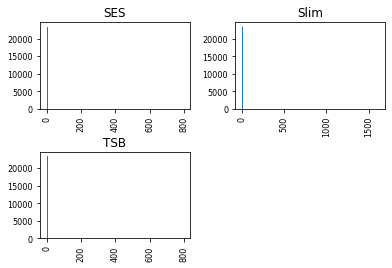

In [388]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs['RMSSE'].hist(by=df_slim_snap_14_jul_filtered_plus_all_RMSSEs['Forecast_method'], bins = 100)


### Top n errors

In [389]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs = df_slim_snap_14_jul_filtered_plus_all_RMSSEs.sort_values('RMSSE', ascending = False)
df_slim_snap_14_jul_filtered_plus_all_RMSSEs.head(50)

,Artikel_Code,Demand_Class,Forecast_1,Forecast_2,Forecast_3,Forecast_4,Forecast_5,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,RMSSE,Forecast_method
78206,12364455,4.0,0.000000,0.000000,2500.500000,0.000000,0.000000,0.0,0.0,2.0,0.0,0.0,1619.213063,Slim
85972,12578505,4.0,0.000000,5.500000,0.000000,0.000000,0.000000,2.0,0.0,0.0,3900.0,0.0,795.296469,Slim
85972,12578505,NaN,0.242064,0.242064,0.242064,0.242064,0.242064,2.0,0.0,0.0,3900.0,0.0,795.246297,TSB
85972,12578505,NaN,0.255814,0.255814,0.255814,0.255814,0.255814,2.0,0.0,0.0,3900.0,0.0,795.243492,SES
97362,12959962,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,10000.0,0.0,0.0,0.0,724.568837,Slim
97362,12959962,NaN,0.000002,0.000002,0.000002,0.000002,0.000002,0.0,10000.0,0.0,0.0,0.0,724.568837,TSB
97362,12959962,NaN,0.930233,0.930233,0.930233,0.930233,0.930233,0.0,10000.0,0.0,0.0,0.0,724.501448,SES
73786,12192774,5.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,350.0,2.0,717.289481,Slim
73786,12192774,NaN,0.023256,0.023256,0.023256,0.023256,0.023256,0.0,0.0,0.0,350.0,2.0,717.250339,SES
73786,12192774,NaN,0.051840,0.051840,0.051840,0.051840,0.051840,0.0,0.0,0.0,350.0,2.0,717.191450,TSB


In [390]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs.head()

,Artikel_Code,Demand_Class,Forecast_1,Forecast_2,Forecast_3,Forecast_4,Forecast_5,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,RMSSE,Forecast_method
78206,12364455,4.0,0.000000,0.000000,2500.500000,0.000000,0.000000,0.0,0.0,2.0,0.0,0.0,1619.213063,Slim
85972,12578505,4.0,0.000000,5.500000,0.000000,0.000000,0.000000,2.0,0.0,0.0,3900.0,0.0,795.296469,Slim
85972,12578505,NaN,0.242064,0.242064,0.242064,0.242064,0.242064,2.0,0.0,0.0,3900.0,0.0,795.246297,TSB
85972,12578505,NaN,0.255814,0.255814,0.255814,0.255814,0.255814,2.0,0.0,0.0,3900.0,0.0,795.243492,SES
97362,12959962,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,10000.0,0.0,0.0,0.0,724.568837,Slim


## Notebook 5 - Optimize TSB params (6.3)

In [391]:
def simple_exp_smoothing_wrapper(input_data, length_forecasts, parameter_vector): 
    # We haven't changed SES yet, to make use of a manual parameter vector, and then perform the parameter 
    # optimization manually. The in-built optimization is working for now. But we should either fully understand how 
    # it's working, or re-implement SES with manual optimization. If we do the latter, we'll need parameter_vector.
    fitted_ses = SimpleExpSmoothing(input_data).fit(optimized=True)
    #print (fitted_ses.params_formatted)
    forecast_from_fitted_ses = fitted_ses.forecast(length_forecasts)
    return forecast_from_fitted_ses

def Croston_TSB(ts, extra_periods ,parameter_vector):
    alpha = parameter_vector[0]
    beta = parameter_vector[1]
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods

    #level (a), probability(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1/(1 + first_occurence)
    f[0] = p[0]*a[0]

    # Create all the t+1 forecasts
    for t in range(0,cols): 
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = beta*(1) + (1-beta)*p[t]  
        else:
            a[t+1] = a[t]
            p[t+1] = (1-beta)*p[t]       
        f[t+1] = p[t+1]*a[t+1]

    # Future Forecast
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
    #print (f'f = {f}')
    #print (f'f[len(ts):] = {f[len(ts):]}')
    forecasts = f[len(ts):]
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return forecasts

In [392]:
importlib.reload(EF)
def insert_forecasts_to_results_dataframe(MSEG_dataframe, Results_dataframe, length_forecasts, forecast_method, n_grid_search):
    MSEG_dataframe_grouped = MSEG_dataframe.groupby(['MaterialNo'])
    Results_dataframe.fillna(0.0, inplace=True)
    i = 0
    for name, group in MSEG_dataframe_grouped:
        i += 1
        print (f'Percentage complete: {100.0 * i /  len(MSEG_dataframe_grouped)}')
        group = group.sort_values(by='PostingDate') 
        group['OQ'].fillna(0.0, inplace=True)    
        actual_historic_data = group['OQ'].values
        actual_data = Results_dataframe.loc[(Results_dataframe['Artikel_Code'] == name), 'Actual_1' : 'Actual_5'] 
        # We're going to implement a rudimentary grid search here:
        best_param_set = 0
        best_RMSSE = 10.0**100
        best_forecast = 0
        param_values = np.random.uniform(low=0.0,high=0.5,size=(n_grid_search,2))

        for param_set in range(param_values.shape[0] - 1):
            # If you see 'opla' going forward, it's shorthand for 'one-period look ahead'
            Total_RMSSE_opla_for_single_param_vector = 0.0 
            #Loop through the historical data, producing a forecast for the next timestep ('opla')
            for data_point_index in range(len(actual_historic_data) - 1):
                #print (f'data_point_index = {data_point_index}')
                
                forecast_of_next_data_point = forecast_method(actual_historic_data[:data_point_index+1], 
                                                              1, 
                                                              param_values[param_set])
                #print (f'forecast_of_next_data_point = {forecast_of_next_data_point}')

                next_data_point = actual_historic_data[data_point_index + 1]
                #print (f'next_data_point = {next_data_point}')

                historic_data_for_opla = actual_historic_data[:data_point_index + 1]
                #print (f'historic_data_for_opla = {historic_data_for_opla}')

                RMSSE_opla_for_data_point = EF.Root_Mean_Square_Scaled_Error(np.array([forecast_of_next_data_point]),
                                                                            np.array([next_data_point]),
                                                                            historic_data_for_opla,
                                                                            OPLA_bool = True)
                #print (f'RMSSE_opla_for_data_point = {RMSSE_opla_for_data_point}')

                Total_RMSSE_opla_for_single_param_vector += RMSSE_opla_for_data_point
                #print (f'Total_RMSSE_opla_for_single_param_vector = {Total_RMSSE_opla_for_single_param_vector}')
            # For fitting the parameters of Croston/SES, do we use MSE or RMSSE? 
            # MSE will surely force the parameters to produce zero forecasts. 
            # Let's use RMSSE.             
            #print (f'param_set = {param_values[param_set]}')
            #print (f'Total_RMSSE_opla_for_single_param_vector = {Total_RMSSE_opla_for_single_param_vector}')
            #print (f'best_RMSSE = {best_RMSSE}')

            if (Total_RMSSE_opla_for_single_param_vector < best_RMSSE):
                best_RMSSE = Total_RMSSE_opla_for_single_param_vector 
                best_param_set = param_values[param_set]
                # Use the current best param set to actually produce the required multiple period look ahead forecasts
                forecasts_using_current_best_param_set = forecast_method(actual_historic_data, 
                                                                         length_forecasts, 
                                                                         best_param_set)
                #print (type(best_forecast))
                best_forecast = forecasts_using_current_best_param_set
        
        # Need to sort this. How do we calculate MSE/RMSSE, using our existing RMSSE function, and 
        # how do we use our forecasting function for this? We haven't built functions to do one-period
        # look ahead, instead to forecast and calc RMSSE over a forecast horizon. Will need to edit them 
        # if we want to do manual param optimization
        cols_to_append_to = ['Forecast_1', 'Forecast_2', 'Forecast_3', 'Forecast_4', 'Forecast_5']   
        assert (len(best_forecast) == len(cols_to_append_to))
        Results_dataframe.loc[Results_dataframe['Artikel_Code'] == name, 'alpha_TSB'] =  best_param_set[0]       
        Results_dataframe.loc[Results_dataframe['Artikel_Code'] == name, 'beta_TSB'] =  best_param_set[1]     
        for j in range(len(best_forecast)):
            Results_dataframe.loc[Results_dataframe['Artikel_Code'] == name, cols_to_append_to[j]] =  best_forecast[j]  
  
    return Results_dataframe  


def create_forecast_method_df_and_forecast_and_calc_RMSSE(Results_df, Ted_df, length_forecasts, forecast_method, n_grid_search, name_for_forecast_method_col):
    print (len(Results_df))
    temp_df = Results_df[Results_df['Forecast_method'] == 'Slim'] # Get unique SKU set, forecast by Slim
    print (len(temp_df))
    temp_df = temp_df[['Artikel_Code', 'Actual_1', 'Actual_2', 'Actual_3', 'Actual_4', 'Actual_5']].copy()
    column_names = ['Artikel_Code', 
                    'Forecast_1', 
                    'Forecast_2', 
                    'Forecast_3', 
                    'Forecast_4', 
                    'Forecast_5', 
                    'Actual_1', 
                    'Actual_2',
                    'Actual_3',
                    'Actual_4', 
                    'Actual_5',
                    'RMSSE', 
                    'Forecast_method']
    temp_df = temp_df.reindex(columns=column_names)
    temp_df_with_forecasts = insert_forecasts_to_results_dataframe(Ted_df, 
                                                                   temp_df, 
                                                                   length_forecasts,
                                                                   forecast_method, 
                                                                   n_grid_search)
    
    temp_df_with_forecasts_and_errors = calculate_RMSSE_for_SKUs(Ted_df,temp_df_with_forecasts, name_for_forecast_method_col)    
    return temp_df_with_forecasts_and_errors



In [393]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs.head()

,Artikel_Code,Demand_Class,Forecast_1,Forecast_2,Forecast_3,Forecast_4,Forecast_5,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,RMSSE,Forecast_method
78206,12364455,4.0,0.000000,0.000000,2500.500000,0.000000,0.000000,0.0,0.0,2.0,0.0,0.0,1619.213063,Slim
85972,12578505,4.0,0.000000,5.500000,0.000000,0.000000,0.000000,2.0,0.0,0.0,3900.0,0.0,795.296469,Slim
85972,12578505,NaN,0.242064,0.242064,0.242064,0.242064,0.242064,2.0,0.0,0.0,3900.0,0.0,795.246297,TSB
85972,12578505,NaN,0.255814,0.255814,0.255814,0.255814,0.255814,2.0,0.0,0.0,3900.0,0.0,795.243492,SES
97362,12959962,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,10000.0,0.0,0.0,0.0,724.568837,Slim


In [394]:
test_df = df_slim_snap_14_jul_filtered_plus_all_RMSSEs.head(10)

'''
TSB_tuned_df = create_forecast_method_df_and_forecast_and_calc_RMSSE(df_slim_snap_14_jul_filtered_plus_all_RMSSEs, 
                                               df_MSEG_filtered_before_1_July_with_missing_months_group_by_plus_counts_and_OQ,
                                               5, 
                                               Croston_TSB,
                                               n_grid_search = 5,
                                               name_for_forecast_method_col = 'TSB_grid_search')
'''

"\nTSB_tuned_df = create_forecast_method_df_and_forecast_and_calc_RMSSE(df_slim_snap_14_jul_filtered_plus_all_RMSSEs, \n                                               df_MSEG_filtered_before_1_July_with_missing_months_group_by_plus_counts_and_OQ,\n                                               5, \n                                               Croston_TSB,\n                                               n_grid_search = 5,\n                                               name_for_forecast_method_col = 'TSB_grid_search')\n"

In [395]:
#TSB_tuned_df.to_pickle(r'pickles/TSB_forecasts_on_MSEG_data_tuned_n_grid_search_equals_10.pkl')

In [396]:
TSB_tuned_df = pd.read_pickle(r'pickles/TSB_forecasts_on_MSEG_data_tuned_n_grid_search_equals_10.pkl')


In [397]:
TSB_tuned_df.head(50)

,Artikel_Code,Forecast_1,Forecast_2,Forecast_3,Forecast_4,Forecast_5,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,RMSSE,Forecast_method,alpha_TSB,beta_TSB
0,12364455,1.230065e-01,1.230065e-01,1.230065e-01,1.230065e-01,1.230065e-01,0.0,0.0,2.0,0.00,0.0,1.226835,TSB_grid_search,0.315889,0.068303
1,12578505,2.202104e-01,2.202104e-01,2.202104e-01,2.202104e-01,2.202104e-01,2.0,0.0,0.0,3900.00,0.0,795.250755,TSB_grid_search,0.424043,0.008214
4,12959962,1.230778e-08,1.230778e-08,1.230778e-08,1.230778e-08,1.230778e-08,0.0,10000.0,0.0,0.00,0.0,724.568837,TSB_grid_search,0.417151,0.495189
7,12192774,4.893843e-02,4.893843e-02,4.893843e-02,4.893843e-02,4.893843e-02,0.0,0.0,0.0,350.00,2.0,717.197427,TSB_grid_search,0.263633,0.060604
10,11297329,4.845332e-02,4.845332e-02,4.845332e-02,4.845332e-02,4.845332e-02,0.0,0.0,0.0,5000.00,0.0,646.775530,TSB_grid_search,0.412684,0.383207
15,12192616,9.382283e-01,9.382283e-01,9.382283e-01,9.382283e-01,9.382283e-01,0.0,12.0,0.0,4900.00,0.0,416.176161,TSB_grid_search,0.406122,0.111379
18,12355878,1.187549e-01,1.187549e-01,1.187549e-01,1.187549e-01,1.187549e-01,500.0,0.0,0.0,1.00,0.0,273.796683,TSB_grid_search,0.095507,0.282915
19,12514259,3.202199e+00,3.202199e+00,3.202199e+00,3.202199e+00,3.202199e+00,0.0,6530.0,0.0,0.00,0.0,248.385371,TSB_grid_search,0.436338,0.098482
24,11886854,5.063800e+00,5.063800e+00,5.063800e+00,5.063800e+00,5.063800e+00,14.0,0.0,0.0,5012.00,0.0,221.970776,TSB_grid_search,0.041437,0.152483
25,11520648,1.768483e-01,1.768483e-01,1.768483e-01,1.768483e-01,1.768483e-01,10.0,0.0,6.0,0.00,500.0,204.920016,TSB_grid_search,0.282112,0.040162


In [398]:
df_MSEG_filtered_before_1_July_with_missing_months_group_by_plus_counts_and_OQ.head()

,PostingDate,MaterialNo,Number_of_orders,OQ
0,2017-01-01,10000000,11,800.0
1,2017-01-01,10000001,10,1380.0
2,2017-01-01,10000002,5,200.2
3,2017-01-01,10000003,8,480.0
4,2017-01-01,10000004,10,1260.2


In [399]:
Forecast_methods_previously = ['Slim', 'SES', 'TSB']
df_slim_snap_14_jul_filtered_plus_all_RMSSEs = df_slim_snap_14_jul_filtered_plus_all_RMSSEs.loc[
    df_slim_snap_14_jul_filtered_plus_all_RMSSEs['Forecast_method'].isin(Forecast_methods_previously)]

df_slim_snap_14_jul_filtered_plus_all_RMSSEs = df_slim_snap_14_jul_filtered_plus_all_RMSSEs.append(TSB_tuned_df)
#print (df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP.Forecast_method.value_counts())


In [400]:
sum_errors = df_slim_snap_14_jul_filtered_plus_all_RMSSEs.groupby(['Forecast_method']).RMSSE.sum().reset_index()
sum_errors.head()

,Forecast_method,RMSSE
0,SES,20426.775957
1,Slim,25473.078379
2,TSB,19661.687356
3,TSB_grid_search,19615.610875


## Analyse DeepAR performance (from notebook 5)

### Import DeepAR forecasts

In [401]:
with open("deep_ar_forecasts_monthly_v3.txt", "rb") as fp:   # Unpickling
    deep_ar_forecasts_monthly = pickle.load(fp)

with open("deep_ar_tss_monthly_v3.txt", "rb") as fp:   # Unpickling
    deep_ar_tss_monthly = pickle.load(fp)

### Isolate forecasts

In [402]:
deep_ar_forecast = deep_ar_forecasts_monthly[0]
print (deep_ar_forecast.item_id)
print (deep_ar_forecast.mean[0:5]) # We'll want only the first five predictions from July 2020 onwards
print (deep_ar_forecast.start_date)
print (deep_ar_forecast.quantile(0.5)[0:5]) # Use 50th percentile!!

#print (deep_ar_forecast.mean) # We'll want only the first five predictions from July 2020 onwards
#print (deep_ar_forecast.mean[-5:-2]) # We'll want only the first five predictions from July 2020 onwards


10000000
[981.5367  904.88336 905.7733  926.09    950.13336]
2020-07-31 00:00:00
[771. 699. 703. 725. 704.]


In [403]:
deep_ar_ts = deep_ar_tss_monthly[0]
print (deep_ar_ts)

                 0
2017-01-31   800.0
2017-02-28  1820.0
2017-03-31   820.0
2017-04-30  1860.0
2017-05-31   180.0
2017-06-30  1000.0
2017-07-31   200.0
2017-08-31   320.0
2017-09-30   380.0
2017-10-31   860.0
2017-11-30  2700.0
2017-12-31   380.0
2018-01-31   900.0
2018-02-28  1220.0
2018-03-31   540.0
2018-04-30   760.0
2018-05-31  1240.0
2018-06-30   620.0
2018-07-31   980.0
2018-08-31   640.0
2018-09-30  1100.0
2018-10-31   960.0
2018-11-30  1520.0
2018-12-31   720.0
2019-01-31  1980.0
2019-02-28   560.0
2019-03-31   200.0
2019-04-30   560.0
2019-05-31   700.0
2019-06-30   160.0
2019-07-31   660.0
2019-08-31   220.0
2019-09-30   540.0
2019-10-31   960.0
2019-11-30   560.0
2019-12-31  2140.0
2020-01-31   920.0
2020-02-29   620.0
2020-03-31  1940.0
2020-04-30   320.0
2020-05-31   240.0
2020-06-30   420.0
2020-07-31   480.0
2020-08-31  2700.0
2020-09-30   660.0
2020-10-31   500.0
2020-11-30   540.0
2020-12-31  1080.0
2021-01-31   300.0


Ok, so now, we have the historic data, we have the SKU, we have its forecasts, and we're only missing the actual values, which already exist in our results df. The historic values also exist, but I want to check that the correct historic values are being used(i.e., the 0-th forecast and time series belong to the right SKU).

### Append forecasts to results df and calc RMSSE

In [404]:
import numpy.testing as npt
def insert_DeepAR_forecasts_to_results_dataframe(temp_df, 
                                                 deep_ar_forecasts_monthly, 
                                                 deep_ar_tss_monthly):
    i = 0
    for deep_ar_forecast, deep_ar_ts in zip(deep_ar_forecasts_monthly, deep_ar_tss_monthly):
        #print ('top of loop')

        SKU_id = deep_ar_forecast.item_id 
        SKU_forecasts = deep_ar_forecast.quantile(0.5)[0:5]
        SKU_upper_confidence = deep_ar_forecast.quantile(0.84)[0:5]
        SKU_lower_confidence = deep_ar_forecast.quantile(0.16)[0:5]
        #print (SKU_forecasts)
        #print (type(SKU_id))
        
        if (SKU_id == '12509084'):
            print (SKU_forecasts)
        # Make sure actual values from DeepAR match those in forecasts dataframe
        df_forecasts_one_sku = temp_df[temp_df['Artikel_Code'] == str(SKU_id)]

        if df_forecasts_one_sku.empty:   
            #print (f'SKU_id = {SKU_id}')
            #print (f'SKU_forecasts = {SKU_forecasts}')
            #print ('This SKU has no demand before July 2020')
            continue
            
        actual_values_for_sku = df_forecasts_one_sku[['Actual_1', 'Actual_2', 'Actual_3', 'Actual_4', 'Actual_5']].values[0]       
        #print (f'SKU = {SKU_id}')
        #print (f'deep_ar_ts.values.flatten()[-7:-2] = {deep_ar_ts.values.flatten()[-7:-2]}')
        #print (f'actual_values_for_sku = {actual_values_for_sku}')
        npt.assert_almost_equal(deep_ar_ts.values.flatten()[-7:-2], actual_values_for_sku, decimal = 1)

        cols_to_append_to = ['Forecast_1', 'Forecast_2', 'Forecast_3', 'Forecast_4', 'Forecast_5'] 
        upper_confidence_cols_to_append_to = ['UC_1', 'UC_2', 'UC_3', 'UC_4', 'UC_5'] 
        lower_confidence_cols_to_append_to = ['LC_1', 'LC_2', 'LC_3', 'LC_4', 'LC_5'] 

        assert (len(SKU_forecasts) == len(cols_to_append_to))
        for j in range(len(SKU_forecasts)):
            temp_df.loc[temp_df['Artikel_Code'] == SKU_id, cols_to_append_to[j]] =  SKU_forecasts[j]          
            temp_df.loc[temp_df['Artikel_Code'] == SKU_id, upper_confidence_cols_to_append_to[j]] =  SKU_upper_confidence[j]
            temp_df.loc[temp_df['Artikel_Code'] == SKU_id, lower_confidence_cols_to_append_to[j]] =  SKU_lower_confidence[j]

        i += 1
        print (f'Percentage complete of DeepAR forecast insertion to temp df: {100.0 * i /  len(deep_ar_forecasts_monthly)}')
    return temp_df

        
def create_DeepAR_forecast_method_df_and_forecast_and_calc_RMSSE(MSEG_df,
                                                                 Results_df, 
                                                                 deep_ar_forecasts_monthly,
                                                                 deep_ar_tss_monthly):
    print (len(Results_df))
    temp_df = Results_df[Results_df['Forecast_method'] == 'Slim'] # Get unique SKU set, forecast by Slim
    print (len(temp_df))
    temp_df = temp_df[['Artikel_Code', 'Actual_1', 'Actual_2', 'Actual_3', 'Actual_4', 'Actual_5']].copy()
    column_names = ['Artikel_Code', 
                'Forecast_1', 
                'Forecast_2', 
                'Forecast_3', 
                'Forecast_4', 
                'Forecast_5', 
                'Actual_1', 
                'Actual_2',
                'Actual_3',
                'Actual_4', 
                'Actual_5',
                'RMSSE', 
                'Forecast_method',
                'UC_1',
                'UC_2',
                'UC_3',
                'UC_4',
                'UC_5',
                'LC_1',
                'LC_2',
                'LC_3',
                'LC_4',
                'LC_5']
    temp_df = temp_df.reindex(columns=column_names)
    temp_df_with_forecasts = insert_DeepAR_forecasts_to_results_dataframe(temp_df,
                                                                          deep_ar_forecasts_monthly,
                                                                          deep_ar_tss_monthly)
    #print (temp_df_with_forecasts)
    temp_df_with_forecasts_and_errors = calculate_RMSSE_for_SKUs(MSEG_df,temp_df_with_forecasts, 'DeepAR')    
    return temp_df_with_forecasts_and_errors

'''
test_deep_ar_forecasts_monthly = deep_ar_forecasts_monthly[0:5]
test_deep_ar_tss_monthly = deep_ar_tss_monthly[0:5]

temp_deepar_forecasts_df = create_DeepAR_forecast_method_df_and_forecast_and_calc_RMSSE(df_MSEG_filtered_before_1_July_with_missing_months_group_by_plus_counts_and_OQ,
                                                                                        df_slim_snap_14_jul_filtered_plus_all_RMSSEs,
                                                                                       deep_ar_forecasts_monthly,
                                                                                       deep_ar_tss_monthly) 
'''

'\ntest_deep_ar_forecasts_monthly = deep_ar_forecasts_monthly[0:5]\ntest_deep_ar_tss_monthly = deep_ar_tss_monthly[0:5]\n\ntemp_deepar_forecasts_df = create_DeepAR_forecast_method_df_and_forecast_and_calc_RMSSE(df_MSEG_filtered_before_1_July_with_missing_months_group_by_plus_counts_and_OQ,\n                                                                                        df_slim_snap_14_jul_filtered_plus_all_RMSSEs,\n                                                                                       deep_ar_forecasts_monthly,\n                                                                                       deep_ar_tss_monthly) \n'

In [405]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs_test = df_slim_snap_14_jul_filtered_plus_all_RMSSEs[
    df_slim_snap_14_jul_filtered_plus_all_RMSSEs['Artikel_Code'] == '10004419'
]

In [406]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs_test.head()

,Artikel_Code,Demand_Class,Forecast_1,Forecast_2,Forecast_3,Forecast_4,Forecast_5,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,RMSSE,Forecast_method,alpha_TSB,beta_TSB


In [407]:
df_MSEG_filtered = pd.read_pickle(r'pickles/MSEG_data_filtered_day_level.pkl')
df_MSEG_filtered = df_MSEG_filtered[df_MSEG_filtered['MaterialNo'] == '10004419']

In [408]:
df_MSEG_filtered.head(50)

,MaterialNo,MaterialDocumentYear,Plant,InventoryMovementType,PostingDate,Quantity,BaseUnitOfMeasure,IsRecordDeleted
7488389,10004419,2020,EN01,601,2020-11-10,1.0,ST,False
7488390,10004419,2020,EN01,601,2020-11-10,9.0,ST,False


The above cells detail why we needed the if empty line in the code above. Orders only in prediction window.

### Save DeepAR RMSSE df 

In [409]:
#temp_deepar_forecasts_df.to_pickle(r'pickles/DeepAR_forecasts_on_MSEG_data_v4.pkl')

In [410]:
temp_deepar_forecasts_df = pd.read_pickle(r'pickles/DeepAR_forecasts_on_MSEG_data_v4.pkl')

In [411]:
print (len(temp_deepar_forecasts_df))
print (temp_deepar_forecasts_df.Artikel_Code.nunique())


23569
23569


In [412]:
temp_deepar_forecasts_df_test = temp_deepar_forecasts_df[
    temp_deepar_forecasts_df['Artikel_Code'] == '12509084'
]
temp_deepar_forecasts_df_test.head()


,Artikel_Code,Forecast_1,Forecast_2,Forecast_3,Forecast_4,Forecast_5,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,RMSSE,Forecast_method,UC_1,UC_2,UC_3,UC_4,UC_5,LC_1,LC_2,LC_3,LC_4,LC_5
970,12509084,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,5.22494,DeepAR,1.0,8.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


### Append to main results df

MAKE SURE WE HAVEN'T ADDED MULTIPLE SETS OF FORECASTS

In [413]:
Forecast_methods_previously = ['Slim', 'SES', 'TSB', 'TSB_grid_search']
df_slim_snap_14_jul_filtered_plus_all_RMSSEs = df_slim_snap_14_jul_filtered_plus_all_RMSSEs.loc[
    df_slim_snap_14_jul_filtered_plus_all_RMSSEs['Forecast_method'].isin(Forecast_methods_previously)]

df_slim_snap_14_jul_filtered_plus_all_RMSSEs = df_slim_snap_14_jul_filtered_plus_all_RMSSEs.append(temp_deepar_forecasts_df)
#print (df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP.Forecast_method.value_counts())

In [414]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs.head()

,Artikel_Code,Demand_Class,Forecast_1,Forecast_2,Forecast_3,Forecast_4,Forecast_5,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,RMSSE,Forecast_method,alpha_TSB,beta_TSB,UC_1,UC_2,UC_3,UC_4,UC_5,LC_1,LC_2,LC_3,LC_4,LC_5
78206,12364455,4.0,0.000000,0.000000,2500.500000,0.000000,0.000000,0.0,0.0,2.0,0.0,0.0,1619.213063,Slim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85972,12578505,4.0,0.000000,5.500000,0.000000,0.000000,0.000000,2.0,0.0,0.0,3900.0,0.0,795.296469,Slim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85972,12578505,NaN,0.242064,0.242064,0.242064,0.242064,0.242064,2.0,0.0,0.0,3900.0,0.0,795.246297,TSB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85972,12578505,NaN,0.255814,0.255814,0.255814,0.255814,0.255814,2.0,0.0,0.0,3900.0,0.0,795.243492,SES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97362,12959962,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,10000.0,0.0,0.0,0.0,724.568837,Slim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [415]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs_DeepAR = df_slim_snap_14_jul_filtered_plus_all_RMSSEs[
    df_slim_snap_14_jul_filtered_plus_all_RMSSEs['Forecast_method'] == 'DeepAR'
]
df_slim_snap_14_jul_filtered_plus_all_RMSSEs_DeepAR.UC_1.value_counts()

0.0        6798
1.0        2295
2.0        1104
3.0         769
4.0         650
           ... 
2893.0        1
11067.0       1
1251.0        1
6654.0        1
2168.0        1
Name: UC_1, Length: 2711, dtype: int64

### Sum errors, compare

In [416]:
sum_errors = df_slim_snap_14_jul_filtered_plus_all_RMSSEs.groupby(['Forecast_method']).RMSSE.sum().reset_index()

sum_errors.head()

,Forecast_method,RMSSE
0,DeepAR,19298.987705
1,SES,20426.775957
2,Slim,25473.078379
3,TSB,19661.687356
4,TSB_grid_search,19615.610875


In [417]:
Slim_error = sum_errors.loc[sum_errors['Forecast_method'] == 'Slim', 'RMSSE']
sum_errors['RMSSE'] = sum_errors['RMSSE']/Slim_error.values[0]
sum_errors.head()


,Forecast_method,RMSSE
0,DeepAR,0.757623
1,SES,0.801897
2,Slim,1.000000
3,TSB,0.771861
4,TSB_grid_search,0.770053


### Histogram

array([[<AxesSubplot:title={'center':'DeepAR'}>,
        <AxesSubplot:title={'center':'SES'}>],
       [<AxesSubplot:title={'center':'Slim'}>,
        <AxesSubplot:title={'center':'TSB'}>],
       [<AxesSubplot:title={'center':'TSB_grid_search'}>, <AxesSubplot:>]],
      dtype=object)

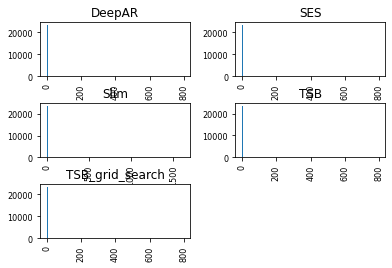

In [418]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs['RMSSE'].hist(by=df_slim_snap_14_jul_filtered_plus_all_RMSSEs['Forecast_method'], bins = 100)


### Top n errors

In [419]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs = df_slim_snap_14_jul_filtered_plus_all_RMSSEs.sort_values('RMSSE', ascending = False)
df_slim_snap_14_jul_filtered_plus_all_RMSSEs.head(50)

,Artikel_Code,Demand_Class,Forecast_1,Forecast_2,Forecast_3,Forecast_4,Forecast_5,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,RMSSE,Forecast_method,alpha_TSB,beta_TSB,UC_1,UC_2,UC_3,UC_4,UC_5,LC_1,LC_2,LC_3,LC_4,LC_5
78206,12364455,4.0,0.000000e+00,0.000000e+00,2.500500e+03,0.000000e+00,0.000000e+00,0.0,0.0,2.0,0.0,0.0,1619.213063,Slim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85972,12578505,4.0,0.000000e+00,5.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.0,0.0,0.0,3900.0,0.0,795.296469,Slim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12578505,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.0,0.0,0.0,3900.0,0.0,795.295678,DeepAR,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12578505,NaN,2.202104e-01,2.202104e-01,2.202104e-01,2.202104e-01,2.202104e-01,2.0,0.0,0.0,3900.0,0.0,795.250755,TSB_grid_search,0.424043,0.008214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85972,12578505,NaN,2.420638e-01,2.420638e-01,2.420638e-01,2.420638e-01,2.420638e-01,2.0,0.0,0.0,3900.0,0.0,795.246297,TSB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85972,12578505,NaN,2.558139e-01,2.558139e-01,2.558139e-01,2.558139e-01,2.558139e-01,2.0,0.0,0.0,3900.0,0.0,795.243492,SES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,12959962,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10000.0,0.0,0.0,0.0,724.568837,DeepAR,NaN,NaN,9.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
97362,12959962,6.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,10000.0,0.0,0.0,0.0,724.568837,Slim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12959962,NaN,1.230778e-08,1.230778e-08,1.230778e-08,1.230778e-08,1.230778e-08,0.0,10000.0,0.0,0.0,0.0,724.568837,TSB_grid_search,0.417151,0.495189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97362,12959962,NaN,1.781210e-06,1.781210e-06,1.781210e-06,1.781210e-06,1.781210e-06,0.0,10000.0,0.0,0.0,0.0,724.568837,TSB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [420]:
'''del df_slim_ses_tsb_tsb_tuned_deepar_forecasts['level_0']

df_slim_ses_tsb_tsb_tuned_deepar_forecasts = df_slim_ses_tsb_tsb_tuned_deepar_forecasts.reset_index()

df_slim_ses_tsb_tsb_tuned_deepar_forecasts_only_best_method_per_sku = df_slim_ses_tsb_tsb_tuned_deepar_forecasts.loc[
    df_slim_ses_tsb_tsb_tuned_deepar_forecasts.groupby('Artikel_Code').RMSSE.idxmin()]

df_slim_ses_tsb_tsb_tuned_deepar_forecasts_only_best_method_per_sku.Forecast_method.value_counts()
'''

"del df_slim_ses_tsb_tsb_tuned_deepar_forecasts['level_0']\n\ndf_slim_ses_tsb_tsb_tuned_deepar_forecasts = df_slim_ses_tsb_tsb_tuned_deepar_forecasts.reset_index()\n\ndf_slim_ses_tsb_tsb_tuned_deepar_forecasts_only_best_method_per_sku = df_slim_ses_tsb_tsb_tuned_deepar_forecasts.loc[\n    df_slim_ses_tsb_tsb_tuned_deepar_forecasts.groupby('Artikel_Code').RMSSE.idxmin()]\n\ndf_slim_ses_tsb_tsb_tuned_deepar_forecasts_only_best_method_per_sku.Forecast_method.value_counts()\n"

In [421]:
'''for i in range(number_of_skus_to_plot):
    random_sku = random.choice(unique_skus)
    plot_one_sku(MSEG_data_monthly,
            df_slim_ses_tsb_tsb_tuned_deepar_forecasts_only_best_method_per_sku,
            random_sku)'''

'for i in range(number_of_skus_to_plot):\n    random_sku = random.choice(unique_skus)\n    plot_one_sku(MSEG_data_monthly,\n            df_slim_ses_tsb_tsb_tuned_deepar_forecasts_only_best_method_per_sku,\n            random_sku)'

## Best performing method per SKU:

In [422]:
Forecast_methods_previously = ['Slim', 'SES', 'TSB_grid_search', 'DeepAR']
df_slim_snap_14_jul_filtered_plus_all_RMSSEs = df_slim_snap_14_jul_filtered_plus_all_RMSSEs.loc[
    df_slim_snap_14_jul_filtered_plus_all_RMSSEs['Forecast_method'].isin(Forecast_methods_previously)]

In [423]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs.head()

,Artikel_Code,Demand_Class,Forecast_1,Forecast_2,Forecast_3,Forecast_4,Forecast_5,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,RMSSE,Forecast_method,alpha_TSB,beta_TSB,UC_1,UC_2,UC_3,UC_4,UC_5,LC_1,LC_2,LC_3,LC_4,LC_5
78206,12364455,4.0,0.000000,0.000000,2500.500000,0.000000,0.000000,0.0,0.0,2.0,0.0,0.0,1619.213063,Slim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85972,12578505,4.0,0.000000,5.500000,0.000000,0.000000,0.000000,2.0,0.0,0.0,3900.0,0.0,795.296469,Slim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12578505,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,0.0,0.0,3900.0,0.0,795.295678,DeepAR,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12578505,NaN,0.220210,0.220210,0.220210,0.220210,0.220210,2.0,0.0,0.0,3900.0,0.0,795.250755,TSB_grid_search,0.424043,0.008214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85972,12578505,NaN,0.255814,0.255814,0.255814,0.255814,0.255814,2.0,0.0,0.0,3900.0,0.0,795.243492,SES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [424]:
test_df_idxmin = df_slim_snap_14_jul_filtered_plus_all_RMSSEs.sort_values('RMSSE').drop_duplicates('Artikel_Code')
test_df_idxmin.Forecast_method.value_counts()

DeepAR             11304
SES                 5167
TSB_grid_search     3560
Slim                3538
Name: Forecast_method, dtype: int64

NOTE: REMOVING TSB, RENAMING TSB_GRID_SEARCH AS TSB. FOR REPORT. 

In [428]:
#del df_slim_snap_14_jul_filtered_plus_all_RMSSEs['level_0']
df_slim_snap_14_jul_filtered_plus_all_RMSSEs = df_slim_snap_14_jul_filtered_plus_all_RMSSEs.reset_index()
df_slim_snap_14_jul_filtered_plus_all_RMSSEs_only_best_method_per_sku = df_slim_snap_14_jul_filtered_plus_all_RMSSEs.loc[
    df_slim_snap_14_jul_filtered_plus_all_RMSSEs.groupby('Artikel_Code').RMSSE.idxmin()]


In [448]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs = df_slim_snap_14_jul_filtered_plus_all_RMSSEs.replace(['TSB_grid_search'],'TSB')

In [450]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs.head()

,index,Artikel_Code,Demand_Class,Forecast_1,Forecast_2,Forecast_3,Forecast_4,Forecast_5,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,RMSSE,Forecast_method,alpha_TSB,beta_TSB,UC_1,UC_2,UC_3,UC_4,UC_5,LC_1,LC_2,LC_3,LC_4,LC_5
0,78206,12364455,4.0,0.000000,0.000000,2500.500000,0.000000,0.000000,0.0,0.0,2.0,0.0,0.0,1619.213063,Slim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,85972,12578505,4.0,0.000000,5.500000,0.000000,0.000000,0.000000,2.0,0.0,0.0,3900.0,0.0,795.296469,Slim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,12578505,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,0.0,0.0,3900.0,0.0,795.295678,DeepAR,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,12578505,NaN,0.220210,0.220210,0.220210,0.220210,0.220210,2.0,0.0,0.0,3900.0,0.0,795.250755,TSB,0.424043,0.008214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,85972,12578505,NaN,0.255814,0.255814,0.255814,0.255814,0.255814,2.0,0.0,0.0,3900.0,0.0,795.243492,SES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [451]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs_only_best_method_per_sku.Forecast_method.value_counts()/(len(df_slim_snap_14_jul_filtered_plus_all_RMSSEs_only_best_method_per_sku
))

DeepAR             0.494039
SES                0.219271
TSB_grid_search    0.151046
Slim               0.135644
Name: Forecast_method, dtype: float64

## Include demand class

In [452]:
print (f' len before join = {len(df_slim_snap_14_jul_filtered_plus_all_RMSSEs)}')

df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern = pd.merge(
    df_slim_snap_14_jul_filtered_plus_all_RMSSEs,
    df_adi_cv_results[['MaterialNo', 'Demand_pattern']],
    left_on = 'Artikel_Code',
    right_on = 'MaterialNo',
    how = 'left')

#Really lazy, but effective way of correcting this merge. Because we extract demand class from the MSEG data, every instance
# of the SKU creates a row in our forecast results df. Drop duplicates to get rid. 
df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern = df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern.drop_duplicates(ignore_index = True)

print (f' len after join = {len(df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern)}')

 len before join = 94276
 len after join = 94276


<AxesSubplot:>

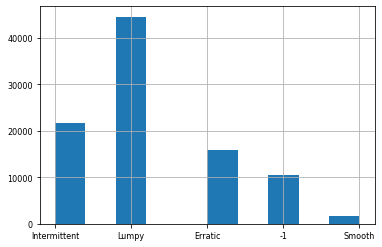

In [453]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern.Demand_pattern.hist()

In [454]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern.Demand_pattern.value_counts()

Lumpy           44592
Intermittent    21720
Erratic         15800
-1              10556
Smooth           1608
Name: Demand_pattern, dtype: int64

In [455]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs_only_best_method_per_sku = df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern.loc[
    df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern.groupby('Artikel_Code').RMSSE.idxmin()]

In [456]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs_only_best_method_per_sku.head()

,index,Artikel_Code,Demand_Class,Forecast_1,Forecast_2,Forecast_3,Forecast_4,Forecast_5,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,RMSSE,Forecast_method,alpha_TSB,beta_TSB,UC_1,UC_2,UC_3,UC_4,UC_5,LC_1,LC_2,LC_3,LC_4,LC_5,MaterialNo,Demand_pattern
15284,923,10000000,NaN,806.889466,806.889466,806.889466,806.889466,806.889466,480.0,2700.0,660.0,500.0,540.0,0.994785,SES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000000,Erratic
37141,924,10000001,NaN,1463.603649,1463.603649,1463.603649,1463.603649,1463.603649,2120.0,1280.0,1840.0,720.0,1660.0,0.441489,SES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000001,Smooth
26269,925,10000002,NaN,846.363490,846.363490,846.363490,846.363490,846.363490,700.0,300.0,1360.0,920.0,1140.0,0.655085,SES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000002,Smooth
28508,926,10000003,1.0,443.210000,445.160000,446.460000,447.110000,447.110000,100.0,360.0,500.0,920.0,460.0,0.604525,Slim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000003,Erratic
35672,927,10000004,NaN,1267.120983,1267.120983,1267.120983,1267.120983,1267.120983,2060.0,1220.0,1820.0,1260.0,880.0,0.467187,SES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000004,Smooth


In [457]:
Best_per_demand_pattern = df_slim_snap_14_jul_filtered_plus_all_RMSSEs_only_best_method_per_sku.groupby(
    ['Demand_pattern']).Forecast_method.value_counts()/(len(df_slim_snap_14_jul_filtered_plus_all_RMSSEs_only_best_method_per_sku)/100)

In [458]:
Best_per_demand_pattern.head(50)

Demand_pattern  Forecast_method
-1              DeepAR             11.184183
                TSB                 0.008486
                Slim                0.004243
Erratic         Slim                4.773219
                SES                 4.505919
                TSB                 3.882218
                DeepAR              3.597946
Intermittent    DeepAR             13.729899
                SES                 5.155077
                TSB                 2.532988
                Slim                1.620773
Lumpy           DeepAR             20.255420
                SES                11.905469
                TSB                 8.371166
                Slim                6.767364
Smooth          DeepAR              0.636429
                Slim                0.398829
                SES                 0.360643
                TSB                 0.309729
Name: Forecast_method, dtype: float64

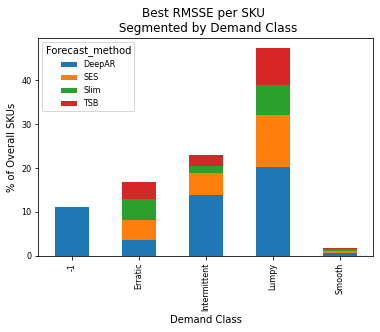

In [459]:
#data = Best_per_demand_pattern.set_index(['Demand_pattern  ', 'Forecast_method']).value
timestr = time.strftime("%Y%m%d-%H%M%S")
mpl.rcParams.update(tex_fonts)
data_print_filename = r'plots\RMSSE_per_demand_class' + timestr + r'.pdf'
Best_per_demand_pattern.unstack().plot(kind='bar', stacked=True)
plt.xlabel('Demand Class')
plt.ylabel('% of Overall SKUs')
plt.title('Best RMSSE per SKU \n Segmented by Demand Class')
mpl.rcParams["axes.grid"] = False

plt.savefig(data_print_filename, format = 'pdf', bbox_inches='tight') 


Okay, double check these numbers, but if correct, these are, for each demand class, which method performs best. Looks to be the same as the above conclusions, where each method had around 1/3 of the SKUs. 

## WRMSSE (new)

Now that we have some better conclusions for the performance of some simple statistical models, in relation to Slim, let's try to expand our loss function to incorporate price weighting. We see that for products with enormous order quantities, mistakes in predicting these can heavily skew the total RMSSE for each model. So we want to weight the RMSSE for each SKU by its price. That way, we control for SKUs with enormous order quantities, but also, we will prioritise prediction performance on SKUs which are of more value, i.e. tie up more working capital in our warehouse. 

We can go about this in a few ways:
1. Get a dataset of unit cost for each SKU, and use that to weight each SKU
2. Get a dataset of total sales over the last n periods, where n is the same as our forecast horizon, and weight each SKU's RMSSE by its percentage of the total sales over that timescale. 

Option 2 is a little bit more complicated, while option 1 is a little more intuitive. As as first go, we're going to do option 1, but note that the M5 forecasting guide seems to use option 2. Specifically however, they do this for 28 days, whereas we would have to do it for n months.

Steps:
1. Get a dataset of base unit price for each SKU, from TED.
2. Import, and attach to the forecast results df. 
3. Divide each RMSSE column by the base unit price. 
4. Sum up the new WRMSSE errors for each forecast method. 

### Get dataset of base unit price

In [1325]:
base_unit_price_df = pd.read_csv(r"Data\base_unit_price_data\base_unit_prices_trimmed.csv", sep = ',')
base_unit_price_df.head()

,Artikel,Vestiging,Goederengroep,Total Stock,Base Unit Of Measure,Rolling Average Price,Price Factor,Rolling Average Price per 1,Stcok Value,Year Total Consumption,Year Total Consumption in €
0,10003547,EN01,10100100,0,ST,0.64,1,0.64,0,17,10.88
1,10003548,EN01,10100100,72,ST,0.14,1,0.14,10.08,26,3.64
2,10003549,EN01,10100100,"1,904.00",ST,0.09,1,0.09,171.36,138,12.42
3,10003550,EN01,10100100,192,ST,0.09,1,0.09,17.28,156,14.04
4,10003551,EN01,10100100,228,ST,0.09,1,0.09,20.52,22,1.98


### Clean column names

In [1326]:
print (list(base_unit_price_df.columns))
base_unit_price_df = base_unit_price_df.rename(columns={"Artikel": "Artikel_Code", 
                                   "Total Stock": "Total_stock",
                                   "Base Unit Of Measure": "BUM",
                                   "Rolling Average Price ": "Rolling_Average_Price",
                                   "Price Factor": "Price_Factor",
                                   "Rolling Average Price per 1": "Rolling_Average_Price_per_1",
                                   "Stcok Value": "Stock_Value",
                                   "Year Total Consumption": "Year_Total_Consumption",
                                   "Year Total Consumption in €": "YTC_In_Euros"})

base_unit_price_df['Artikel_Code'] = base_unit_price_df['Artikel_Code'].astype(str)
base_unit_price_df.head()

['Artikel', 'Vestiging', 'Goederengroep', 'Total Stock', 'Base Unit Of Measure', 'Rolling Average Price ', 'Price Factor', 'Rolling Average Price per 1', 'Stcok Value', 'Year Total Consumption', 'Year Total Consumption in €']


,Artikel_Code,Vestiging,Goederengroep,Total_stock,BUM,Rolling_Average_Price,Price_Factor,Rolling_Average_Price_per_1,Stock_Value,Year_Total_Consumption,YTC_In_Euros
0,10003547,EN01,10100100,0,ST,0.64,1,0.64,0,17,10.88
1,10003548,EN01,10100100,72,ST,0.14,1,0.14,10.08,26,3.64
2,10003549,EN01,10100100,"1,904.00",ST,0.09,1,0.09,171.36,138,12.42
3,10003550,EN01,10100100,192,ST,0.09,1,0.09,17.28,156,14.04
4,10003551,EN01,10100100,228,ST,0.09,1,0.09,20.52,22,1.98


In [1327]:
print (len(base_unit_price_df))
print (base_unit_price_df.Artikel_Code.nunique())

62319
62319


Good, so one row per SKU. 

### Join forecasts df with base_unit_prices df

In [1328]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP = pd.merge(
    df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern,
    base_unit_price_df[['Artikel_Code', 'Rolling_Average_Price_per_1']],
    left_on = 'Artikel_Code',
    right_on = 'Artikel_Code',
    how = 'left')
df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP.head()

,level_0,index,Artikel_Code,Demand_Class,Forecast_1,Forecast_2,Forecast_3,Forecast_4,Forecast_5,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,RMSSE,Forecast_method,alpha_TSB,beta_TSB,UC_1,UC_2,UC_3,UC_4,UC_5,LC_1,LC_2,LC_3,LC_4,LC_5,MaterialNo,Demand_pattern,Rolling_Average_Price_per_1
0,0,78206.0,12364455,4.0,0.000000,0.000000,2500.500000,0.000000,0.000000,0.0,0.0,2.0,0.0,0.0,1619.213063,Slim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12364455,Intermittent,1.1869
1,1,85972.0,12578505,4.0,0.000000,5.500000,0.000000,0.000000,0.000000,2.0,0.0,0.0,3900.0,0.0,795.296469,Slim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12578505,Lumpy,0.0748
2,1,NaN,12578505,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,0.0,0.0,3900.0,0.0,795.295678,DeepAR,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12578505,Lumpy,0.0748
3,3,NaN,12578505,NaN,0.220210,0.220210,0.220210,0.220210,0.220210,2.0,0.0,0.0,3900.0,0.0,795.250755,TSB_grid_search,0.424043,0.008214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12578505,Lumpy,0.0748
4,4,85972.0,12578505,NaN,0.255814,0.255814,0.255814,0.255814,0.255814,2.0,0.0,0.0,3900.0,0.0,795.243492,SES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12578505,Lumpy,0.0748


### Sum errors per forecast method

In [1329]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP['WRMSSE'] = df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP['RMSSE'] * df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP['Rolling_Average_Price_per_1']
sum_errors = df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP.groupby(['Forecast_method']).WRMSSE.sum().reset_index()


sum_errors.head()

,Forecast_method,WRMSSE
0,DeepAR,104713.319786
1,SES,120556.259543
2,Slim,182398.337732
3,TSB_grid_search,111993.934869


In [1330]:
Slim_error = sum_errors.loc[sum_errors['Forecast_method'] == 'Slim', 'WRMSSE']
sum_errors['WRMSSE'] = sum_errors['WRMSSE']/Slim_error.values[0]
sum_errors.head()

,Forecast_method,WRMSSE
0,DeepAR,0.574091
1,SES,0.660950
2,Slim,1.000000
3,TSB_grid_search,0.614007


### Histograms 

<AxesSubplot:ylabel='Frequency'>

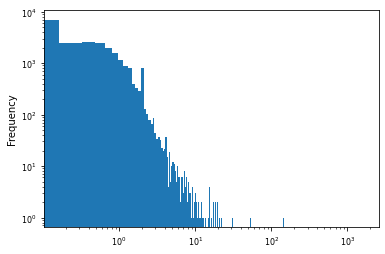

In [1209]:
df_Slim = df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP[
    df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP['Forecast_method'] == 'Slim'
]
df_Slim['RMSSE'].plot.hist(bins = 10000, logx = True, logy = True)

<AxesSubplot:ylabel='Frequency'>

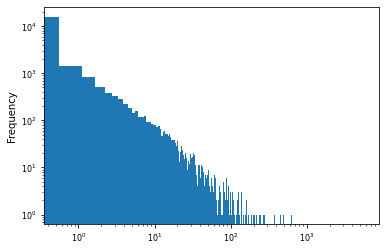

In [1210]:
df_Slim['WRMSSE'].plot.hist(bins = 10000, logx = True, logy = True)

<AxesSubplot:ylabel='Frequency'>

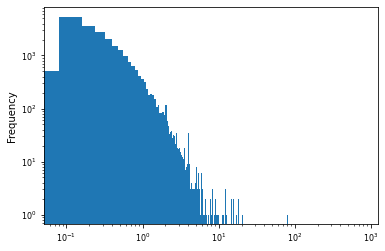

In [1205]:
df_SES = df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP[
    df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP['Forecast_method'] == 'SES'
]
df_SES['RMSSE'].plot.hist(bins = 10000, logx = True, logy = True)


<AxesSubplot:ylabel='Frequency'>

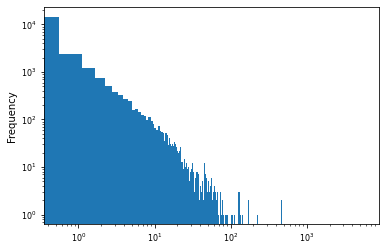

In [1206]:
df_SES['WRMSSE'].plot.hist(bins = 10000, logx = True, logy = True)

<AxesSubplot:ylabel='Frequency'>

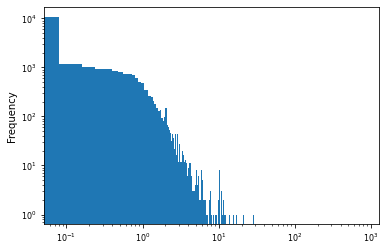

In [1211]:
df_DeepAR = df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP[
    df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP['Forecast_method'] == 'DeepAR'
]
df_DeepAR['RMSSE'].plot.hist(bins = 10000, logx = True, logy = True)

<AxesSubplot:ylabel='Frequency'>

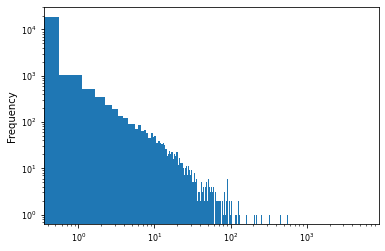

In [1212]:
df_DeepAR['WRMSSE'].plot.hist(bins = 10000, logx = True, logy = True)

### Top n errors

In [1331]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP = df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP.sort_values('WRMSSE', ascending = False)
df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP.head(50)

,level_0,index,Artikel_Code,Demand_Class,Forecast_1,Forecast_2,Forecast_3,Forecast_4,Forecast_5,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,RMSSE,Forecast_method,alpha_TSB,beta_TSB,UC_1,UC_2,UC_3,UC_4,UC_5,LC_1,LC_2,LC_3,LC_4,LC_5,MaterialNo,Demand_pattern,Rolling_Average_Price_per_1,WRMSSE
17,20,NaN,12192616,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000,12.00,0.000,4900.00,0.00,416.256027,DeepAR,NaN,NaN,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,12192616,Lumpy,13.3233,5545.903931
18,18,NaN,12192616,NaN,9.382283e-01,9.382283e-01,9.382283e-01,9.382283e-01,9.382283e-01,0.000,12.00,0.000,4900.00,0.00,416.176161,TSB_grid_search,0.406122,0.111379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12192616,Lumpy,13.3233,5544.839840
19,19,73651.0,12192616,NaN,1.325582e+00,1.325582e+00,1.325582e+00,1.325582e+00,1.325582e+00,0.000,12.00,0.000,4900.00,0.00,416.143205,SES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12192616,Lumpy,13.3233,5544.400761
20,20,73651.0,12192616,4.0,0.000000e+00,1.750000e+00,0.000000e+00,1.750000e+00,0.000000e+00,0.000,12.00,0.000,4900.00,0.00,416.107028,Slim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12192616,Lumpy,13.3233,5543.918764
4385,4032,125581.0,13663631,5.0,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000,0.00,0.000,0.00,0.00,2.049390,Slim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13663631,-1,2068.9100,4240.003782
3564,3564,113916.0,13410352,2.0,5.300000e-01,5.400000e-01,5.500000e-01,5.600000e-01,5.600000e-01,0.090,0.12,0.360,0.33,0.21,2.185860,Slim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13410352,Intermittent,1733.7400,3789.712966
584,584,92000.0,12709405,4.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000,4.20,0.000,0.00,0.00,8.244432,Slim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12709405,Lumpy,364.7700,3007.321589
607,608,92000.0,12709405,NaN,4.926440e-48,4.926440e-48,4.926440e-48,4.926440e-48,4.926440e-48,0.000,4.20,0.000,0.00,0.00,8.020235,SES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12709405,Lumpy,364.7700,2925.541132
608,584,NaN,12709405,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000,4.20,0.000,0.00,0.00,8.020235,DeepAR,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12709405,Lumpy,364.7700,2925.541132
611,611,NaN,12709405,NaN,9.523770e-03,9.523770e-03,9.523770e-03,9.523770e-03,9.523770e-03,0.000,4.20,0.000,0.00,0.00,8.002131,TSB_grid_search,0.247950,0.455686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12709405,Lumpy,364.7700,2918.937433


Why are there errors for SKUs with no actual demand? 

Because, RMSSE's denominator is calculated for the historic data, while RMSSE's numerator is calculated for the numerator.

### WRMSSE Best method per SKU

In [1332]:
del df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP['level_0']
df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP = df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP.reset_index()
'''
df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP_only_best_method_per_sku = df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP.loc[
    df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP.groupby('Artikel_Code').WRMSSE.idxmin()]
'''
df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP_only_best_method_per_sku = df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP.sort_values('WRMSSE').drop_duplicates('Artikel_Code', keep = 'first') # sort_values puts lowest RMSSE at top, drop_duplicates keeps first value for each SKU

In [1333]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP_only_best_method_per_sku.head()

,level_0,index,Artikel_Code,Demand_Class,Forecast_1,Forecast_2,Forecast_3,Forecast_4,Forecast_5,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,RMSSE,Forecast_method,alpha_TSB,beta_TSB,UC_1,UC_2,UC_3,UC_4,UC_5,LC_1,LC_2,LC_3,LC_4,LC_5,MaterialNo,Demand_pattern,Rolling_Average_Price_per_1,WRMSSE
93003,94275,NaN,13456509,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DeepAR,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13456509,-1,17.6200,0.0
84035,94246,67980.0,12057458,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Slim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12057458,Intermittent,3.8100,0.0
84034,94272,64815.0,11918273,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Slim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11918273,Lumpy,0.1892,0.0
84033,94271,65837.0,11950952,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Slim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11950952,-1,13.6500,0.0
84032,94270,NaN,12950027,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DeepAR,NaN,NaN,9.0,5.0,5.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,12950027,Intermittent,1.1698,0.0


In [1334]:
print (len(df_slim_snap_14_jul_filtered_plus_all_RMSSEs_only_best_method_per_sku))

23569


In [1335]:
df_slim_snap_14_jul_filtered_plus_all_RMSSEs_only_best_method_per_sku.Forecast_method.value_counts()

DeepAR             11652
SES                 5167
TSB_grid_search     3560
Slim                3190
Name: Forecast_method, dtype: int64

In [1336]:
Best_per_demand_pattern_WRMSSE = df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP_only_best_method_per_sku.groupby(
    ['Demand_pattern']).Forecast_method.value_counts()

In [1337]:
Best_per_demand_pattern_WRMSSE.head(50)

Demand_pattern  Forecast_method
-1              Slim               2098
                DeepAR              453
                SES                  72
                TSB_grid_search      16
Erratic         Slim               1175
                SES                1065
                TSB_grid_search     915
                DeepAR              795
Intermittent    DeepAR             1858
                Slim               1743
                SES                1233
                TSB_grid_search     596
Lumpy           DeepAR             3720
                SES                2842
                Slim               2611
                TSB_grid_search    1975
Smooth          Slim                178
                SES                  93
                TSB_grid_search      73
                DeepAR               58
Name: Forecast_method, dtype: int64

## WRMSSE - checks, + second analysis phase

Let's create a plotting function, to check/debug our WRMSSE numbers. We want to plot all the historic demand, the forecasts for each method over the given timeframe, and the realised demand over that timeframe.

In [1338]:
MSEG_data_monthly = pd.read_pickle(r'pickles/MSEG_data_filtered_month_level.pkl')
importlib.reload(Plotting_ED)
print (plt.style.available)

print("Your style sheets are located at: {}".format(path.join(mpl.__path__[0], 'mpl-data', 'stylelib')))

timestr = time.strftime("%Y%m%d-%H%M%S")
width = 386.67296
tex_fonts = {
# Use LaTeX to write all text
"text.usetex": False,
"font.family": "serif",
"font.serif"  : "cm",
# Use 10pt font in plots, to match 10pt font in document
"axes.labelsize": 10,
"font.size": 10,
# Make the legend/label fonts a little smaller
"legend.fontsize": 8,
"xtick.labelsize": 8,
"ytick.labelsize": 8
}

mpl.rcParams.update(tex_fonts)
timestr = time.strftime("%Y%m%d-%H%M%S")
#data_print_filename = r'Figures\Brock_Hommes\BH_time_series' + timestr + r'.pdf'

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10', 'tex']
Your style sheets are located at: C:\Users\shahe\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib


Text(0.5, 1.0, '13029259')

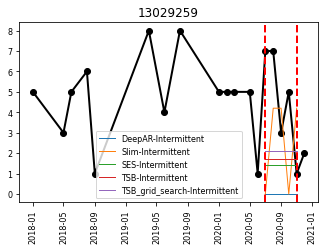

In [1030]:
%matplotlib inline

selected_sku = '13029259'

#plt.savefig(data_print_filename, format = 'pdf', bbox_inches='tight')

plt.figure(figsize = Plotting_ED.set_size(width))
#plt.figure(figsize = (12,8))

MSEG_data_monthly_one_sku = MSEG_data_monthly[MSEG_data_monthly['MaterialNo'] == selected_sku]
forecasts_one_sku = df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP[
    df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP['Artikel_Code'] == selected_sku]

plt.plot(MSEG_data_monthly_one_sku['PostingDate'].values, 
         MSEG_data_monthly_one_sku['OQ'], 
         linewidth = 2, 
         color = 'k',
         marker = 'o')
prediction_months = pd.date_range('2020-07-01','2020-11-01', freq='MS').strftime("%Y-%m-%d").tolist()
prediction_months = [datetime.strptime(x, "%Y-%m-%d") for x in prediction_months]

for index, row in forecasts_one_sku.iterrows():
    
    forecast_data = row['Forecast_1' : 'Forecast_5']
    #print (forecast_data)
    forecast_method = row['Forecast_method']
    plt.plot(prediction_months, forecast_data, linewidth = 1, label = row['Forecast_method'] + '-' + str(row['Demand_pattern']))
    
    
plt.axvline(np.datetime64('2020-07-01'), color='r', linestyle='--', lw=2)
plt.axvline(np.datetime64('2020-11-01'), color='r', linestyle='--', lw=2)
plt.xticks(rotation=90)
plt.legend()
plt.title(selected_sku)


    

In [1007]:
forecasts_one_sku.head()

,level_0,index,Artikel_Code,Demand_Class,Forecast_1,Forecast_2,Forecast_3,Forecast_4,Forecast_5,Actual_1,Actual_2,Actual_3,Actual_4,Actual_5,RMSSE,Forecast_method,alpha_TSB,beta_TSB,MaterialNo,Demand_pattern,Rolling_Average_Price_per_1,WRMSSE
51,51,NaN,13029259,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,7.0,7.0,3.0,5.0,1.0,1.451869,DeepAR,NaN,NaN,13029259,Intermittent,702.58,1020.054348
67,67,99976.0,13029259,4.0,0.000000,4.200000,4.200000,0.000000,4.200000,7.0,7.0,3.0,5.0,1.0,1.217458,Slim,NaN,NaN,13029259,Intermittent,702.58,855.361582
80,80,99976.0,13029259,NaN,1.418605,1.418605,1.418605,1.418605,1.418605,7.0,7.0,3.0,5.0,1.0,1.110476,SES,NaN,NaN,13029259,Intermittent,702.58,780.198470
86,86,99976.0,13029259,NaN,1.698687,1.698687,1.698687,1.698687,1.698687,7.0,7.0,3.0,5.0,1.0,1.047927,TSB,NaN,NaN,13029259,Intermittent,702.58,736.252517
97,97,NaN,13029259,NaN,2.084380,2.084380,2.084380,2.084380,2.084380,7.0,7.0,3.0,5.0,1.0,0.965705,TSB_grid_search,0.287248,0.188421,13029259,Intermittent,702.58,678.484823


In [1016]:
import plottools

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 336-337: truncated \UXXXXXXXX escape (plottools.py, line 25)

In [34]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))
df_adi_cv_results_2020.plot.scatter(x = 'ADI_2020', y = 'CV_2_2020', s = 0.5, ax = ax, c=df_adi_cv_results_2020['Demand_pattern_2020'].apply(lambda x: colors[x]))

tex_fonts = {
# Use LaTeX to write all text
"text.usetex": False,
"font.family": "serif",
"font.serif"  : "cm",
# Use 10pt font in plots, to match 10pt font in document
"axes.labelsize": 10,
"font.size": 10,
# Make the legend/label fonts a little smaller
"legend.fontsize": 10,
"xtick.labelsize": 10,
"ytick.labelsize": 10
}
mpl.rcParams.update(tex_fonts)


def plot_one_sku(MSEG_data, Forecast_data, selected_sku):
    
    mpl.rcParams.update(tex_fonts)
    timestr = time.strftime("%Y%m%d-%H%M%S")
    data_print_filename = r'plots\forecasts_' + timestr + '_' + selected_sku + r'.pdf'
    
    plt.figure(figsize = Plotting_ED.set_size(width))
    
    
    colors = {'DeepAR':'blue', 'Slim':'red', 'SES':'green', 'TSB':'yellow', 'TSB_grid_search': 'yellow'}
    colors_legend = {'DeepAR':'blue', 'Slim':'red', 'SES':'green','TSB':'yellow', 'TSB_grid_search':'yellow'}

    MSEG_data_monthly_one_sku = MSEG_data[MSEG_data['MaterialNo'] == selected_sku]
    #print (MSEG_data_monthly_one_sku)
    forecasts_one_sku = Forecast_data[
        Forecast_data['Artikel_Code'] == selected_sku]

    plt.plot(MSEG_data_monthly_one_sku['PostingDate'].values, 
             MSEG_data_monthly_one_sku['OQ'], 
             linewidth = 0.1, 
             color = 'k',
             marker = 'o',
             markersize = 0.1)
    prediction_months = pd.date_range('2020-07-01','2020-11-01', freq='MS').strftime("%Y-%m-%d").tolist()
    prediction_months = [datetime.strptime(x, "%Y-%m-%d") for x in prediction_months]

    for index, row in forecasts_one_sku.iterrows():
        
        forecast_data = row['Forecast_1' : 'Forecast_5']
        forecast_method = row['Forecast_method']
        if (forecast_method == 'TSB_grid_search'):
            forecast_method = 'TSB'
        plt.plot(prediction_months, 
                 forecast_data, 
                 linewidth = 0.5, 
                 label = forecast_method + '(' + str(round(row['RMSSE'], 2)) + ')',
                color = colors[forecast_method])       
        if (forecast_method == 'DeepAR'):
            UC_data = np.array(row['UC_1' : 'UC_5'], dtype=float)
            LC_data =np.array(row['LC_1' : 'LC_5'], dtype=float)
            forecast_data = np.array(forecast_data, dtype=float)
            plt.fill_between(prediction_months, LC_data, UC_data, color='b', alpha=0.1) #std curves.



    plt.axvline(np.datetime64('2020-07-01'), color='r', linestyle='--', lw=0.5)
    plt.axvline(np.datetime64('2020-11-01'), color='r', linestyle='--', lw=0.5)
    plt.axvline(np.datetime64('2019-07-01'), color='b', linestyle='--', lw=0.5)

    plt.xticks(rotation=90)
    plt.legend()
    plt.title(selected_sku)
    
    plt.xlabel('Timestamp')
    plt.ylabel('Demand (base units)')
    plt.title('Demand History and Predictions' + '\n' + selected_sku)
    plt.savefig(data_print_filename, format = 'pdf', bbox_inches='tight')  


unique_skus = df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP.Artikel_Code.unique().tolist()
number_of_skus_to_plot = 50

for i in range(number_of_skus_to_plot):
    random_sku = random.choice(unique_skus)
    plot_one_sku(df_MSEG_filtered_with_missing_months_group_by_plus_counts_and_OQ,
            df_slim_snap_14_jul_filtered_plus_all_RMSSEs_plus_demand_pattern_plus_BUP,
            random_sku)



NameError: name 'df_adi_cv_results_2020' is not defined